In [29]:
experiment_name= "C2S_BBox_resnet34_TripletMining_Ptr"

In [2]:
import glob
import cv2

import matplotlib.pyplot as plt
%matplotlib inline
from pandas.core.common import flatten
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import datasets
import networks
import utils

In [3]:
#######################################################
#                  Create Dataset
#######################################################
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

'''
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()
                               ,
                              transforms.Normalize(mean, std)
                              ])
''' 

transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

#######################################################
#                  Create Train Dataset
#######################################################
dataset_train = datasets.DeepFashionBBoxDataset(img_dir="./images",train_path="DeepFashionDataset_train.csv",mode="train", transform= transform)
triplet_dataset_train = datasets.TripletDeepFashion(dataset_train, mode="train")

#######################################################
#                  Create Valid Dataset
#######################################################
dataset_valid = datasets.DeepFashionDataset(img_dir="./images",validation_path="DeepFashionDataset_validation.csv",mode="validation", transform= transform)
triplet_dataset_valid = datasets.TripletDeepFashion(dataset_valid, mode="validation")

#######################################################
#                  Create Test Dataset
#######################################################
dataset_test = datasets.DeepFashionDataset(img_dir="./images",test_path="DeepFashionDataset_test.csv",mode="test", transform= transform)
triplet_dataset_test = datasets.TripletDeepFashion(dataset_test, mode="test")

In [4]:
len(dataset_train)

159062

In [5]:
len(dataset_train.classes_set)

17968

In [6]:
len(dataset_valid)

20106

In [7]:
dataset_train.labels[:100]

array([ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,
        2,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  5,  5,  5,  6,  6,  6,
        7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,
        9,  9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13,
       13, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16,
       16, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18])

In [8]:
dataset_train.data[:5]

['CLOTHING/Blouse/id_00005025/comsumer_01.jpg',
 'CLOTHING/Blouse/id_00005025/comsumer_02.jpg',
 'CLOTHING/Blouse/id_00005025/comsumer_03.jpg',
 'CLOTHING/Blouse/id_00005025/comsumer_04.jpg',
 'CLOTHING/Blouse/id_00005025/comsumer_05.jpg']

In [9]:
dataset_train.classes[:5]

['CLOTHING/Blouse/id_00005025',
 'CLOTHING/Blouse/id_00005025',
 'CLOTHING/Blouse/id_00005025',
 'CLOTHING/Blouse/id_00005025',
 'CLOTHING/Blouse/id_00005025']

In [10]:
batch_size= 4
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# Visualize some sample data
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

In [11]:
images.shape

(4, 3, 224, 224)

In [12]:
labels

tensor([ 6013, 12653, 11105, 10102])

In [13]:
# labels to class names:
print([dataset_train.classes_set[i.item()] for i in labels ])

['TOPS/Summer_Wear/id_00003155', 'TOPS/T_Shirt/id_00008061', 'TOPS/Summer_Wear/id_00032209', 'TOPS/Summer_Wear/id_00028183']


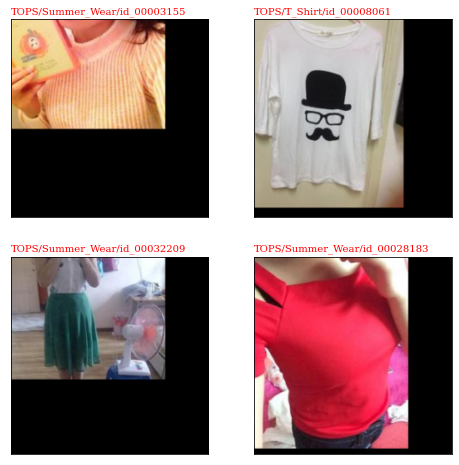

In [14]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(8, 8))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(train_loader.dataset.classes_set[labels[idx].item()], fontfamily='serif', loc='left', fontsize='medium', color= 'red')
    

In [15]:
# check if CUDA is available
cuda = torch.cuda.is_available()

if not cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

## Steps
1. Create a dataset returning triplets 
2. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
3. Define **triplet** network processing triplets - **TripletNet** wrapping *EmbeddingNet*
4. Train the network with **TripletLoss** - *losses.py*

In [16]:
triplet_train_loader = torch.utils.data.DataLoader(triplet_dataset_train, batch_size=batch_size, shuffle=False)
triplet_valid_loader = torch.utils.data.DataLoader(triplet_dataset_valid, batch_size=batch_size, shuffle=False)
triplet_test_loader = torch.utils.data.DataLoader(triplet_dataset_test, batch_size=batch_size, shuffle=False)

In [17]:
print(len(triplet_train_loader.dataset.classes))
print(len(triplet_valid_loader.dataset.classes))
print(len(triplet_test_loader.dataset.classes))

159062
20106
20174


# Use pre-trained model on Kaggle Fashion items

In [18]:
# Load the pretrained model from pytorch
embedding_net= torchvision.models.resnet34(pretrained=False)

embedding_net.fc= nn.Sequential(nn.Linear(512, 128),
                                nn.BatchNorm1d(128),
                                nn.ReLU(),
                                nn.Linear(128, 47) # Kaggle fashion items included 47 classes
                                )

experiment_name= "KaggleFashion_pretrain_classification_resnet34"
PATH= './Results/'+experiment_name+'_100epoch.pt'

check_point= torch.load(PATH)
embedding_net.load_state_dict(check_point['model_state_dict'])
epoch = check_point['epoch']

# Un-Freeze training for all layers parameters:
for param in embedding_net.parameters():
    param.required_grad = True    


/home/ayla/anaconda3/envs/fashion/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ayla/anaconda3/envs/fashion/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# Modify the final layer of the embedding network:

In [19]:
embedding_net.fc= nn.Sequential(nn.Linear(512, 256),
                                nn.BatchNorm1d(256),
                                nn.ReLU(),
                                nn.Linear(256, 256), # embedding size 256
                                )

In [20]:
# Un-Freeze training for all layers parameters:
for param in embedding_net.parameters():
    param.required_grad = True    

In [21]:
model= networks.TripletNet(embedding_net)

In [22]:
device = torch.device('cuda')
model.to(device)

TripletNet(
  (embedding_net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [23]:
# Set up the training parameters
from losses import TripletLoss
margin = 1.
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)


In [24]:
def train_epoch(train_loader, model, loss_fn, optimizer, log_interval, cuda):

    ###################
    # train the model #
    ###################
    model.train()

   # keep track of training loss
    train_loss = 0.0
    losses = []

    for batch_idx, (data, target) in enumerate(train_loader):
        
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        
        # move tensors to GPU if CUDA is available
        if cuda:
            data = tuple(d.to(device) for d in data)
            if target is not None:
                target = tuple(t.to(device) for t in target)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: create embeddings of the inputs
        #outputs = model.get_embedding(*data) # For online mining
        outputs = model(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        # append targets to the end of the embeddings, and calculate the batch loss
        loss_outputs = loss_fn(*loss_inputs)
        
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update training loss
        train_loss += loss.item()

        losses.append(loss.item())
        
        # Provide some feedbach within one epoch
        if batch_idx % log_interval == 0:
            print('Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses)))
            losses = []

    # calculate average train loss (batch average is returned)
    train_loss /= (batch_idx + 1)
    
    return train_loss

In [25]:
def test_epoch(val_loader, model, loss_fn, cuda):
    
    ######################    
    # validate the model #
    ######################
    
    # keep track of validation loss
    valid_loss = 0.0
    
    with torch.no_grad():

        model.eval()
        for batch_idx, (data, target) in enumerate(val_loader):

            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            
            if cuda:
                data = tuple(d.to(device) for d in data)
                if target is not None:
                    target = tuple(t.to(device) for t in target)
            
            #outputs = model.get_embedding(*data) # For online mining
            outputs = model(*data)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
                
            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            
            # update average validation loss 
            valid_loss += loss.item()
            
    # calculate average validation loss (batch average is returned)
    valid_loss /= (batch_idx + 1)

    return valid_loss

In [26]:
def save_model(EPOCH, model, optimizer, LOSS): # epoch and loss are numbers
    """
    Save the trained model and the optimizer to disk.
    """      
    torch.save({
                'epoch': EPOCH,
                'model_state_dict': model.embedding_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': LOSS,
                }, experiment_name+'.pt')

In [27]:
start_epoch= 0
n_epochs= 75

log_interval=50

train_losses, valid_losses = [], []

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(start_epoch, n_epochs):
    
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    train_loss = train_epoch(triplet_train_loader, model, loss_fn, optimizer, log_interval, cuda)
    valid_loss = test_epoch(triplet_valid_loader, model, loss_fn, cuda)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # print training/validation statistics 
    print('Epoch: Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch + 1, n_epochs, train_loss, valid_loss))
         
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format( valid_loss_min,
                                                                                          valid_loss))
        save_model(epoch, model, optimizer, train_loss)
        valid_loss_min = valid_loss
    

Train: [0/159062 (0%)]	Loss: 14.305967
Train: [200/159062 (0%)]	Loss: 10.695698
Train: [400/159062 (0%)]	Loss: 8.355480
Train: [600/159062 (0%)]	Loss: 5.423914
Train: [800/159062 (1%)]	Loss: 4.796301
Train: [1000/159062 (1%)]	Loss: 4.462497
Train: [1200/159062 (1%)]	Loss: 5.609521
Train: [1400/159062 (1%)]	Loss: 4.496434
Train: [1600/159062 (1%)]	Loss: 3.516063
Train: [1800/159062 (1%)]	Loss: 2.685859
Train: [2000/159062 (1%)]	Loss: 2.048929
Train: [2200/159062 (1%)]	Loss: 2.209241
Train: [2400/159062 (2%)]	Loss: 2.052904
Train: [2600/159062 (2%)]	Loss: 1.302714
Train: [2800/159062 (2%)]	Loss: 1.761122
Train: [3000/159062 (2%)]	Loss: 1.632967
Train: [3200/159062 (2%)]	Loss: 1.978078
Train: [3400/159062 (2%)]	Loss: 1.873285
Train: [3600/159062 (2%)]	Loss: 2.142999
Train: [3800/159062 (2%)]	Loss: 1.511931
Train: [4000/159062 (3%)]	Loss: 1.980604
Train: [4200/159062 (3%)]	Loss: 1.820941
Train: [4400/159062 (3%)]	Loss: 1.427683
Train: [4600/159062 (3%)]	Loss: 1.698406
Train: [4800/159062 (

Train: [38800/159062 (24%)]	Loss: 1.000222
Train: [39000/159062 (25%)]	Loss: 1.001385
Train: [39200/159062 (25%)]	Loss: 1.002116
Train: [39400/159062 (25%)]	Loss: 1.005426
Train: [39600/159062 (25%)]	Loss: 1.004296
Train: [39800/159062 (25%)]	Loss: 1.006759
Train: [40000/159062 (25%)]	Loss: 0.991376
Train: [40200/159062 (25%)]	Loss: 1.038796
Train: [40400/159062 (25%)]	Loss: 0.947396
Train: [40600/159062 (26%)]	Loss: 1.007595
Train: [40800/159062 (26%)]	Loss: 1.012548
Train: [41000/159062 (26%)]	Loss: 0.993079
Train: [41200/159062 (26%)]	Loss: 1.018366
Train: [41400/159062 (26%)]	Loss: 1.007163
Train: [41600/159062 (26%)]	Loss: 1.003427
Train: [41800/159062 (26%)]	Loss: 1.008467
Train: [42000/159062 (26%)]	Loss: 1.001458
Train: [42200/159062 (27%)]	Loss: 0.917563
Train: [42400/159062 (27%)]	Loss: 1.010899
Train: [42600/159062 (27%)]	Loss: 1.011626
Train: [42800/159062 (27%)]	Loss: 1.002451
Train: [43000/159062 (27%)]	Loss: 1.008346
Train: [43200/159062 (27%)]	Loss: 0.999456
Train: [434

Train: [77000/159062 (48%)]	Loss: 1.049504
Train: [77200/159062 (49%)]	Loss: 1.005057
Train: [77400/159062 (49%)]	Loss: 0.992316
Train: [77600/159062 (49%)]	Loss: 1.003995
Train: [77800/159062 (49%)]	Loss: 1.007087
Train: [78000/159062 (49%)]	Loss: 0.985853
Train: [78200/159062 (49%)]	Loss: 1.007920
Train: [78400/159062 (49%)]	Loss: 1.039589
Train: [78600/159062 (49%)]	Loss: 0.966481
Train: [78800/159062 (50%)]	Loss: 1.017990
Train: [79000/159062 (50%)]	Loss: 1.010344
Train: [79200/159062 (50%)]	Loss: 1.008368
Train: [79400/159062 (50%)]	Loss: 1.006573
Train: [79600/159062 (50%)]	Loss: 1.007396
Train: [79800/159062 (50%)]	Loss: 0.990221
Train: [80000/159062 (50%)]	Loss: 0.988995
Train: [80200/159062 (50%)]	Loss: 0.979375
Train: [80400/159062 (51%)]	Loss: 1.003686
Train: [80600/159062 (51%)]	Loss: 0.936263
Train: [80800/159062 (51%)]	Loss: 1.013374
Train: [81000/159062 (51%)]	Loss: 1.016160
Train: [81200/159062 (51%)]	Loss: 0.980385
Train: [81400/159062 (51%)]	Loss: 0.996399
Train: [816

Train: [114800/159062 (72%)]	Loss: 0.934734
Train: [115000/159062 (72%)]	Loss: 1.048902
Train: [115200/159062 (72%)]	Loss: 0.956763
Train: [115400/159062 (73%)]	Loss: 1.001044
Train: [115600/159062 (73%)]	Loss: 0.958072
Train: [115800/159062 (73%)]	Loss: 0.994846
Train: [116000/159062 (73%)]	Loss: 1.010429
Train: [116200/159062 (73%)]	Loss: 0.974702
Train: [116400/159062 (73%)]	Loss: 0.937974
Train: [116600/159062 (73%)]	Loss: 0.989615
Train: [116800/159062 (73%)]	Loss: 0.943911
Train: [117000/159062 (74%)]	Loss: 0.916765
Train: [117200/159062 (74%)]	Loss: 0.932695
Train: [117400/159062 (74%)]	Loss: 0.919085
Train: [117600/159062 (74%)]	Loss: 0.983839
Train: [117800/159062 (74%)]	Loss: 0.998223
Train: [118000/159062 (74%)]	Loss: 1.013343
Train: [118200/159062 (74%)]	Loss: 0.947765
Train: [118400/159062 (74%)]	Loss: 0.996427
Train: [118600/159062 (75%)]	Loss: 1.016339
Train: [118800/159062 (75%)]	Loss: 0.950966
Train: [119000/159062 (75%)]	Loss: 1.055543
Train: [119200/159062 (75%)]	Los

Train: [152200/159062 (96%)]	Loss: 1.017025
Train: [152400/159062 (96%)]	Loss: 0.956256
Train: [152600/159062 (96%)]	Loss: 1.007820
Train: [152800/159062 (96%)]	Loss: 0.934351
Train: [153000/159062 (96%)]	Loss: 0.998390
Train: [153200/159062 (96%)]	Loss: 1.020947
Train: [153400/159062 (96%)]	Loss: 0.998803
Train: [153600/159062 (97%)]	Loss: 1.028232
Train: [153800/159062 (97%)]	Loss: 0.998340
Train: [154000/159062 (97%)]	Loss: 0.965924
Train: [154200/159062 (97%)]	Loss: 1.029843
Train: [154400/159062 (97%)]	Loss: 1.023392
Train: [154600/159062 (97%)]	Loss: 0.981662
Train: [154800/159062 (97%)]	Loss: 1.010122
Train: [155000/159062 (97%)]	Loss: 1.022174
Train: [155200/159062 (98%)]	Loss: 0.969982
Train: [155400/159062 (98%)]	Loss: 1.008516
Train: [155600/159062 (98%)]	Loss: 0.989574
Train: [155800/159062 (98%)]	Loss: 0.942376
Train: [156000/159062 (98%)]	Loss: 0.946078
Train: [156200/159062 (98%)]	Loss: 1.012509
Train: [156400/159062 (98%)]	Loss: 0.993342
Train: [156600/159062 (98%)]	Los

Train: [31000/159062 (19%)]	Loss: 0.959879
Train: [31200/159062 (20%)]	Loss: 1.002003
Train: [31400/159062 (20%)]	Loss: 0.974077
Train: [31600/159062 (20%)]	Loss: 1.041509
Train: [31800/159062 (20%)]	Loss: 0.990233
Train: [32000/159062 (20%)]	Loss: 1.010789
Train: [32200/159062 (20%)]	Loss: 0.964529
Train: [32400/159062 (20%)]	Loss: 0.940949
Train: [32600/159062 (20%)]	Loss: 0.989507
Train: [32800/159062 (21%)]	Loss: 0.935961
Train: [33000/159062 (21%)]	Loss: 1.024997
Train: [33200/159062 (21%)]	Loss: 0.961590
Train: [33400/159062 (21%)]	Loss: 1.025188
Train: [33600/159062 (21%)]	Loss: 0.912547
Train: [33800/159062 (21%)]	Loss: 0.934516
Train: [34000/159062 (21%)]	Loss: 0.963950
Train: [34200/159062 (22%)]	Loss: 1.031373
Train: [34400/159062 (22%)]	Loss: 0.929041
Train: [34600/159062 (22%)]	Loss: 1.065681
Train: [34800/159062 (22%)]	Loss: 0.981471
Train: [35000/159062 (22%)]	Loss: 1.003057
Train: [35200/159062 (22%)]	Loss: 1.005481
Train: [35400/159062 (22%)]	Loss: 0.989639
Train: [356

Train: [69200/159062 (44%)]	Loss: 1.006976
Train: [69400/159062 (44%)]	Loss: 0.999718
Train: [69600/159062 (44%)]	Loss: 0.980467
Train: [69800/159062 (44%)]	Loss: 0.968872
Train: [70000/159062 (44%)]	Loss: 1.002121
Train: [70200/159062 (44%)]	Loss: 0.937064
Train: [70400/159062 (44%)]	Loss: 0.995269
Train: [70600/159062 (44%)]	Loss: 1.000069
Train: [70800/159062 (45%)]	Loss: 1.015117
Train: [71000/159062 (45%)]	Loss: 1.013271
Train: [71200/159062 (45%)]	Loss: 0.988512
Train: [71400/159062 (45%)]	Loss: 0.959004
Train: [71600/159062 (45%)]	Loss: 1.040772
Train: [71800/159062 (45%)]	Loss: 1.009106
Train: [72000/159062 (45%)]	Loss: 0.991819
Train: [72200/159062 (45%)]	Loss: 1.006842
Train: [72400/159062 (46%)]	Loss: 0.993387
Train: [72600/159062 (46%)]	Loss: 0.999220
Train: [72800/159062 (46%)]	Loss: 0.992481
Train: [73000/159062 (46%)]	Loss: 0.961259
Train: [73200/159062 (46%)]	Loss: 0.936803
Train: [73400/159062 (46%)]	Loss: 0.992687
Train: [73600/159062 (46%)]	Loss: 1.044392
Train: [738

Train: [107200/159062 (67%)]	Loss: 0.991691
Train: [107400/159062 (68%)]	Loss: 0.985480
Train: [107600/159062 (68%)]	Loss: 0.977638
Train: [107800/159062 (68%)]	Loss: 1.019904
Train: [108000/159062 (68%)]	Loss: 1.000114
Train: [108200/159062 (68%)]	Loss: 1.020401
Train: [108400/159062 (68%)]	Loss: 0.993730
Train: [108600/159062 (68%)]	Loss: 0.979926
Train: [108800/159062 (68%)]	Loss: 0.990905
Train: [109000/159062 (69%)]	Loss: 0.992613
Train: [109200/159062 (69%)]	Loss: 1.008438
Train: [109400/159062 (69%)]	Loss: 0.961291
Train: [109600/159062 (69%)]	Loss: 0.963749
Train: [109800/159062 (69%)]	Loss: 1.033540
Train: [110000/159062 (69%)]	Loss: 1.003234
Train: [110200/159062 (69%)]	Loss: 1.033584
Train: [110400/159062 (69%)]	Loss: 0.999809
Train: [110600/159062 (70%)]	Loss: 1.034997
Train: [110800/159062 (70%)]	Loss: 1.001126
Train: [111000/159062 (70%)]	Loss: 0.987970
Train: [111200/159062 (70%)]	Loss: 0.989045
Train: [111400/159062 (70%)]	Loss: 0.976938
Train: [111600/159062 (70%)]	Los

Train: [144600/159062 (91%)]	Loss: 1.012092
Train: [144800/159062 (91%)]	Loss: 1.001651
Train: [145000/159062 (91%)]	Loss: 0.990990
Train: [145200/159062 (91%)]	Loss: 0.993150
Train: [145400/159062 (91%)]	Loss: 0.937372
Train: [145600/159062 (92%)]	Loss: 0.969319
Train: [145800/159062 (92%)]	Loss: 1.030715
Train: [146000/159062 (92%)]	Loss: 0.999357
Train: [146200/159062 (92%)]	Loss: 0.964728
Train: [146400/159062 (92%)]	Loss: 1.016513
Train: [146600/159062 (92%)]	Loss: 0.972215
Train: [146800/159062 (92%)]	Loss: 0.968909
Train: [147000/159062 (92%)]	Loss: 0.989956
Train: [147200/159062 (93%)]	Loss: 0.991185
Train: [147400/159062 (93%)]	Loss: 0.965103
Train: [147600/159062 (93%)]	Loss: 1.010487
Train: [147800/159062 (93%)]	Loss: 0.985265
Train: [148000/159062 (93%)]	Loss: 0.986033
Train: [148200/159062 (93%)]	Loss: 0.934283
Train: [148400/159062 (93%)]	Loss: 1.024622
Train: [148600/159062 (93%)]	Loss: 1.013084
Train: [148800/159062 (94%)]	Loss: 1.019817
Train: [149000/159062 (94%)]	Los

Train: [23200/159062 (15%)]	Loss: 0.996336
Train: [23400/159062 (15%)]	Loss: 0.965477
Train: [23600/159062 (15%)]	Loss: 0.938295
Train: [23800/159062 (15%)]	Loss: 0.945772
Train: [24000/159062 (15%)]	Loss: 0.920930
Train: [24200/159062 (15%)]	Loss: 0.930042
Train: [24400/159062 (15%)]	Loss: 1.017876
Train: [24600/159062 (15%)]	Loss: 0.999684
Train: [24800/159062 (16%)]	Loss: 0.984181
Train: [25000/159062 (16%)]	Loss: 0.957076
Train: [25200/159062 (16%)]	Loss: 1.017683
Train: [25400/159062 (16%)]	Loss: 0.944942
Train: [25600/159062 (16%)]	Loss: 1.012155
Train: [25800/159062 (16%)]	Loss: 0.961569
Train: [26000/159062 (16%)]	Loss: 0.907098
Train: [26200/159062 (16%)]	Loss: 0.918701
Train: [26400/159062 (17%)]	Loss: 0.955053
Train: [26600/159062 (17%)]	Loss: 1.048606
Train: [26800/159062 (17%)]	Loss: 0.986848
Train: [27000/159062 (17%)]	Loss: 0.902679
Train: [27200/159062 (17%)]	Loss: 0.985109
Train: [27400/159062 (17%)]	Loss: 0.953057
Train: [27600/159062 (17%)]	Loss: 1.090402
Train: [278

Train: [61400/159062 (39%)]	Loss: 0.948806
Train: [61600/159062 (39%)]	Loss: 0.889323
Train: [61800/159062 (39%)]	Loss: 0.936026
Train: [62000/159062 (39%)]	Loss: 0.896761
Train: [62200/159062 (39%)]	Loss: 0.923496
Train: [62400/159062 (39%)]	Loss: 0.999216
Train: [62600/159062 (39%)]	Loss: 0.969619
Train: [62800/159062 (39%)]	Loss: 0.954229
Train: [63000/159062 (40%)]	Loss: 0.958607
Train: [63200/159062 (40%)]	Loss: 0.907794
Train: [63400/159062 (40%)]	Loss: 0.989359
Train: [63600/159062 (40%)]	Loss: 0.965596
Train: [63800/159062 (40%)]	Loss: 0.964219
Train: [64000/159062 (40%)]	Loss: 0.959801
Train: [64200/159062 (40%)]	Loss: 0.918848
Train: [64400/159062 (40%)]	Loss: 0.872608
Train: [64600/159062 (41%)]	Loss: 0.985951
Train: [64800/159062 (41%)]	Loss: 0.949771
Train: [65000/159062 (41%)]	Loss: 0.940117
Train: [65200/159062 (41%)]	Loss: 0.922307
Train: [65400/159062 (41%)]	Loss: 0.943583
Train: [65600/159062 (41%)]	Loss: 0.956986
Train: [65800/159062 (41%)]	Loss: 0.983087
Train: [660

Train: [99600/159062 (63%)]	Loss: 0.941299
Train: [99800/159062 (63%)]	Loss: 0.914219
Train: [100000/159062 (63%)]	Loss: 0.965952
Train: [100200/159062 (63%)]	Loss: 0.926845
Train: [100400/159062 (63%)]	Loss: 0.981021
Train: [100600/159062 (63%)]	Loss: 0.951708
Train: [100800/159062 (63%)]	Loss: 0.925874
Train: [101000/159062 (63%)]	Loss: 0.896130
Train: [101200/159062 (64%)]	Loss: 0.976369
Train: [101400/159062 (64%)]	Loss: 0.910459
Train: [101600/159062 (64%)]	Loss: 0.862894
Train: [101800/159062 (64%)]	Loss: 0.940100
Train: [102000/159062 (64%)]	Loss: 0.836878
Train: [102200/159062 (64%)]	Loss: 0.920799
Train: [102400/159062 (64%)]	Loss: 0.946664
Train: [102600/159062 (65%)]	Loss: 0.905933
Train: [102800/159062 (65%)]	Loss: 0.878188
Train: [103000/159062 (65%)]	Loss: 0.969876
Train: [103200/159062 (65%)]	Loss: 0.892868
Train: [103400/159062 (65%)]	Loss: 1.021578
Train: [103600/159062 (65%)]	Loss: 1.020089
Train: [103800/159062 (65%)]	Loss: 1.011431
Train: [104000/159062 (65%)]	Loss:

Train: [137000/159062 (86%)]	Loss: 0.939014
Train: [137200/159062 (86%)]	Loss: 0.821327
Train: [137400/159062 (86%)]	Loss: 0.839781
Train: [137600/159062 (87%)]	Loss: 0.893543
Train: [137800/159062 (87%)]	Loss: 0.881611
Train: [138000/159062 (87%)]	Loss: 0.839581
Train: [138200/159062 (87%)]	Loss: 1.009205
Train: [138400/159062 (87%)]	Loss: 0.882588
Train: [138600/159062 (87%)]	Loss: 0.944950
Train: [138800/159062 (87%)]	Loss: 1.000681
Train: [139000/159062 (87%)]	Loss: 0.978290
Train: [139200/159062 (88%)]	Loss: 0.981144
Train: [139400/159062 (88%)]	Loss: 0.974632
Train: [139600/159062 (88%)]	Loss: 0.911070
Train: [139800/159062 (88%)]	Loss: 0.916202
Train: [140000/159062 (88%)]	Loss: 0.962968
Train: [140200/159062 (88%)]	Loss: 0.908292
Train: [140400/159062 (88%)]	Loss: 0.899838
Train: [140600/159062 (88%)]	Loss: 0.779853
Train: [140800/159062 (89%)]	Loss: 0.884123
Train: [141000/159062 (89%)]	Loss: 0.841400
Train: [141200/159062 (89%)]	Loss: 0.952956
Train: [141400/159062 (89%)]	Los

Train: [15400/159062 (10%)]	Loss: 1.017484
Train: [15600/159062 (10%)]	Loss: 0.901591
Train: [15800/159062 (10%)]	Loss: 1.007806
Train: [16000/159062 (10%)]	Loss: 0.974928
Train: [16200/159062 (10%)]	Loss: 0.924039
Train: [16400/159062 (10%)]	Loss: 0.974300
Train: [16600/159062 (10%)]	Loss: 0.974726
Train: [16800/159062 (11%)]	Loss: 1.038247
Train: [17000/159062 (11%)]	Loss: 1.005040
Train: [17200/159062 (11%)]	Loss: 0.993098
Train: [17400/159062 (11%)]	Loss: 0.952435
Train: [17600/159062 (11%)]	Loss: 0.982871
Train: [17800/159062 (11%)]	Loss: 0.897241
Train: [18000/159062 (11%)]	Loss: 0.981347
Train: [18200/159062 (11%)]	Loss: 0.995664
Train: [18400/159062 (12%)]	Loss: 0.952239
Train: [18600/159062 (12%)]	Loss: 0.966604
Train: [18800/159062 (12%)]	Loss: 0.958900
Train: [19000/159062 (12%)]	Loss: 0.987602
Train: [19200/159062 (12%)]	Loss: 1.022998
Train: [19400/159062 (12%)]	Loss: 0.968195
Train: [19600/159062 (12%)]	Loss: 0.928398
Train: [19800/159062 (12%)]	Loss: 0.919210
Train: [200

Train: [53600/159062 (34%)]	Loss: 0.944857
Train: [53800/159062 (34%)]	Loss: 0.946157
Train: [54000/159062 (34%)]	Loss: 0.916140
Train: [54200/159062 (34%)]	Loss: 0.969995
Train: [54400/159062 (34%)]	Loss: 1.041346
Train: [54600/159062 (34%)]	Loss: 0.960602
Train: [54800/159062 (34%)]	Loss: 0.947733
Train: [55000/159062 (35%)]	Loss: 0.895710
Train: [55200/159062 (35%)]	Loss: 1.024334
Train: [55400/159062 (35%)]	Loss: 0.868833
Train: [55600/159062 (35%)]	Loss: 0.953426
Train: [55800/159062 (35%)]	Loss: 1.043299
Train: [56000/159062 (35%)]	Loss: 0.958131
Train: [56200/159062 (35%)]	Loss: 0.989718
Train: [56400/159062 (35%)]	Loss: 0.959650
Train: [56600/159062 (36%)]	Loss: 0.917161
Train: [56800/159062 (36%)]	Loss: 0.911174
Train: [57000/159062 (36%)]	Loss: 0.952415
Train: [57200/159062 (36%)]	Loss: 0.942566
Train: [57400/159062 (36%)]	Loss: 0.980797
Train: [57600/159062 (36%)]	Loss: 0.971126
Train: [57800/159062 (36%)]	Loss: 0.942444
Train: [58000/159062 (36%)]	Loss: 0.970649
Train: [582

Train: [91800/159062 (58%)]	Loss: 0.850520
Train: [92000/159062 (58%)]	Loss: 0.908481
Train: [92200/159062 (58%)]	Loss: 0.959904
Train: [92400/159062 (58%)]	Loss: 0.820957
Train: [92600/159062 (58%)]	Loss: 0.918923
Train: [92800/159062 (58%)]	Loss: 0.867080
Train: [93000/159062 (58%)]	Loss: 0.886865
Train: [93200/159062 (59%)]	Loss: 0.902116
Train: [93400/159062 (59%)]	Loss: 0.943574
Train: [93600/159062 (59%)]	Loss: 0.923243
Train: [93800/159062 (59%)]	Loss: 0.847662
Train: [94000/159062 (59%)]	Loss: 0.945817
Train: [94200/159062 (59%)]	Loss: 0.962191
Train: [94400/159062 (59%)]	Loss: 0.950909
Train: [94600/159062 (59%)]	Loss: 0.874318
Train: [94800/159062 (60%)]	Loss: 0.873124
Train: [95000/159062 (60%)]	Loss: 0.874797
Train: [95200/159062 (60%)]	Loss: 0.888275
Train: [95400/159062 (60%)]	Loss: 0.831981
Train: [95600/159062 (60%)]	Loss: 0.903495
Train: [95800/159062 (60%)]	Loss: 0.844055
Train: [96000/159062 (60%)]	Loss: 0.946742
Train: [96200/159062 (60%)]	Loss: 0.820248
Train: [964

Train: [129400/159062 (81%)]	Loss: 0.872394
Train: [129600/159062 (81%)]	Loss: 0.823698
Train: [129800/159062 (82%)]	Loss: 0.847304
Train: [130000/159062 (82%)]	Loss: 0.937108
Train: [130200/159062 (82%)]	Loss: 0.818200
Train: [130400/159062 (82%)]	Loss: 0.830596
Train: [130600/159062 (82%)]	Loss: 0.823609
Train: [130800/159062 (82%)]	Loss: 0.938420
Train: [131000/159062 (82%)]	Loss: 0.830271
Train: [131200/159062 (82%)]	Loss: 0.911479
Train: [131400/159062 (83%)]	Loss: 0.876185
Train: [131600/159062 (83%)]	Loss: 0.856153
Train: [131800/159062 (83%)]	Loss: 0.824260
Train: [132000/159062 (83%)]	Loss: 0.844634
Train: [132200/159062 (83%)]	Loss: 0.690149
Train: [132400/159062 (83%)]	Loss: 0.971660
Train: [132600/159062 (83%)]	Loss: 1.045428
Train: [132800/159062 (83%)]	Loss: 0.971864
Train: [133000/159062 (84%)]	Loss: 0.985071
Train: [133200/159062 (84%)]	Loss: 0.917485
Train: [133400/159062 (84%)]	Loss: 0.948687
Train: [133600/159062 (84%)]	Loss: 0.878063
Train: [133800/159062 (84%)]	Los

Train: [7400/159062 (5%)]	Loss: 0.998782
Train: [7600/159062 (5%)]	Loss: 1.000364
Train: [7800/159062 (5%)]	Loss: 1.016935
Train: [8000/159062 (5%)]	Loss: 0.974420
Train: [8200/159062 (5%)]	Loss: 0.971181
Train: [8400/159062 (5%)]	Loss: 0.968597
Train: [8600/159062 (5%)]	Loss: 0.981422
Train: [8800/159062 (6%)]	Loss: 0.960339
Train: [9000/159062 (6%)]	Loss: 1.006073
Train: [9200/159062 (6%)]	Loss: 0.972591
Train: [9400/159062 (6%)]	Loss: 0.940472
Train: [9600/159062 (6%)]	Loss: 0.947740
Train: [9800/159062 (6%)]	Loss: 0.991151
Train: [10000/159062 (6%)]	Loss: 0.920076
Train: [10200/159062 (6%)]	Loss: 0.901076
Train: [10400/159062 (7%)]	Loss: 1.065610
Train: [10600/159062 (7%)]	Loss: 0.986280
Train: [10800/159062 (7%)]	Loss: 0.931738
Train: [11000/159062 (7%)]	Loss: 0.884526
Train: [11200/159062 (7%)]	Loss: 0.916406
Train: [11400/159062 (7%)]	Loss: 0.922572
Train: [11600/159062 (7%)]	Loss: 0.982981
Train: [11800/159062 (7%)]	Loss: 0.943312
Train: [12000/159062 (8%)]	Loss: 0.895841
Train

Train: [45800/159062 (29%)]	Loss: 0.983858
Train: [46000/159062 (29%)]	Loss: 0.933841
Train: [46200/159062 (29%)]	Loss: 0.981336
Train: [46400/159062 (29%)]	Loss: 0.882906
Train: [46600/159062 (29%)]	Loss: 0.830210
Train: [46800/159062 (29%)]	Loss: 0.908201
Train: [47000/159062 (30%)]	Loss: 0.845578
Train: [47200/159062 (30%)]	Loss: 0.862870
Train: [47400/159062 (30%)]	Loss: 0.799470
Train: [47600/159062 (30%)]	Loss: 0.937145
Train: [47800/159062 (30%)]	Loss: 0.903945
Train: [48000/159062 (30%)]	Loss: 1.012520
Train: [48200/159062 (30%)]	Loss: 0.915467
Train: [48400/159062 (30%)]	Loss: 0.952338
Train: [48600/159062 (31%)]	Loss: 0.901450
Train: [48800/159062 (31%)]	Loss: 1.057561
Train: [49000/159062 (31%)]	Loss: 1.004291
Train: [49200/159062 (31%)]	Loss: 1.011443
Train: [49400/159062 (31%)]	Loss: 0.957284
Train: [49600/159062 (31%)]	Loss: 0.941189
Train: [49800/159062 (31%)]	Loss: 1.049248
Train: [50000/159062 (31%)]	Loss: 1.082506
Train: [50200/159062 (32%)]	Loss: 0.912373
Train: [504

Train: [84000/159062 (53%)]	Loss: 0.823751
Train: [84200/159062 (53%)]	Loss: 0.824184
Train: [84400/159062 (53%)]	Loss: 0.796315
Train: [84600/159062 (53%)]	Loss: 0.812013
Train: [84800/159062 (53%)]	Loss: 0.686756
Train: [85000/159062 (53%)]	Loss: 0.779062
Train: [85200/159062 (54%)]	Loss: 0.818759
Train: [85400/159062 (54%)]	Loss: 0.862804
Train: [85600/159062 (54%)]	Loss: 0.764597
Train: [85800/159062 (54%)]	Loss: 0.830501
Train: [86000/159062 (54%)]	Loss: 0.802658
Train: [86200/159062 (54%)]	Loss: 0.666854
Train: [86400/159062 (54%)]	Loss: 0.823339
Train: [86600/159062 (54%)]	Loss: 0.714680
Train: [86800/159062 (55%)]	Loss: 0.722839
Train: [87000/159062 (55%)]	Loss: 0.887527
Train: [87200/159062 (55%)]	Loss: 0.800220
Train: [87400/159062 (55%)]	Loss: 0.786175
Train: [87600/159062 (55%)]	Loss: 0.928979
Train: [87800/159062 (55%)]	Loss: 0.666692
Train: [88000/159062 (55%)]	Loss: 0.888894
Train: [88200/159062 (55%)]	Loss: 0.792669
Train: [88400/159062 (56%)]	Loss: 0.777528
Train: [886

Train: [121800/159062 (77%)]	Loss: 0.859001
Train: [122000/159062 (77%)]	Loss: 0.720597
Train: [122200/159062 (77%)]	Loss: 0.748605
Train: [122400/159062 (77%)]	Loss: 0.824302
Train: [122600/159062 (77%)]	Loss: 0.873606
Train: [122800/159062 (77%)]	Loss: 0.916877
Train: [123000/159062 (77%)]	Loss: 0.902990
Train: [123200/159062 (77%)]	Loss: 0.874292
Train: [123400/159062 (78%)]	Loss: 0.834677
Train: [123600/159062 (78%)]	Loss: 0.788774
Train: [123800/159062 (78%)]	Loss: 0.720445
Train: [124000/159062 (78%)]	Loss: 0.688405
Train: [124200/159062 (78%)]	Loss: 0.733952
Train: [124400/159062 (78%)]	Loss: 0.857267
Train: [124600/159062 (78%)]	Loss: 0.846877
Train: [124800/159062 (78%)]	Loss: 0.839716
Train: [125000/159062 (79%)]	Loss: 0.846798
Train: [125200/159062 (79%)]	Loss: 0.720228
Train: [125400/159062 (79%)]	Loss: 0.845665
Train: [125600/159062 (79%)]	Loss: 0.679188
Train: [125800/159062 (79%)]	Loss: 0.774905
Train: [126000/159062 (79%)]	Loss: 0.923005
Train: [126200/159062 (79%)]	Los

Epoch: Epoch: 5/75 	Training Loss: 0.848604 	Validation Loss: 924.516213
Train: [0/159062 (0%)]	Loss: 0.310957
Train: [200/159062 (0%)]	Loss: 1.388770
Train: [400/159062 (0%)]	Loss: 1.075751
Train: [600/159062 (0%)]	Loss: 1.004599
Train: [800/159062 (1%)]	Loss: 0.996400
Train: [1000/159062 (1%)]	Loss: 0.969920
Train: [1200/159062 (1%)]	Loss: 0.903115
Train: [1400/159062 (1%)]	Loss: 0.798849
Train: [1600/159062 (1%)]	Loss: 0.859067
Train: [1800/159062 (1%)]	Loss: 0.849025
Train: [2000/159062 (1%)]	Loss: 0.872985
Train: [2200/159062 (1%)]	Loss: 0.821503
Train: [2400/159062 (2%)]	Loss: 0.809682
Train: [2600/159062 (2%)]	Loss: 0.735371
Train: [2800/159062 (2%)]	Loss: 0.762671
Train: [3000/159062 (2%)]	Loss: 0.789871
Train: [3200/159062 (2%)]	Loss: 0.587862
Train: [3400/159062 (2%)]	Loss: 0.642603
Train: [3600/159062 (2%)]	Loss: 0.758534
Train: [3800/159062 (2%)]	Loss: 0.863177
Train: [4000/159062 (3%)]	Loss: 0.776994
Train: [4200/159062 (3%)]	Loss: 0.926982
Train: [4400/159062 (3%)]	Loss: 

Train: [38400/159062 (24%)]	Loss: 0.767882
Train: [38600/159062 (24%)]	Loss: 0.733378
Train: [38800/159062 (24%)]	Loss: 0.769524
Train: [39000/159062 (25%)]	Loss: 0.852970
Train: [39200/159062 (25%)]	Loss: 1.040760
Train: [39400/159062 (25%)]	Loss: 0.819943
Train: [39600/159062 (25%)]	Loss: 0.872895
Train: [39800/159062 (25%)]	Loss: 0.737924
Train: [40000/159062 (25%)]	Loss: 0.784711
Train: [40200/159062 (25%)]	Loss: 1.034284
Train: [40400/159062 (25%)]	Loss: 0.976997
Train: [40600/159062 (26%)]	Loss: 0.827994
Train: [40800/159062 (26%)]	Loss: 0.816934
Train: [41000/159062 (26%)]	Loss: 0.834704
Train: [41200/159062 (26%)]	Loss: 0.854576
Train: [41400/159062 (26%)]	Loss: 0.830744
Train: [41600/159062 (26%)]	Loss: 0.780017
Train: [41800/159062 (26%)]	Loss: 0.768985
Train: [42000/159062 (26%)]	Loss: 0.753182
Train: [42200/159062 (27%)]	Loss: 0.716317
Train: [42400/159062 (27%)]	Loss: 0.868465
Train: [42600/159062 (27%)]	Loss: 0.740248
Train: [42800/159062 (27%)]	Loss: 0.862207
Train: [430

Train: [76600/159062 (48%)]	Loss: 0.804509
Train: [76800/159062 (48%)]	Loss: 0.610086
Train: [77000/159062 (48%)]	Loss: 0.690707
Train: [77200/159062 (49%)]	Loss: 0.859688
Train: [77400/159062 (49%)]	Loss: 0.652802
Train: [77600/159062 (49%)]	Loss: 0.747934
Train: [77800/159062 (49%)]	Loss: 0.835886
Train: [78000/159062 (49%)]	Loss: 0.785298
Train: [78200/159062 (49%)]	Loss: 0.738078
Train: [78400/159062 (49%)]	Loss: 0.663161
Train: [78600/159062 (49%)]	Loss: 0.708360
Train: [78800/159062 (50%)]	Loss: 0.858153
Train: [79000/159062 (50%)]	Loss: 0.747259
Train: [79200/159062 (50%)]	Loss: 0.862452
Train: [79400/159062 (50%)]	Loss: 0.737495
Train: [79600/159062 (50%)]	Loss: 0.695116
Train: [79800/159062 (50%)]	Loss: 0.784903
Train: [80000/159062 (50%)]	Loss: 0.859227
Train: [80200/159062 (50%)]	Loss: 0.892053
Train: [80400/159062 (51%)]	Loss: 0.735655
Train: [80600/159062 (51%)]	Loss: 0.797850
Train: [80800/159062 (51%)]	Loss: 0.681574
Train: [81000/159062 (51%)]	Loss: 0.750184
Train: [812

Train: [114400/159062 (72%)]	Loss: 0.831043
Train: [114600/159062 (72%)]	Loss: 0.673353
Train: [114800/159062 (72%)]	Loss: 0.760773
Train: [115000/159062 (72%)]	Loss: 0.959550
Train: [115200/159062 (72%)]	Loss: 0.680530
Train: [115400/159062 (73%)]	Loss: 0.749579
Train: [115600/159062 (73%)]	Loss: 0.596604
Train: [115800/159062 (73%)]	Loss: 0.820111
Train: [116000/159062 (73%)]	Loss: 0.793801
Train: [116200/159062 (73%)]	Loss: 0.684310
Train: [116400/159062 (73%)]	Loss: 0.794145
Train: [116600/159062 (73%)]	Loss: 1.016570
Train: [116800/159062 (73%)]	Loss: 0.730121
Train: [117000/159062 (74%)]	Loss: 0.704226
Train: [117200/159062 (74%)]	Loss: 0.816588
Train: [117400/159062 (74%)]	Loss: 0.771998
Train: [117600/159062 (74%)]	Loss: 0.699135
Train: [117800/159062 (74%)]	Loss: 0.867604
Train: [118000/159062 (74%)]	Loss: 0.762997
Train: [118200/159062 (74%)]	Loss: 0.810081
Train: [118400/159062 (74%)]	Loss: 0.721174
Train: [118600/159062 (75%)]	Loss: 0.709887
Train: [118800/159062 (75%)]	Los

Train: [151800/159062 (95%)]	Loss: 0.816502
Train: [152000/159062 (96%)]	Loss: 0.569899
Train: [152200/159062 (96%)]	Loss: 0.900251
Train: [152400/159062 (96%)]	Loss: 0.608768
Train: [152600/159062 (96%)]	Loss: 0.624157
Train: [152800/159062 (96%)]	Loss: 0.584867
Train: [153000/159062 (96%)]	Loss: 0.557328
Train: [153200/159062 (96%)]	Loss: 0.732139
Train: [153400/159062 (96%)]	Loss: 0.841693
Train: [153600/159062 (97%)]	Loss: 0.844395
Train: [153800/159062 (97%)]	Loss: 0.787052
Train: [154000/159062 (97%)]	Loss: 0.614276
Train: [154200/159062 (97%)]	Loss: 0.697794
Train: [154400/159062 (97%)]	Loss: 0.537996
Train: [154600/159062 (97%)]	Loss: 0.799312
Train: [154800/159062 (97%)]	Loss: 0.525603
Train: [155000/159062 (97%)]	Loss: 0.752626
Train: [155200/159062 (98%)]	Loss: 0.705023
Train: [155400/159062 (98%)]	Loss: 0.775211
Train: [155600/159062 (98%)]	Loss: 0.609779
Train: [155800/159062 (98%)]	Loss: 0.398717
Train: [156000/159062 (98%)]	Loss: 0.739268
Train: [156200/159062 (98%)]	Los

Train: [30800/159062 (19%)]	Loss: 0.880853
Train: [31000/159062 (19%)]	Loss: 0.813074
Train: [31200/159062 (20%)]	Loss: 0.712369
Train: [31400/159062 (20%)]	Loss: 0.673718
Train: [31600/159062 (20%)]	Loss: 0.894096
Train: [31800/159062 (20%)]	Loss: 0.806395
Train: [32000/159062 (20%)]	Loss: 0.708917
Train: [32200/159062 (20%)]	Loss: 0.880344
Train: [32400/159062 (20%)]	Loss: 0.764936
Train: [32600/159062 (20%)]	Loss: 0.852849
Train: [32800/159062 (21%)]	Loss: 0.832662
Train: [33000/159062 (21%)]	Loss: 0.911316
Train: [33200/159062 (21%)]	Loss: 0.705935
Train: [33400/159062 (21%)]	Loss: 0.735999
Train: [33600/159062 (21%)]	Loss: 0.788114
Train: [33800/159062 (21%)]	Loss: 0.712553
Train: [34000/159062 (21%)]	Loss: 0.791199
Train: [34200/159062 (22%)]	Loss: 0.624989
Train: [34400/159062 (22%)]	Loss: 0.711749
Train: [34600/159062 (22%)]	Loss: 0.823921
Train: [34800/159062 (22%)]	Loss: 0.834669
Train: [35000/159062 (22%)]	Loss: 0.880142
Train: [35200/159062 (22%)]	Loss: 0.706087
Train: [354

Train: [69000/159062 (43%)]	Loss: 0.952318
Train: [69200/159062 (44%)]	Loss: 0.742958
Train: [69400/159062 (44%)]	Loss: 0.860119
Train: [69600/159062 (44%)]	Loss: 0.903796
Train: [69800/159062 (44%)]	Loss: 0.875468
Train: [70000/159062 (44%)]	Loss: 0.812002
Train: [70200/159062 (44%)]	Loss: 0.901572
Train: [70400/159062 (44%)]	Loss: 0.839851
Train: [70600/159062 (44%)]	Loss: 0.853044
Train: [70800/159062 (45%)]	Loss: 0.781769
Train: [71000/159062 (45%)]	Loss: 0.873106
Train: [71200/159062 (45%)]	Loss: 0.763823
Train: [71400/159062 (45%)]	Loss: 0.932284
Train: [71600/159062 (45%)]	Loss: 0.563656
Train: [71800/159062 (45%)]	Loss: 0.748339
Train: [72000/159062 (45%)]	Loss: 0.776416
Train: [72200/159062 (45%)]	Loss: 0.774658
Train: [72400/159062 (46%)]	Loss: 0.639345
Train: [72600/159062 (46%)]	Loss: 0.754306
Train: [72800/159062 (46%)]	Loss: 0.767095
Train: [73000/159062 (46%)]	Loss: 0.684984
Train: [73200/159062 (46%)]	Loss: 0.796147
Train: [73400/159062 (46%)]	Loss: 0.867821
Train: [736

Train: [107000/159062 (67%)]	Loss: 0.683500
Train: [107200/159062 (67%)]	Loss: 0.767023
Train: [107400/159062 (68%)]	Loss: 0.967916
Train: [107600/159062 (68%)]	Loss: 0.819992
Train: [107800/159062 (68%)]	Loss: 0.709452
Train: [108000/159062 (68%)]	Loss: 0.705292
Train: [108200/159062 (68%)]	Loss: 0.654124
Train: [108400/159062 (68%)]	Loss: 0.896075
Train: [108600/159062 (68%)]	Loss: 0.629334
Train: [108800/159062 (68%)]	Loss: 0.945409
Train: [109000/159062 (69%)]	Loss: 0.550216
Train: [109200/159062 (69%)]	Loss: 0.710023
Train: [109400/159062 (69%)]	Loss: 0.713872
Train: [109600/159062 (69%)]	Loss: 0.697948
Train: [109800/159062 (69%)]	Loss: 0.766565
Train: [110000/159062 (69%)]	Loss: 0.907613
Train: [110200/159062 (69%)]	Loss: 0.723138
Train: [110400/159062 (69%)]	Loss: 0.673265
Train: [110600/159062 (70%)]	Loss: 0.857805
Train: [110800/159062 (70%)]	Loss: 0.965571
Train: [111000/159062 (70%)]	Loss: 0.877294
Train: [111200/159062 (70%)]	Loss: 0.796418
Train: [111400/159062 (70%)]	Los

Train: [144400/159062 (91%)]	Loss: 0.492773
Train: [144600/159062 (91%)]	Loss: 0.734733
Train: [144800/159062 (91%)]	Loss: 0.605060
Train: [145000/159062 (91%)]	Loss: 0.690802
Train: [145200/159062 (91%)]	Loss: 0.711668
Train: [145400/159062 (91%)]	Loss: 0.749995
Train: [145600/159062 (92%)]	Loss: 0.780063
Train: [145800/159062 (92%)]	Loss: 0.589551
Train: [146000/159062 (92%)]	Loss: 0.472540
Train: [146200/159062 (92%)]	Loss: 0.460609
Train: [146400/159062 (92%)]	Loss: 0.391560
Train: [146600/159062 (92%)]	Loss: 0.230623
Train: [146800/159062 (92%)]	Loss: 0.485335
Train: [147000/159062 (92%)]	Loss: 0.423136
Train: [147200/159062 (93%)]	Loss: 0.478025
Train: [147400/159062 (93%)]	Loss: 0.259639
Train: [147600/159062 (93%)]	Loss: 0.577423
Train: [147800/159062 (93%)]	Loss: 0.375243
Train: [148000/159062 (93%)]	Loss: 0.716517
Train: [148200/159062 (93%)]	Loss: 0.548641
Train: [148400/159062 (93%)]	Loss: 0.681099
Train: [148600/159062 (93%)]	Loss: 0.555644
Train: [148800/159062 (94%)]	Los

Train: [23400/159062 (15%)]	Loss: 0.948540
Train: [23600/159062 (15%)]	Loss: 0.835573
Train: [23800/159062 (15%)]	Loss: 0.815158
Train: [24000/159062 (15%)]	Loss: 1.050033
Train: [24200/159062 (15%)]	Loss: 0.928931
Train: [24400/159062 (15%)]	Loss: 0.965968
Train: [24600/159062 (15%)]	Loss: 0.984783
Train: [24800/159062 (16%)]	Loss: 0.952405
Train: [25000/159062 (16%)]	Loss: 0.931825
Train: [25200/159062 (16%)]	Loss: 0.911444
Train: [25400/159062 (16%)]	Loss: 0.902773
Train: [25600/159062 (16%)]	Loss: 0.946958
Train: [25800/159062 (16%)]	Loss: 0.905707
Train: [26000/159062 (16%)]	Loss: 0.891443
Train: [26200/159062 (16%)]	Loss: 0.997755
Train: [26400/159062 (17%)]	Loss: 0.938765
Train: [26600/159062 (17%)]	Loss: 0.959858
Train: [26800/159062 (17%)]	Loss: 1.043313
Train: [27000/159062 (17%)]	Loss: 0.985439
Train: [27200/159062 (17%)]	Loss: 0.936124
Train: [27400/159062 (17%)]	Loss: 0.929221
Train: [27600/159062 (17%)]	Loss: 0.873852
Train: [27800/159062 (17%)]	Loss: 1.048478
Train: [280

Train: [61600/159062 (39%)]	Loss: 0.938581
Train: [61800/159062 (39%)]	Loss: 0.859761
Train: [62000/159062 (39%)]	Loss: 0.867099
Train: [62200/159062 (39%)]	Loss: 0.879699
Train: [62400/159062 (39%)]	Loss: 0.990919
Train: [62600/159062 (39%)]	Loss: 1.027182
Train: [62800/159062 (39%)]	Loss: 0.932428
Train: [63000/159062 (40%)]	Loss: 0.942361
Train: [63200/159062 (40%)]	Loss: 0.945001
Train: [63400/159062 (40%)]	Loss: 0.871118
Train: [63600/159062 (40%)]	Loss: 0.969550
Train: [63800/159062 (40%)]	Loss: 0.859953
Train: [64000/159062 (40%)]	Loss: 0.838128
Train: [64200/159062 (40%)]	Loss: 0.850930
Train: [64400/159062 (40%)]	Loss: 0.901772
Train: [64600/159062 (41%)]	Loss: 0.954735
Train: [64800/159062 (41%)]	Loss: 0.968207
Train: [65000/159062 (41%)]	Loss: 0.923949
Train: [65200/159062 (41%)]	Loss: 1.022681
Train: [65400/159062 (41%)]	Loss: 0.920357
Train: [65600/159062 (41%)]	Loss: 0.920588
Train: [65800/159062 (41%)]	Loss: 0.947951
Train: [66000/159062 (41%)]	Loss: 0.905485
Train: [662

Train: [99800/159062 (63%)]	Loss: 0.806484
Train: [100000/159062 (63%)]	Loss: 0.781421
Train: [100200/159062 (63%)]	Loss: 0.772170
Train: [100400/159062 (63%)]	Loss: 0.910128
Train: [100600/159062 (63%)]	Loss: 0.806064
Train: [100800/159062 (63%)]	Loss: 0.832167
Train: [101000/159062 (63%)]	Loss: 0.868598
Train: [101200/159062 (64%)]	Loss: 0.949938
Train: [101400/159062 (64%)]	Loss: 0.964688
Train: [101600/159062 (64%)]	Loss: 0.773146
Train: [101800/159062 (64%)]	Loss: 0.801582
Train: [102000/159062 (64%)]	Loss: 0.829207
Train: [102200/159062 (64%)]	Loss: 0.920158
Train: [102400/159062 (64%)]	Loss: 0.900979
Train: [102600/159062 (65%)]	Loss: 0.929339
Train: [102800/159062 (65%)]	Loss: 0.822651
Train: [103000/159062 (65%)]	Loss: 0.990987
Train: [103200/159062 (65%)]	Loss: 0.976140
Train: [103400/159062 (65%)]	Loss: 0.988364
Train: [103600/159062 (65%)]	Loss: 0.986421
Train: [103800/159062 (65%)]	Loss: 0.912289
Train: [104000/159062 (65%)]	Loss: 0.880327
Train: [104200/159062 (66%)]	Loss

Train: [137200/159062 (86%)]	Loss: 0.939451
Train: [137400/159062 (86%)]	Loss: 0.974875
Train: [137600/159062 (87%)]	Loss: 0.975681
Train: [137800/159062 (87%)]	Loss: 0.950916
Train: [138000/159062 (87%)]	Loss: 0.823708
Train: [138200/159062 (87%)]	Loss: 0.950564
Train: [138400/159062 (87%)]	Loss: 1.012260
Train: [138600/159062 (87%)]	Loss: 0.957724
Train: [138800/159062 (87%)]	Loss: 1.012359
Train: [139000/159062 (87%)]	Loss: 0.989387
Train: [139200/159062 (88%)]	Loss: 0.931933
Train: [139400/159062 (88%)]	Loss: 0.950791
Train: [139600/159062 (88%)]	Loss: 1.015574
Train: [139800/159062 (88%)]	Loss: 0.980304
Train: [140000/159062 (88%)]	Loss: 0.868609
Train: [140200/159062 (88%)]	Loss: 0.935383
Train: [140400/159062 (88%)]	Loss: 0.895837
Train: [140600/159062 (88%)]	Loss: 0.846787
Train: [140800/159062 (89%)]	Loss: 0.995361
Train: [141000/159062 (89%)]	Loss: 0.873282
Train: [141200/159062 (89%)]	Loss: 0.891208
Train: [141400/159062 (89%)]	Loss: 0.843069
Train: [141600/159062 (89%)]	Los

Train: [16000/159062 (10%)]	Loss: 0.923481
Train: [16200/159062 (10%)]	Loss: 0.936176
Train: [16400/159062 (10%)]	Loss: 0.966378
Train: [16600/159062 (10%)]	Loss: 0.925719
Train: [16800/159062 (11%)]	Loss: 0.918870
Train: [17000/159062 (11%)]	Loss: 0.925044
Train: [17200/159062 (11%)]	Loss: 1.016240
Train: [17400/159062 (11%)]	Loss: 1.013730
Train: [17600/159062 (11%)]	Loss: 0.941816
Train: [17800/159062 (11%)]	Loss: 0.906410
Train: [18000/159062 (11%)]	Loss: 0.907187
Train: [18200/159062 (11%)]	Loss: 0.797266
Train: [18400/159062 (12%)]	Loss: 0.799086
Train: [18600/159062 (12%)]	Loss: 0.956678
Train: [18800/159062 (12%)]	Loss: 0.881825
Train: [19000/159062 (12%)]	Loss: 0.923898
Train: [19200/159062 (12%)]	Loss: 0.854173
Train: [19400/159062 (12%)]	Loss: 0.861566
Train: [19600/159062 (12%)]	Loss: 0.867206
Train: [19800/159062 (12%)]	Loss: 0.915112
Train: [20000/159062 (13%)]	Loss: 0.795859
Train: [20200/159062 (13%)]	Loss: 0.934245
Train: [20400/159062 (13%)]	Loss: 0.886154
Train: [206

Train: [54200/159062 (34%)]	Loss: 0.907546
Train: [54400/159062 (34%)]	Loss: 0.895503
Train: [54600/159062 (34%)]	Loss: 0.795973
Train: [54800/159062 (34%)]	Loss: 0.892983
Train: [55000/159062 (35%)]	Loss: 0.867222
Train: [55200/159062 (35%)]	Loss: 0.949358
Train: [55400/159062 (35%)]	Loss: 0.977970
Train: [55600/159062 (35%)]	Loss: 0.902139
Train: [55800/159062 (35%)]	Loss: 0.961145
Train: [56000/159062 (35%)]	Loss: 0.997740
Train: [56200/159062 (35%)]	Loss: 0.894479
Train: [56400/159062 (35%)]	Loss: 0.912203
Train: [56600/159062 (36%)]	Loss: 1.022160
Train: [56800/159062 (36%)]	Loss: 0.896480
Train: [57000/159062 (36%)]	Loss: 0.913962
Train: [57200/159062 (36%)]	Loss: 0.849964
Train: [57400/159062 (36%)]	Loss: 0.815743
Train: [57600/159062 (36%)]	Loss: 0.824863
Train: [57800/159062 (36%)]	Loss: 1.007584
Train: [58000/159062 (36%)]	Loss: 0.874478
Train: [58200/159062 (37%)]	Loss: 0.956533
Train: [58400/159062 (37%)]	Loss: 0.832701
Train: [58600/159062 (37%)]	Loss: 0.884132
Train: [588

Train: [92400/159062 (58%)]	Loss: 0.732845
Train: [92600/159062 (58%)]	Loss: 0.775851
Train: [92800/159062 (58%)]	Loss: 0.880946
Train: [93000/159062 (58%)]	Loss: 0.738597
Train: [93200/159062 (59%)]	Loss: 0.891745
Train: [93400/159062 (59%)]	Loss: 0.885927
Train: [93600/159062 (59%)]	Loss: 0.930644
Train: [93800/159062 (59%)]	Loss: 0.768365
Train: [94000/159062 (59%)]	Loss: 1.020143
Train: [94200/159062 (59%)]	Loss: 0.796085
Train: [94400/159062 (59%)]	Loss: 0.801223
Train: [94600/159062 (59%)]	Loss: 0.638303
Train: [94800/159062 (60%)]	Loss: 0.584285
Train: [95000/159062 (60%)]	Loss: 0.923784
Train: [95200/159062 (60%)]	Loss: 0.663456
Train: [95400/159062 (60%)]	Loss: 0.727380
Train: [95600/159062 (60%)]	Loss: 0.867871
Train: [95800/159062 (60%)]	Loss: 0.979471
Train: [96000/159062 (60%)]	Loss: 0.968996
Train: [96200/159062 (60%)]	Loss: 0.935758
Train: [96400/159062 (61%)]	Loss: 0.796630
Train: [96600/159062 (61%)]	Loss: 0.884997
Train: [96800/159062 (61%)]	Loss: 0.844615
Train: [970

Train: [130000/159062 (82%)]	Loss: 0.750471
Train: [130200/159062 (82%)]	Loss: 0.660623
Train: [130400/159062 (82%)]	Loss: 0.714065
Train: [130600/159062 (82%)]	Loss: 0.768593
Train: [130800/159062 (82%)]	Loss: 0.622542
Train: [131000/159062 (82%)]	Loss: 0.756964
Train: [131200/159062 (82%)]	Loss: 0.651596
Train: [131400/159062 (83%)]	Loss: 0.669547
Train: [131600/159062 (83%)]	Loss: 0.686658
Train: [131800/159062 (83%)]	Loss: 0.766761
Train: [132000/159062 (83%)]	Loss: 0.606042
Train: [132200/159062 (83%)]	Loss: 0.697492
Train: [132400/159062 (83%)]	Loss: 0.969747
Train: [132600/159062 (83%)]	Loss: 0.885705
Train: [132800/159062 (83%)]	Loss: 0.942308
Train: [133000/159062 (84%)]	Loss: 0.931057
Train: [133200/159062 (84%)]	Loss: 0.861289
Train: [133400/159062 (84%)]	Loss: 0.860033
Train: [133600/159062 (84%)]	Loss: 0.784349
Train: [133800/159062 (84%)]	Loss: 0.744714
Train: [134000/159062 (84%)]	Loss: 0.826010
Train: [134200/159062 (84%)]	Loss: 0.751037
Train: [134400/159062 (84%)]	Los

Train: [8400/159062 (5%)]	Loss: 0.740478
Train: [8600/159062 (5%)]	Loss: 1.036484
Train: [8800/159062 (6%)]	Loss: 0.797241
Train: [9000/159062 (6%)]	Loss: 0.994936
Train: [9200/159062 (6%)]	Loss: 0.716675
Train: [9400/159062 (6%)]	Loss: 0.760455
Train: [9600/159062 (6%)]	Loss: 0.726549
Train: [9800/159062 (6%)]	Loss: 0.866441
Train: [10000/159062 (6%)]	Loss: 0.773831
Train: [10200/159062 (6%)]	Loss: 0.895858
Train: [10400/159062 (7%)]	Loss: 0.829242
Train: [10600/159062 (7%)]	Loss: 0.725036
Train: [10800/159062 (7%)]	Loss: 0.802691
Train: [11000/159062 (7%)]	Loss: 0.814012
Train: [11200/159062 (7%)]	Loss: 0.772488
Train: [11400/159062 (7%)]	Loss: 0.827378
Train: [11600/159062 (7%)]	Loss: 0.671447
Train: [11800/159062 (7%)]	Loss: 0.669311
Train: [12000/159062 (8%)]	Loss: 0.868384
Train: [12200/159062 (8%)]	Loss: 0.702075
Train: [12400/159062 (8%)]	Loss: 0.712531
Train: [12600/159062 (8%)]	Loss: 0.806711
Train: [12800/159062 (8%)]	Loss: 0.796467
Train: [13000/159062 (8%)]	Loss: 0.833977


Train: [46800/159062 (29%)]	Loss: 0.713668
Train: [47000/159062 (30%)]	Loss: 0.702568
Train: [47200/159062 (30%)]	Loss: 0.778747
Train: [47400/159062 (30%)]	Loss: 0.756296
Train: [47600/159062 (30%)]	Loss: 0.937773
Train: [47800/159062 (30%)]	Loss: 0.988781
Train: [48000/159062 (30%)]	Loss: 0.878757
Train: [48200/159062 (30%)]	Loss: 0.779621
Train: [48400/159062 (30%)]	Loss: 0.864389
Train: [48600/159062 (31%)]	Loss: 0.714559
Train: [48800/159062 (31%)]	Loss: 1.003407
Train: [49000/159062 (31%)]	Loss: 0.802085
Train: [49200/159062 (31%)]	Loss: 0.799918
Train: [49400/159062 (31%)]	Loss: 0.889645
Train: [49600/159062 (31%)]	Loss: 0.825561
Train: [49800/159062 (31%)]	Loss: 0.903268
Train: [50000/159062 (31%)]	Loss: 0.984528
Train: [50200/159062 (32%)]	Loss: 0.810463
Train: [50400/159062 (32%)]	Loss: 0.898872
Train: [50600/159062 (32%)]	Loss: 0.908880
Train: [50800/159062 (32%)]	Loss: 0.896324
Train: [51000/159062 (32%)]	Loss: 0.766708
Train: [51200/159062 (32%)]	Loss: 0.932029
Train: [514

Train: [85000/159062 (53%)]	Loss: 0.751970
Train: [85200/159062 (54%)]	Loss: 0.533417
Train: [85400/159062 (54%)]	Loss: 0.811455
Train: [85600/159062 (54%)]	Loss: 0.615181
Train: [85800/159062 (54%)]	Loss: 0.760808
Train: [86000/159062 (54%)]	Loss: 0.717384
Train: [86200/159062 (54%)]	Loss: 0.718659
Train: [86400/159062 (54%)]	Loss: 0.802946
Train: [86600/159062 (54%)]	Loss: 0.863540
Train: [86800/159062 (55%)]	Loss: 0.703959
Train: [87000/159062 (55%)]	Loss: 0.589292
Train: [87200/159062 (55%)]	Loss: 0.712914
Train: [87400/159062 (55%)]	Loss: 0.806926
Train: [87600/159062 (55%)]	Loss: 0.713288
Train: [87800/159062 (55%)]	Loss: 0.774946
Train: [88000/159062 (55%)]	Loss: 0.675045
Train: [88200/159062 (55%)]	Loss: 0.881238
Train: [88400/159062 (56%)]	Loss: 0.822687
Train: [88600/159062 (56%)]	Loss: 0.660595
Train: [88800/159062 (56%)]	Loss: 0.619747
Train: [89000/159062 (56%)]	Loss: 0.689788
Train: [89200/159062 (56%)]	Loss: 0.761599
Train: [89400/159062 (56%)]	Loss: 0.810232
Train: [896

Train: [122600/159062 (77%)]	Loss: 0.760875
Train: [122800/159062 (77%)]	Loss: 0.731565
Train: [123000/159062 (77%)]	Loss: 0.753258
Train: [123200/159062 (77%)]	Loss: 0.756561
Train: [123400/159062 (78%)]	Loss: 0.672614
Train: [123600/159062 (78%)]	Loss: 0.656634
Train: [123800/159062 (78%)]	Loss: 0.648916
Train: [124000/159062 (78%)]	Loss: 0.710462
Train: [124200/159062 (78%)]	Loss: 0.793177
Train: [124400/159062 (78%)]	Loss: 0.799838
Train: [124600/159062 (78%)]	Loss: 0.611057
Train: [124800/159062 (78%)]	Loss: 0.898605
Train: [125000/159062 (79%)]	Loss: 0.859835
Train: [125200/159062 (79%)]	Loss: 0.599519
Train: [125400/159062 (79%)]	Loss: 0.644280
Train: [125600/159062 (79%)]	Loss: 0.683121
Train: [125800/159062 (79%)]	Loss: 0.625538
Train: [126000/159062 (79%)]	Loss: 0.733285
Train: [126200/159062 (79%)]	Loss: 0.669842
Train: [126400/159062 (79%)]	Loss: 0.800250
Train: [126600/159062 (80%)]	Loss: 0.662177
Train: [126800/159062 (80%)]	Loss: 0.670613
Train: [127000/159062 (80%)]	Los

Train: [400/159062 (0%)]	Loss: 1.015680
Train: [600/159062 (0%)]	Loss: 1.006100
Train: [800/159062 (1%)]	Loss: 0.828176
Train: [1000/159062 (1%)]	Loss: 0.585060
Train: [1200/159062 (1%)]	Loss: 0.503810
Train: [1400/159062 (1%)]	Loss: 0.494815
Train: [1600/159062 (1%)]	Loss: 0.716005
Train: [1800/159062 (1%)]	Loss: 0.545424
Train: [2000/159062 (1%)]	Loss: 0.619141
Train: [2200/159062 (1%)]	Loss: 0.597041
Train: [2400/159062 (2%)]	Loss: 0.798112
Train: [2600/159062 (2%)]	Loss: 0.418573
Train: [2800/159062 (2%)]	Loss: 0.681086
Train: [3000/159062 (2%)]	Loss: 0.685732
Train: [3200/159062 (2%)]	Loss: 0.441158
Train: [3400/159062 (2%)]	Loss: 0.440292
Train: [3600/159062 (2%)]	Loss: 0.560989
Train: [3800/159062 (2%)]	Loss: 0.686777
Train: [4000/159062 (3%)]	Loss: 0.678880
Train: [4200/159062 (3%)]	Loss: 0.935714
Train: [4400/159062 (3%)]	Loss: 0.979209
Train: [4600/159062 (3%)]	Loss: 0.939477
Train: [4800/159062 (3%)]	Loss: 0.999119
Train: [5000/159062 (3%)]	Loss: 0.961857
Train: [5200/159062

Train: [39200/159062 (25%)]	Loss: 0.993051
Train: [39400/159062 (25%)]	Loss: 0.536081
Train: [39600/159062 (25%)]	Loss: 0.713316
Train: [39800/159062 (25%)]	Loss: 0.475098
Train: [40000/159062 (25%)]	Loss: 0.607246
Train: [40200/159062 (25%)]	Loss: 0.953703
Train: [40400/159062 (25%)]	Loss: 0.814983
Train: [40600/159062 (26%)]	Loss: 0.624845
Train: [40800/159062 (26%)]	Loss: 1.117384
Train: [41000/159062 (26%)]	Loss: 1.030926
Train: [41200/159062 (26%)]	Loss: 0.907380
Train: [41400/159062 (26%)]	Loss: 0.621660
Train: [41600/159062 (26%)]	Loss: 0.830503
Train: [41800/159062 (26%)]	Loss: 0.654132
Train: [42000/159062 (26%)]	Loss: 0.707783
Train: [42200/159062 (27%)]	Loss: 0.613000
Train: [42400/159062 (27%)]	Loss: 0.722555
Train: [42600/159062 (27%)]	Loss: 0.586408
Train: [42800/159062 (27%)]	Loss: 0.645511
Train: [43000/159062 (27%)]	Loss: 0.544998
Train: [43200/159062 (27%)]	Loss: 0.559731
Train: [43400/159062 (27%)]	Loss: 0.730623
Train: [43600/159062 (27%)]	Loss: 0.617889
Train: [438

Train: [77400/159062 (49%)]	Loss: 0.562268
Train: [77600/159062 (49%)]	Loss: 0.648923
Train: [77800/159062 (49%)]	Loss: 0.713831
Train: [78000/159062 (49%)]	Loss: 0.788679
Train: [78200/159062 (49%)]	Loss: 0.654240
Train: [78400/159062 (49%)]	Loss: 0.753411
Train: [78600/159062 (49%)]	Loss: 0.624725
Train: [78800/159062 (50%)]	Loss: 0.864697
Train: [79000/159062 (50%)]	Loss: 0.715956
Train: [79200/159062 (50%)]	Loss: 0.710497
Train: [79400/159062 (50%)]	Loss: 0.815129
Train: [79600/159062 (50%)]	Loss: 0.686069
Train: [79800/159062 (50%)]	Loss: 0.515978
Train: [80000/159062 (50%)]	Loss: 0.809729
Train: [80200/159062 (50%)]	Loss: 0.792822
Train: [80400/159062 (51%)]	Loss: 0.589889
Train: [80600/159062 (51%)]	Loss: 0.607146
Train: [80800/159062 (51%)]	Loss: 0.766063
Train: [81000/159062 (51%)]	Loss: 0.683165
Train: [81200/159062 (51%)]	Loss: 0.672618
Train: [81400/159062 (51%)]	Loss: 0.515058
Train: [81600/159062 (51%)]	Loss: 0.518436
Train: [81800/159062 (51%)]	Loss: 0.665463
Train: [820

Train: [115200/159062 (72%)]	Loss: 0.717985
Train: [115400/159062 (73%)]	Loss: 0.618932
Train: [115600/159062 (73%)]	Loss: 0.689759
Train: [115800/159062 (73%)]	Loss: 0.523423
Train: [116000/159062 (73%)]	Loss: 0.588538
Train: [116200/159062 (73%)]	Loss: 0.722443
Train: [116400/159062 (73%)]	Loss: 0.691343
Train: [116600/159062 (73%)]	Loss: 0.740291
Train: [116800/159062 (73%)]	Loss: 0.819152
Train: [117000/159062 (74%)]	Loss: 0.729416
Train: [117200/159062 (74%)]	Loss: 0.788223
Train: [117400/159062 (74%)]	Loss: 0.778405
Train: [117600/159062 (74%)]	Loss: 0.521789
Train: [117800/159062 (74%)]	Loss: 0.739243
Train: [118000/159062 (74%)]	Loss: 0.549348
Train: [118200/159062 (74%)]	Loss: 0.603343
Train: [118400/159062 (74%)]	Loss: 0.729296
Train: [118600/159062 (75%)]	Loss: 0.641556
Train: [118800/159062 (75%)]	Loss: 0.530734
Train: [119000/159062 (75%)]	Loss: 0.824394
Train: [119200/159062 (75%)]	Loss: 0.615577
Train: [119400/159062 (75%)]	Loss: 0.831014
Train: [119600/159062 (75%)]	Los

Train: [152600/159062 (96%)]	Loss: 0.571096
Train: [152800/159062 (96%)]	Loss: 0.460504
Train: [153000/159062 (96%)]	Loss: 0.445931
Train: [153200/159062 (96%)]	Loss: 0.754219
Train: [153400/159062 (96%)]	Loss: 0.761481
Train: [153600/159062 (97%)]	Loss: 0.836194
Train: [153800/159062 (97%)]	Loss: 0.510257
Train: [154000/159062 (97%)]	Loss: 0.496296
Train: [154200/159062 (97%)]	Loss: 0.394101
Train: [154400/159062 (97%)]	Loss: 0.427692
Train: [154600/159062 (97%)]	Loss: 0.500819
Train: [154800/159062 (97%)]	Loss: 0.467679
Train: [155000/159062 (97%)]	Loss: 0.369599
Train: [155200/159062 (98%)]	Loss: 0.578588
Train: [155400/159062 (98%)]	Loss: 0.462247
Train: [155600/159062 (98%)]	Loss: 0.586856
Train: [155800/159062 (98%)]	Loss: 0.367049
Train: [156000/159062 (98%)]	Loss: 0.444373
Train: [156200/159062 (98%)]	Loss: 0.514423
Train: [156400/159062 (98%)]	Loss: 0.595199
Train: [156600/159062 (98%)]	Loss: 0.375897
Train: [156800/159062 (99%)]	Loss: 0.474326
Train: [157000/159062 (99%)]	Los

Train: [31800/159062 (20%)]	Loss: 0.708169
Train: [32000/159062 (20%)]	Loss: 0.814755
Train: [32200/159062 (20%)]	Loss: 0.822690
Train: [32400/159062 (20%)]	Loss: 0.838454
Train: [32600/159062 (20%)]	Loss: 0.911262
Train: [32800/159062 (21%)]	Loss: 0.689499
Train: [33000/159062 (21%)]	Loss: 0.624284
Train: [33200/159062 (21%)]	Loss: 0.773325
Train: [33400/159062 (21%)]	Loss: 0.692455
Train: [33600/159062 (21%)]	Loss: 0.769850
Train: [33800/159062 (21%)]	Loss: 0.754266
Train: [34000/159062 (21%)]	Loss: 0.796532
Train: [34200/159062 (22%)]	Loss: 0.629240
Train: [34400/159062 (22%)]	Loss: 0.804382
Train: [34600/159062 (22%)]	Loss: 0.758678
Train: [34800/159062 (22%)]	Loss: 0.820262
Train: [35000/159062 (22%)]	Loss: 0.829931
Train: [35200/159062 (22%)]	Loss: 0.694615
Train: [35400/159062 (22%)]	Loss: 0.702000
Train: [35600/159062 (22%)]	Loss: 0.618615
Train: [35800/159062 (23%)]	Loss: 0.744722
Train: [36000/159062 (23%)]	Loss: 0.671472
Train: [36200/159062 (23%)]	Loss: 0.758962
Train: [364

Train: [70000/159062 (44%)]	Loss: 0.917391
Train: [70200/159062 (44%)]	Loss: 0.708089
Train: [70400/159062 (44%)]	Loss: 0.595440
Train: [70600/159062 (44%)]	Loss: 0.736371
Train: [70800/159062 (45%)]	Loss: 0.533823
Train: [71000/159062 (45%)]	Loss: 0.658532
Train: [71200/159062 (45%)]	Loss: 0.544412
Train: [71400/159062 (45%)]	Loss: 0.526529
Train: [71600/159062 (45%)]	Loss: 0.495394
Train: [71800/159062 (45%)]	Loss: 0.618982
Train: [72000/159062 (45%)]	Loss: 0.630028
Train: [72200/159062 (45%)]	Loss: 0.575142
Train: [72400/159062 (46%)]	Loss: 0.626744
Train: [72600/159062 (46%)]	Loss: 0.899657
Train: [72800/159062 (46%)]	Loss: 0.601287
Train: [73000/159062 (46%)]	Loss: 0.612411
Train: [73200/159062 (46%)]	Loss: 0.744977
Train: [73400/159062 (46%)]	Loss: 0.795022
Train: [73600/159062 (46%)]	Loss: 0.698138
Train: [73800/159062 (46%)]	Loss: 0.657010
Train: [74000/159062 (47%)]	Loss: 0.690162
Train: [74200/159062 (47%)]	Loss: 0.793647
Train: [74400/159062 (47%)]	Loss: 0.752570
Train: [746

Train: [108000/159062 (68%)]	Loss: 0.552846
Train: [108200/159062 (68%)]	Loss: 0.636737
Train: [108400/159062 (68%)]	Loss: 0.745530
Train: [108600/159062 (68%)]	Loss: 0.731963
Train: [108800/159062 (68%)]	Loss: 0.691166
Train: [109000/159062 (69%)]	Loss: 0.569872
Train: [109200/159062 (69%)]	Loss: 0.706226
Train: [109400/159062 (69%)]	Loss: 0.800771
Train: [109600/159062 (69%)]	Loss: 0.673812
Train: [109800/159062 (69%)]	Loss: 0.948442
Train: [110000/159062 (69%)]	Loss: 0.687463
Train: [110200/159062 (69%)]	Loss: 0.764670
Train: [110400/159062 (69%)]	Loss: 0.786364
Train: [110600/159062 (70%)]	Loss: 0.632728
Train: [110800/159062 (70%)]	Loss: 0.724738
Train: [111000/159062 (70%)]	Loss: 0.747660
Train: [111200/159062 (70%)]	Loss: 0.730313
Train: [111400/159062 (70%)]	Loss: 0.833748
Train: [111600/159062 (70%)]	Loss: 0.771765
Train: [111800/159062 (70%)]	Loss: 0.726682
Train: [112000/159062 (70%)]	Loss: 0.640003
Train: [112200/159062 (71%)]	Loss: 0.575131
Train: [112400/159062 (71%)]	Los

Train: [145400/159062 (91%)]	Loss: 0.861746
Train: [145600/159062 (92%)]	Loss: 0.720679
Train: [145800/159062 (92%)]	Loss: 0.662553
Train: [146000/159062 (92%)]	Loss: 0.816346
Train: [146200/159062 (92%)]	Loss: 0.341057
Train: [146400/159062 (92%)]	Loss: 0.551274
Train: [146600/159062 (92%)]	Loss: 0.391615
Train: [146800/159062 (92%)]	Loss: 0.616268
Train: [147000/159062 (92%)]	Loss: 0.560536
Train: [147200/159062 (93%)]	Loss: 0.375661
Train: [147400/159062 (93%)]	Loss: 0.588257
Train: [147600/159062 (93%)]	Loss: 0.473614
Train: [147800/159062 (93%)]	Loss: 0.391742
Train: [148000/159062 (93%)]	Loss: 0.616600
Train: [148200/159062 (93%)]	Loss: 0.503724
Train: [148400/159062 (93%)]	Loss: 0.659993
Train: [148600/159062 (93%)]	Loss: 0.365437
Train: [148800/159062 (94%)]	Loss: 0.391330
Train: [149000/159062 (94%)]	Loss: 0.494221
Train: [149200/159062 (94%)]	Loss: 0.426999
Train: [149400/159062 (94%)]	Loss: 0.612222
Train: [149600/159062 (94%)]	Loss: 0.437973
Train: [149800/159062 (94%)]	Los

Train: [24400/159062 (15%)]	Loss: 0.873673
Train: [24600/159062 (15%)]	Loss: 0.786979
Train: [24800/159062 (16%)]	Loss: 0.679980
Train: [25000/159062 (16%)]	Loss: 0.871185
Train: [25200/159062 (16%)]	Loss: 0.925437
Train: [25400/159062 (16%)]	Loss: 0.927458
Train: [25600/159062 (16%)]	Loss: 0.930782
Train: [25800/159062 (16%)]	Loss: 0.924754
Train: [26000/159062 (16%)]	Loss: 0.867272
Train: [26200/159062 (16%)]	Loss: 0.870084
Train: [26400/159062 (17%)]	Loss: 0.766317
Train: [26600/159062 (17%)]	Loss: 0.612142
Train: [26800/159062 (17%)]	Loss: 0.863651
Train: [27000/159062 (17%)]	Loss: 0.768255
Train: [27200/159062 (17%)]	Loss: 0.944205
Train: [27400/159062 (17%)]	Loss: 0.959384
Train: [27600/159062 (17%)]	Loss: 0.919326
Train: [27800/159062 (17%)]	Loss: 1.008309
Train: [28000/159062 (18%)]	Loss: 0.907068
Train: [28200/159062 (18%)]	Loss: 0.845301
Train: [28400/159062 (18%)]	Loss: 0.798074
Train: [28600/159062 (18%)]	Loss: 0.937406
Train: [28800/159062 (18%)]	Loss: 1.077845
Train: [290

Train: [62600/159062 (39%)]	Loss: 0.890238
Train: [62800/159062 (39%)]	Loss: 0.777711
Train: [63000/159062 (40%)]	Loss: 0.614433
Train: [63200/159062 (40%)]	Loss: 0.738849
Train: [63400/159062 (40%)]	Loss: 0.638175
Train: [63600/159062 (40%)]	Loss: 0.718113
Train: [63800/159062 (40%)]	Loss: 0.662620
Train: [64000/159062 (40%)]	Loss: 0.739354
Train: [64200/159062 (40%)]	Loss: 0.585186
Train: [64400/159062 (40%)]	Loss: 0.606371
Train: [64600/159062 (41%)]	Loss: 0.713054
Train: [64800/159062 (41%)]	Loss: 0.929511
Train: [65000/159062 (41%)]	Loss: 0.955714
Train: [65200/159062 (41%)]	Loss: 0.703556
Train: [65400/159062 (41%)]	Loss: 0.814442
Train: [65600/159062 (41%)]	Loss: 0.770430
Train: [65800/159062 (41%)]	Loss: 0.732065
Train: [66000/159062 (41%)]	Loss: 0.719689
Train: [66200/159062 (42%)]	Loss: 0.668260
Train: [66400/159062 (42%)]	Loss: 0.631131
Train: [66600/159062 (42%)]	Loss: 0.587927
Train: [66800/159062 (42%)]	Loss: 0.818701
Train: [67000/159062 (42%)]	Loss: 0.753887
Train: [672

Train: [100800/159062 (63%)]	Loss: 0.687506
Train: [101000/159062 (63%)]	Loss: 0.672639
Train: [101200/159062 (64%)]	Loss: 0.665744
Train: [101400/159062 (64%)]	Loss: 0.763723
Train: [101600/159062 (64%)]	Loss: 0.564110
Train: [101800/159062 (64%)]	Loss: 0.536314
Train: [102000/159062 (64%)]	Loss: 0.630912
Train: [102200/159062 (64%)]	Loss: 0.681452
Train: [102400/159062 (64%)]	Loss: 0.618540
Train: [102600/159062 (65%)]	Loss: 0.508680
Train: [102800/159062 (65%)]	Loss: 0.593464
Train: [103000/159062 (65%)]	Loss: 0.880222
Train: [103200/159062 (65%)]	Loss: 0.919035
Train: [103400/159062 (65%)]	Loss: 0.772419
Train: [103600/159062 (65%)]	Loss: 0.792955
Train: [103800/159062 (65%)]	Loss: 0.842314
Train: [104000/159062 (65%)]	Loss: 0.731067
Train: [104200/159062 (66%)]	Loss: 0.805688
Train: [104400/159062 (66%)]	Loss: 0.612290
Train: [104600/159062 (66%)]	Loss: 0.795750
Train: [104800/159062 (66%)]	Loss: 0.579434
Train: [105000/159062 (66%)]	Loss: 0.644433
Train: [105200/159062 (66%)]	Los

Train: [138200/159062 (87%)]	Loss: 0.794439
Train: [138400/159062 (87%)]	Loss: 0.594148
Train: [138600/159062 (87%)]	Loss: 0.580107
Train: [138800/159062 (87%)]	Loss: 0.593926
Train: [139000/159062 (87%)]	Loss: 0.599786
Train: [139200/159062 (88%)]	Loss: 0.743060
Train: [139400/159062 (88%)]	Loss: 0.479157
Train: [139600/159062 (88%)]	Loss: 0.693951
Train: [139800/159062 (88%)]	Loss: 0.514430
Train: [140000/159062 (88%)]	Loss: 0.493585
Train: [140200/159062 (88%)]	Loss: 0.843555
Train: [140400/159062 (88%)]	Loss: 0.473145
Train: [140600/159062 (88%)]	Loss: 0.446376
Train: [140800/159062 (89%)]	Loss: 0.470090
Train: [141000/159062 (89%)]	Loss: 0.607783
Train: [141200/159062 (89%)]	Loss: 0.706106
Train: [141400/159062 (89%)]	Loss: 0.408528
Train: [141600/159062 (89%)]	Loss: 0.509417
Train: [141800/159062 (89%)]	Loss: 0.345609
Train: [142000/159062 (89%)]	Loss: 0.605733
Train: [142200/159062 (89%)]	Loss: 0.493653
Train: [142400/159062 (90%)]	Loss: 0.429847
Train: [142600/159062 (90%)]	Los

Train: [17000/159062 (11%)]	Loss: 0.658162
Train: [17200/159062 (11%)]	Loss: 0.766071
Train: [17400/159062 (11%)]	Loss: 0.602066
Train: [17600/159062 (11%)]	Loss: 0.662533
Train: [17800/159062 (11%)]	Loss: 0.686749
Train: [18000/159062 (11%)]	Loss: 0.695586
Train: [18200/159062 (11%)]	Loss: 0.538541
Train: [18400/159062 (12%)]	Loss: 0.713272
Train: [18600/159062 (12%)]	Loss: 0.703540
Train: [18800/159062 (12%)]	Loss: 0.691889
Train: [19000/159062 (12%)]	Loss: 0.722736
Train: [19200/159062 (12%)]	Loss: 0.596654
Train: [19400/159062 (12%)]	Loss: 0.702469
Train: [19600/159062 (12%)]	Loss: 0.747669
Train: [19800/159062 (12%)]	Loss: 0.514945
Train: [20000/159062 (13%)]	Loss: 0.713697
Train: [20200/159062 (13%)]	Loss: 0.489259
Train: [20400/159062 (13%)]	Loss: 0.512638
Train: [20600/159062 (13%)]	Loss: 0.661609
Train: [20800/159062 (13%)]	Loss: 0.560814
Train: [21000/159062 (13%)]	Loss: 0.527699
Train: [21200/159062 (13%)]	Loss: 0.545099
Train: [21400/159062 (13%)]	Loss: 0.613341
Train: [216

Train: [55200/159062 (35%)]	Loss: 0.827408
Train: [55400/159062 (35%)]	Loss: 0.686624
Train: [55600/159062 (35%)]	Loss: 0.618206
Train: [55800/159062 (35%)]	Loss: 0.724705
Train: [56000/159062 (35%)]	Loss: 0.842688
Train: [56200/159062 (35%)]	Loss: 0.757388
Train: [56400/159062 (35%)]	Loss: 0.679852
Train: [56600/159062 (36%)]	Loss: 0.689099
Train: [56800/159062 (36%)]	Loss: 0.732554
Train: [57000/159062 (36%)]	Loss: 0.620635
Train: [57200/159062 (36%)]	Loss: 0.636018
Train: [57400/159062 (36%)]	Loss: 0.607410
Train: [57600/159062 (36%)]	Loss: 0.596176
Train: [57800/159062 (36%)]	Loss: 0.812254
Train: [58000/159062 (36%)]	Loss: 0.627684
Train: [58200/159062 (37%)]	Loss: 0.835390
Train: [58400/159062 (37%)]	Loss: 0.720906
Train: [58600/159062 (37%)]	Loss: 0.679026
Train: [58800/159062 (37%)]	Loss: 0.722070
Train: [59000/159062 (37%)]	Loss: 0.556591
Train: [59200/159062 (37%)]	Loss: 0.681430
Train: [59400/159062 (37%)]	Loss: 0.740254
Train: [59600/159062 (37%)]	Loss: 0.718589
Train: [598

Train: [93400/159062 (59%)]	Loss: 0.667544
Train: [93600/159062 (59%)]	Loss: 0.816895
Train: [93800/159062 (59%)]	Loss: 0.752584
Train: [94000/159062 (59%)]	Loss: 0.719988
Train: [94200/159062 (59%)]	Loss: 0.885677
Train: [94400/159062 (59%)]	Loss: 0.610171
Train: [94600/159062 (59%)]	Loss: 0.528524
Train: [94800/159062 (60%)]	Loss: 0.793949
Train: [95000/159062 (60%)]	Loss: 0.659776
Train: [95200/159062 (60%)]	Loss: 0.547619
Train: [95400/159062 (60%)]	Loss: 0.585881
Train: [95600/159062 (60%)]	Loss: 0.585383
Train: [95800/159062 (60%)]	Loss: 0.795483
Train: [96000/159062 (60%)]	Loss: 0.649784
Train: [96200/159062 (60%)]	Loss: 0.728382
Train: [96400/159062 (61%)]	Loss: 0.595340
Train: [96600/159062 (61%)]	Loss: 0.772355
Train: [96800/159062 (61%)]	Loss: 0.664551
Train: [97000/159062 (61%)]	Loss: 0.380558
Train: [97200/159062 (61%)]	Loss: 0.752403
Train: [97400/159062 (61%)]	Loss: 0.670425
Train: [97600/159062 (61%)]	Loss: 0.591217
Train: [97800/159062 (61%)]	Loss: 0.611255
Train: [980

Train: [130800/159062 (82%)]	Loss: 0.768372
Train: [131000/159062 (82%)]	Loss: 0.497106
Train: [131200/159062 (82%)]	Loss: 0.598180
Train: [131400/159062 (83%)]	Loss: 0.563048
Train: [131600/159062 (83%)]	Loss: 0.632646
Train: [131800/159062 (83%)]	Loss: 0.663705
Train: [132000/159062 (83%)]	Loss: 0.719896
Train: [132200/159062 (83%)]	Loss: 0.731600
Train: [132400/159062 (83%)]	Loss: 1.080430
Train: [132600/159062 (83%)]	Loss: 1.099496
Train: [132800/159062 (83%)]	Loss: 0.902307
Train: [133000/159062 (84%)]	Loss: 0.976341
Train: [133200/159062 (84%)]	Loss: 0.900633
Train: [133400/159062 (84%)]	Loss: 0.964540
Train: [133600/159062 (84%)]	Loss: 0.838337
Train: [133800/159062 (84%)]	Loss: 0.716052
Train: [134000/159062 (84%)]	Loss: 0.617142
Train: [134200/159062 (84%)]	Loss: 0.662934
Train: [134400/159062 (84%)]	Loss: 0.484177
Train: [134600/159062 (85%)]	Loss: 0.628346
Train: [134800/159062 (85%)]	Loss: 0.689987
Train: [135000/159062 (85%)]	Loss: 0.464308
Train: [135200/159062 (85%)]	Los

Train: [9200/159062 (6%)]	Loss: 0.805897
Train: [9400/159062 (6%)]	Loss: 0.878418
Train: [9600/159062 (6%)]	Loss: 0.721120
Train: [9800/159062 (6%)]	Loss: 0.756094
Train: [10000/159062 (6%)]	Loss: 0.606007
Train: [10200/159062 (6%)]	Loss: 0.703289
Train: [10400/159062 (7%)]	Loss: 0.708874
Train: [10600/159062 (7%)]	Loss: 0.638181
Train: [10800/159062 (7%)]	Loss: 0.809218
Train: [11000/159062 (7%)]	Loss: 0.625322
Train: [11200/159062 (7%)]	Loss: 0.590986
Train: [11400/159062 (7%)]	Loss: 0.598250
Train: [11600/159062 (7%)]	Loss: 0.606763
Train: [11800/159062 (7%)]	Loss: 0.653903
Train: [12000/159062 (8%)]	Loss: 0.667655
Train: [12200/159062 (8%)]	Loss: 0.547714
Train: [12400/159062 (8%)]	Loss: 0.591375
Train: [12600/159062 (8%)]	Loss: 0.655499
Train: [12800/159062 (8%)]	Loss: 0.541031
Train: [13000/159062 (8%)]	Loss: 0.614604
Train: [13200/159062 (8%)]	Loss: 0.605516
Train: [13400/159062 (8%)]	Loss: 0.558977
Train: [13600/159062 (9%)]	Loss: 0.618079
Train: [13800/159062 (9%)]	Loss: 0.787

Train: [47600/159062 (30%)]	Loss: 0.834771
Train: [47800/159062 (30%)]	Loss: 0.724724
Train: [48000/159062 (30%)]	Loss: 0.762353
Train: [48200/159062 (30%)]	Loss: 0.703677
Train: [48400/159062 (30%)]	Loss: 0.783593
Train: [48600/159062 (31%)]	Loss: 0.640037
Train: [48800/159062 (31%)]	Loss: 0.733897
Train: [49000/159062 (31%)]	Loss: 0.699223
Train: [49200/159062 (31%)]	Loss: 0.658539
Train: [49400/159062 (31%)]	Loss: 0.776009
Train: [49600/159062 (31%)]	Loss: 0.757413
Train: [49800/159062 (31%)]	Loss: 0.650714
Train: [50000/159062 (31%)]	Loss: 0.833443
Train: [50200/159062 (32%)]	Loss: 0.732343
Train: [50400/159062 (32%)]	Loss: 0.724422
Train: [50600/159062 (32%)]	Loss: 0.636351
Train: [50800/159062 (32%)]	Loss: 0.667016
Train: [51000/159062 (32%)]	Loss: 0.802365
Train: [51200/159062 (32%)]	Loss: 0.682262
Train: [51400/159062 (32%)]	Loss: 0.788657
Train: [51600/159062 (32%)]	Loss: 0.557936
Train: [51800/159062 (33%)]	Loss: 0.366460
Train: [52000/159062 (33%)]	Loss: 0.709856
Train: [522

Train: [85800/159062 (54%)]	Loss: 0.619939
Train: [86000/159062 (54%)]	Loss: 0.405199
Train: [86200/159062 (54%)]	Loss: 0.506893
Train: [86400/159062 (54%)]	Loss: 0.829956
Train: [86600/159062 (54%)]	Loss: 0.612344
Train: [86800/159062 (55%)]	Loss: 0.688477
Train: [87000/159062 (55%)]	Loss: 0.576696
Train: [87200/159062 (55%)]	Loss: 0.500936
Train: [87400/159062 (55%)]	Loss: 0.669152
Train: [87600/159062 (55%)]	Loss: 0.645880
Train: [87800/159062 (55%)]	Loss: 0.545312
Train: [88000/159062 (55%)]	Loss: 0.593033
Train: [88200/159062 (55%)]	Loss: 0.759379
Train: [88400/159062 (56%)]	Loss: 0.717429
Train: [88600/159062 (56%)]	Loss: 0.582581
Train: [88800/159062 (56%)]	Loss: 0.555289
Train: [89000/159062 (56%)]	Loss: 0.641221
Train: [89200/159062 (56%)]	Loss: 0.788261
Train: [89400/159062 (56%)]	Loss: 0.572878
Train: [89600/159062 (56%)]	Loss: 0.692111
Train: [89800/159062 (56%)]	Loss: 0.606725
Train: [90000/159062 (57%)]	Loss: 0.623087
Train: [90200/159062 (57%)]	Loss: 0.634138
Train: [904

Train: [123400/159062 (78%)]	Loss: 0.778129
Train: [123600/159062 (78%)]	Loss: 0.725827
Train: [123800/159062 (78%)]	Loss: 0.699279
Train: [124000/159062 (78%)]	Loss: 0.543090
Train: [124200/159062 (78%)]	Loss: 0.435132
Train: [124400/159062 (78%)]	Loss: 0.433061
Train: [124600/159062 (78%)]	Loss: 0.493895
Train: [124800/159062 (78%)]	Loss: 0.647546
Train: [125000/159062 (79%)]	Loss: 0.700648
Train: [125200/159062 (79%)]	Loss: 0.507476
Train: [125400/159062 (79%)]	Loss: 0.576096
Train: [125600/159062 (79%)]	Loss: 0.567132
Train: [125800/159062 (79%)]	Loss: 0.403629
Train: [126000/159062 (79%)]	Loss: 0.704515
Train: [126200/159062 (79%)]	Loss: 0.503918
Train: [126400/159062 (79%)]	Loss: 0.726172
Train: [126600/159062 (80%)]	Loss: 0.527618
Train: [126800/159062 (80%)]	Loss: 0.645517
Train: [127000/159062 (80%)]	Loss: 0.615661
Train: [127200/159062 (80%)]	Loss: 0.601385
Train: [127400/159062 (80%)]	Loss: 0.449639
Train: [127600/159062 (80%)]	Loss: 0.565237
Train: [127800/159062 (80%)]	Los

Train: [1200/159062 (1%)]	Loss: 0.387952
Train: [1400/159062 (1%)]	Loss: 0.370366
Train: [1600/159062 (1%)]	Loss: 0.727491
Train: [1800/159062 (1%)]	Loss: 0.453119
Train: [2000/159062 (1%)]	Loss: 0.804104
Train: [2200/159062 (1%)]	Loss: 0.831702
Train: [2400/159062 (2%)]	Loss: 0.564389
Train: [2600/159062 (2%)]	Loss: 0.609022
Train: [2800/159062 (2%)]	Loss: 0.524542
Train: [3000/159062 (2%)]	Loss: 0.384812
Train: [3200/159062 (2%)]	Loss: 0.463422
Train: [3400/159062 (2%)]	Loss: 0.441404
Train: [3600/159062 (2%)]	Loss: 0.322160
Train: [3800/159062 (2%)]	Loss: 0.646828
Train: [4000/159062 (3%)]	Loss: 0.648222
Train: [4200/159062 (3%)]	Loss: 0.965112
Train: [4400/159062 (3%)]	Loss: 0.857190
Train: [4600/159062 (3%)]	Loss: 0.765767
Train: [4800/159062 (3%)]	Loss: 0.900714
Train: [5000/159062 (3%)]	Loss: 0.771386
Train: [5200/159062 (3%)]	Loss: 0.859902
Train: [5400/159062 (3%)]	Loss: 0.620732
Train: [5600/159062 (4%)]	Loss: 0.734955
Train: [5800/159062 (4%)]	Loss: 0.831381
Train: [6000/159

Train: [40000/159062 (25%)]	Loss: 0.621437
Train: [40200/159062 (25%)]	Loss: 1.027507
Train: [40400/159062 (25%)]	Loss: 0.749688
Train: [40600/159062 (26%)]	Loss: 0.475632
Train: [40800/159062 (26%)]	Loss: 0.888100
Train: [41000/159062 (26%)]	Loss: 0.852690
Train: [41200/159062 (26%)]	Loss: 0.660062
Train: [41400/159062 (26%)]	Loss: 0.776826
Train: [41600/159062 (26%)]	Loss: 0.723761
Train: [41800/159062 (26%)]	Loss: 0.652336
Train: [42000/159062 (26%)]	Loss: 0.571397
Train: [42200/159062 (27%)]	Loss: 0.724082
Train: [42400/159062 (27%)]	Loss: 0.702287
Train: [42600/159062 (27%)]	Loss: 0.548519
Train: [42800/159062 (27%)]	Loss: 0.701776
Train: [43000/159062 (27%)]	Loss: 0.528223
Train: [43200/159062 (27%)]	Loss: 0.578438
Train: [43400/159062 (27%)]	Loss: 0.580757
Train: [43600/159062 (27%)]	Loss: 0.882585
Train: [43800/159062 (28%)]	Loss: 0.720095
Train: [44000/159062 (28%)]	Loss: 0.672016
Train: [44200/159062 (28%)]	Loss: 0.471080
Train: [44400/159062 (28%)]	Loss: 0.957630
Train: [446

Train: [78200/159062 (49%)]	Loss: 0.781805
Train: [78400/159062 (49%)]	Loss: 0.641525
Train: [78600/159062 (49%)]	Loss: 0.716492
Train: [78800/159062 (50%)]	Loss: 0.766256
Train: [79000/159062 (50%)]	Loss: 0.654685
Train: [79200/159062 (50%)]	Loss: 0.880875
Train: [79400/159062 (50%)]	Loss: 0.677685
Train: [79600/159062 (50%)]	Loss: 0.813639
Train: [79800/159062 (50%)]	Loss: 0.647226
Train: [80000/159062 (50%)]	Loss: 0.726112
Train: [80200/159062 (50%)]	Loss: 0.635517
Train: [80400/159062 (51%)]	Loss: 0.501215
Train: [80600/159062 (51%)]	Loss: 0.801912
Train: [80800/159062 (51%)]	Loss: 0.619384
Train: [81000/159062 (51%)]	Loss: 0.577400
Train: [81200/159062 (51%)]	Loss: 0.716138
Train: [81400/159062 (51%)]	Loss: 0.602489
Train: [81600/159062 (51%)]	Loss: 0.742569
Train: [81800/159062 (51%)]	Loss: 0.760107
Train: [82000/159062 (52%)]	Loss: 0.712496
Train: [82200/159062 (52%)]	Loss: 0.643889
Train: [82400/159062 (52%)]	Loss: 0.887387
Train: [82600/159062 (52%)]	Loss: 0.584241
Train: [828

Train: [116000/159062 (73%)]	Loss: 0.579369
Train: [116200/159062 (73%)]	Loss: 0.724116
Train: [116400/159062 (73%)]	Loss: 0.470432
Train: [116600/159062 (73%)]	Loss: 0.755980
Train: [116800/159062 (73%)]	Loss: 0.617204
Train: [117000/159062 (74%)]	Loss: 0.638631
Train: [117200/159062 (74%)]	Loss: 0.547418
Train: [117400/159062 (74%)]	Loss: 0.462423
Train: [117600/159062 (74%)]	Loss: 0.673454
Train: [117800/159062 (74%)]	Loss: 0.598369
Train: [118000/159062 (74%)]	Loss: 0.504111
Train: [118200/159062 (74%)]	Loss: 0.662218
Train: [118400/159062 (74%)]	Loss: 0.571949
Train: [118600/159062 (75%)]	Loss: 0.579997
Train: [118800/159062 (75%)]	Loss: 0.722460
Train: [119000/159062 (75%)]	Loss: 0.559239
Train: [119200/159062 (75%)]	Loss: 0.724682
Train: [119400/159062 (75%)]	Loss: 0.570681
Train: [119600/159062 (75%)]	Loss: 0.806220
Train: [119800/159062 (75%)]	Loss: 0.639289
Train: [120000/159062 (75%)]	Loss: 0.733203
Train: [120200/159062 (76%)]	Loss: 0.526154
Train: [120400/159062 (76%)]	Los

Train: [153400/159062 (96%)]	Loss: 0.400878
Train: [153600/159062 (97%)]	Loss: 0.611147
Train: [153800/159062 (97%)]	Loss: 0.383940
Train: [154000/159062 (97%)]	Loss: 0.446651
Train: [154200/159062 (97%)]	Loss: 0.359603
Train: [154400/159062 (97%)]	Loss: 0.344338
Train: [154600/159062 (97%)]	Loss: 0.403216
Train: [154800/159062 (97%)]	Loss: 0.253435
Train: [155000/159062 (97%)]	Loss: 0.348572
Train: [155200/159062 (98%)]	Loss: 0.384199
Train: [155400/159062 (98%)]	Loss: 0.460985
Train: [155600/159062 (98%)]	Loss: 0.438266
Train: [155800/159062 (98%)]	Loss: 0.195573
Train: [156000/159062 (98%)]	Loss: 0.311409
Train: [156200/159062 (98%)]	Loss: 0.323393
Train: [156400/159062 (98%)]	Loss: 0.305666
Train: [156600/159062 (98%)]	Loss: 0.263443
Train: [156800/159062 (99%)]	Loss: 0.242441
Train: [157000/159062 (99%)]	Loss: 0.514320
Train: [157200/159062 (99%)]	Loss: 0.284609
Train: [157400/159062 (99%)]	Loss: 0.507778
Train: [157600/159062 (99%)]	Loss: 0.375361
Train: [157800/159062 (99%)]	Los

Train: [32600/159062 (20%)]	Loss: 0.881470
Train: [32800/159062 (21%)]	Loss: 0.883058
Train: [33000/159062 (21%)]	Loss: 0.828517
Train: [33200/159062 (21%)]	Loss: 0.703611
Train: [33400/159062 (21%)]	Loss: 0.681562
Train: [33600/159062 (21%)]	Loss: 0.755976
Train: [33800/159062 (21%)]	Loss: 0.652615
Train: [34000/159062 (21%)]	Loss: 0.763232
Train: [34200/159062 (22%)]	Loss: 0.640274
Train: [34400/159062 (22%)]	Loss: 0.731970
Train: [34600/159062 (22%)]	Loss: 0.652465
Train: [34800/159062 (22%)]	Loss: 0.678801
Train: [35000/159062 (22%)]	Loss: 0.540716
Train: [35200/159062 (22%)]	Loss: 0.592172
Train: [35400/159062 (22%)]	Loss: 0.449174
Train: [35600/159062 (22%)]	Loss: 0.701154
Train: [35800/159062 (23%)]	Loss: 0.617445
Train: [36000/159062 (23%)]	Loss: 0.524444
Train: [36200/159062 (23%)]	Loss: 0.733863
Train: [36400/159062 (23%)]	Loss: 0.777340
Train: [36600/159062 (23%)]	Loss: 0.715131
Train: [36800/159062 (23%)]	Loss: 0.630471
Train: [37000/159062 (23%)]	Loss: 0.527880
Train: [372

Train: [70800/159062 (45%)]	Loss: 0.541938
Train: [71000/159062 (45%)]	Loss: 0.771665
Train: [71200/159062 (45%)]	Loss: 0.532117
Train: [71400/159062 (45%)]	Loss: 0.679450
Train: [71600/159062 (45%)]	Loss: 0.628859
Train: [71800/159062 (45%)]	Loss: 0.688840
Train: [72000/159062 (45%)]	Loss: 0.478776
Train: [72200/159062 (45%)]	Loss: 0.862661
Train: [72400/159062 (46%)]	Loss: 0.777106
Train: [72600/159062 (46%)]	Loss: 0.748016
Train: [72800/159062 (46%)]	Loss: 0.619194
Train: [73000/159062 (46%)]	Loss: 0.611365
Train: [73200/159062 (46%)]	Loss: 0.729478
Train: [73400/159062 (46%)]	Loss: 0.777549
Train: [73600/159062 (46%)]	Loss: 0.648086
Train: [73800/159062 (46%)]	Loss: 0.751730
Train: [74000/159062 (47%)]	Loss: 0.657808
Train: [74200/159062 (47%)]	Loss: 0.660278
Train: [74400/159062 (47%)]	Loss: 0.674456
Train: [74600/159062 (47%)]	Loss: 0.728151
Train: [74800/159062 (47%)]	Loss: 0.802931
Train: [75000/159062 (47%)]	Loss: 0.576731
Train: [75200/159062 (47%)]	Loss: 0.580468
Train: [754

Train: [108800/159062 (68%)]	Loss: 0.604127
Train: [109000/159062 (69%)]	Loss: 0.650184
Train: [109200/159062 (69%)]	Loss: 0.627504
Train: [109400/159062 (69%)]	Loss: 0.797323
Train: [109600/159062 (69%)]	Loss: 0.491130
Train: [109800/159062 (69%)]	Loss: 0.678426
Train: [110000/159062 (69%)]	Loss: 0.575657
Train: [110200/159062 (69%)]	Loss: 0.593258
Train: [110400/159062 (69%)]	Loss: 0.644831
Train: [110600/159062 (70%)]	Loss: 0.732584
Train: [110800/159062 (70%)]	Loss: 0.760659
Train: [111000/159062 (70%)]	Loss: 0.625335
Train: [111200/159062 (70%)]	Loss: 0.404355
Train: [111400/159062 (70%)]	Loss: 0.665888
Train: [111600/159062 (70%)]	Loss: 0.553204
Train: [111800/159062 (70%)]	Loss: 0.582330
Train: [112000/159062 (70%)]	Loss: 0.654315
Train: [112200/159062 (71%)]	Loss: 0.716044
Train: [112400/159062 (71%)]	Loss: 0.531811
Train: [112600/159062 (71%)]	Loss: 0.518689
Train: [112800/159062 (71%)]	Loss: 0.627351
Train: [113000/159062 (71%)]	Loss: 0.497473
Train: [113200/159062 (71%)]	Los

Train: [146200/159062 (92%)]	Loss: 0.469642
Train: [146400/159062 (92%)]	Loss: 0.471435
Train: [146600/159062 (92%)]	Loss: 0.201539
Train: [146800/159062 (92%)]	Loss: 0.463935
Train: [147000/159062 (92%)]	Loss: 0.350483
Train: [147200/159062 (93%)]	Loss: 0.320332
Train: [147400/159062 (93%)]	Loss: 0.397940
Train: [147600/159062 (93%)]	Loss: 0.489848
Train: [147800/159062 (93%)]	Loss: 0.429503
Train: [148000/159062 (93%)]	Loss: 0.559028
Train: [148200/159062 (93%)]	Loss: 0.426799
Train: [148400/159062 (93%)]	Loss: 0.556950
Train: [148600/159062 (93%)]	Loss: 0.382467
Train: [148800/159062 (94%)]	Loss: 0.223275
Train: [149000/159062 (94%)]	Loss: 0.328085
Train: [149200/159062 (94%)]	Loss: 0.359602
Train: [149400/159062 (94%)]	Loss: 0.597757
Train: [149600/159062 (94%)]	Loss: 0.433949
Train: [149800/159062 (94%)]	Loss: 0.326335
Train: [150000/159062 (94%)]	Loss: 0.189707
Train: [150200/159062 (94%)]	Loss: 0.339753
Train: [150400/159062 (95%)]	Loss: 0.439326
Train: [150600/159062 (95%)]	Los

Train: [25200/159062 (16%)]	Loss: 0.684690
Train: [25400/159062 (16%)]	Loss: 0.814162
Train: [25600/159062 (16%)]	Loss: 0.732516
Train: [25800/159062 (16%)]	Loss: 0.697369
Train: [26000/159062 (16%)]	Loss: 0.683312
Train: [26200/159062 (16%)]	Loss: 0.635712
Train: [26400/159062 (17%)]	Loss: 0.755361
Train: [26600/159062 (17%)]	Loss: 0.806570
Train: [26800/159062 (17%)]	Loss: 0.792440
Train: [27000/159062 (17%)]	Loss: 0.902217
Train: [27200/159062 (17%)]	Loss: 0.786641
Train: [27400/159062 (17%)]	Loss: 0.772888
Train: [27600/159062 (17%)]	Loss: 0.589726
Train: [27800/159062 (17%)]	Loss: 0.653929
Train: [28000/159062 (18%)]	Loss: 0.553956
Train: [28200/159062 (18%)]	Loss: 0.675330
Train: [28400/159062 (18%)]	Loss: 0.631578
Train: [28600/159062 (18%)]	Loss: 0.663464
Train: [28800/159062 (18%)]	Loss: 0.648123
Train: [29000/159062 (18%)]	Loss: 0.488680
Train: [29200/159062 (18%)]	Loss: 0.678955
Train: [29400/159062 (18%)]	Loss: 0.714979
Train: [29600/159062 (19%)]	Loss: 0.743087
Train: [298

Train: [63400/159062 (40%)]	Loss: 0.631981
Train: [63600/159062 (40%)]	Loss: 0.718738
Train: [63800/159062 (40%)]	Loss: 0.739760
Train: [64000/159062 (40%)]	Loss: 0.741139
Train: [64200/159062 (40%)]	Loss: 0.843624
Train: [64400/159062 (40%)]	Loss: 0.768371
Train: [64600/159062 (41%)]	Loss: 0.594472
Train: [64800/159062 (41%)]	Loss: 0.675356
Train: [65000/159062 (41%)]	Loss: 0.833977
Train: [65200/159062 (41%)]	Loss: 0.797915
Train: [65400/159062 (41%)]	Loss: 0.716327
Train: [65600/159062 (41%)]	Loss: 0.672652
Train: [65800/159062 (41%)]	Loss: 0.812636
Train: [66000/159062 (41%)]	Loss: 0.586533
Train: [66200/159062 (42%)]	Loss: 0.588703
Train: [66400/159062 (42%)]	Loss: 0.584883
Train: [66600/159062 (42%)]	Loss: 0.654144
Train: [66800/159062 (42%)]	Loss: 0.703926
Train: [67000/159062 (42%)]	Loss: 0.735177
Train: [67200/159062 (42%)]	Loss: 0.745686
Train: [67400/159062 (42%)]	Loss: 0.641866
Train: [67600/159062 (42%)]	Loss: 0.843256
Train: [67800/159062 (43%)]	Loss: 0.715172
Train: [680

Train: [101600/159062 (64%)]	Loss: 0.586885
Train: [101800/159062 (64%)]	Loss: 0.426708
Train: [102000/159062 (64%)]	Loss: 0.411998
Train: [102200/159062 (64%)]	Loss: 0.481801
Train: [102400/159062 (64%)]	Loss: 0.482691
Train: [102600/159062 (65%)]	Loss: 0.595447
Train: [102800/159062 (65%)]	Loss: 0.537944
Train: [103000/159062 (65%)]	Loss: 0.675593
Train: [103200/159062 (65%)]	Loss: 0.874823
Train: [103400/159062 (65%)]	Loss: 0.604534
Train: [103600/159062 (65%)]	Loss: 0.634047
Train: [103800/159062 (65%)]	Loss: 0.663818
Train: [104000/159062 (65%)]	Loss: 0.640810
Train: [104200/159062 (66%)]	Loss: 0.565409
Train: [104400/159062 (66%)]	Loss: 0.793023
Train: [104600/159062 (66%)]	Loss: 0.621823
Train: [104800/159062 (66%)]	Loss: 0.664241
Train: [105000/159062 (66%)]	Loss: 0.716609
Train: [105200/159062 (66%)]	Loss: 0.653123
Train: [105400/159062 (66%)]	Loss: 0.496245
Train: [105600/159062 (66%)]	Loss: 0.517530
Train: [105800/159062 (67%)]	Loss: 0.762692
Train: [106000/159062 (67%)]	Los

Train: [139000/159062 (87%)]	Loss: 0.779506
Train: [139200/159062 (88%)]	Loss: 0.490853
Train: [139400/159062 (88%)]	Loss: 0.613838
Train: [139600/159062 (88%)]	Loss: 0.508049
Train: [139800/159062 (88%)]	Loss: 0.318872
Train: [140000/159062 (88%)]	Loss: 0.489171
Train: [140200/159062 (88%)]	Loss: 0.516029
Train: [140400/159062 (88%)]	Loss: 0.488786
Train: [140600/159062 (88%)]	Loss: 0.494944
Train: [140800/159062 (89%)]	Loss: 0.598760
Train: [141000/159062 (89%)]	Loss: 0.415795
Train: [141200/159062 (89%)]	Loss: 0.590741
Train: [141400/159062 (89%)]	Loss: 0.461923
Train: [141600/159062 (89%)]	Loss: 0.372017
Train: [141800/159062 (89%)]	Loss: 0.474157
Train: [142000/159062 (89%)]	Loss: 0.387942
Train: [142200/159062 (89%)]	Loss: 0.480729
Train: [142400/159062 (90%)]	Loss: 0.600088
Train: [142600/159062 (90%)]	Loss: 0.552120
Train: [142800/159062 (90%)]	Loss: 0.424325
Train: [143000/159062 (90%)]	Loss: 0.458520
Train: [143200/159062 (90%)]	Loss: 0.505354
Train: [143400/159062 (90%)]	Los

Train: [17800/159062 (11%)]	Loss: 0.603459
Train: [18000/159062 (11%)]	Loss: 0.659680
Train: [18200/159062 (11%)]	Loss: 0.499923
Train: [18400/159062 (12%)]	Loss: 0.485517
Train: [18600/159062 (12%)]	Loss: 0.580881
Train: [18800/159062 (12%)]	Loss: 0.641701
Train: [19000/159062 (12%)]	Loss: 0.691942
Train: [19200/159062 (12%)]	Loss: 0.445626
Train: [19400/159062 (12%)]	Loss: 0.618663
Train: [19600/159062 (12%)]	Loss: 0.621625
Train: [19800/159062 (12%)]	Loss: 0.515093
Train: [20000/159062 (13%)]	Loss: 0.631786
Train: [20200/159062 (13%)]	Loss: 0.520930
Train: [20400/159062 (13%)]	Loss: 0.545621
Train: [20600/159062 (13%)]	Loss: 0.473164
Train: [20800/159062 (13%)]	Loss: 0.672178
Train: [21000/159062 (13%)]	Loss: 0.511720
Train: [21200/159062 (13%)]	Loss: 0.407788
Train: [21400/159062 (13%)]	Loss: 0.568606
Train: [21600/159062 (14%)]	Loss: 0.598982
Train: [21800/159062 (14%)]	Loss: 0.608340
Train: [22000/159062 (14%)]	Loss: 0.500509
Train: [22200/159062 (14%)]	Loss: 0.493099
Train: [224

Train: [56000/159062 (35%)]	Loss: 0.667114
Train: [56200/159062 (35%)]	Loss: 0.773333
Train: [56400/159062 (35%)]	Loss: 0.676695
Train: [56600/159062 (36%)]	Loss: 0.641117
Train: [56800/159062 (36%)]	Loss: 0.757968
Train: [57000/159062 (36%)]	Loss: 0.680099
Train: [57200/159062 (36%)]	Loss: 0.710882
Train: [57400/159062 (36%)]	Loss: 0.552822
Train: [57600/159062 (36%)]	Loss: 0.552606
Train: [57800/159062 (36%)]	Loss: 0.828477
Train: [58000/159062 (36%)]	Loss: 0.658478
Train: [58200/159062 (37%)]	Loss: 0.772448
Train: [58400/159062 (37%)]	Loss: 0.814556
Train: [58600/159062 (37%)]	Loss: 0.672717
Train: [58800/159062 (37%)]	Loss: 0.691907
Train: [59000/159062 (37%)]	Loss: 0.680842
Train: [59200/159062 (37%)]	Loss: 0.788813
Train: [59400/159062 (37%)]	Loss: 0.716503
Train: [59600/159062 (37%)]	Loss: 0.687321
Train: [59800/159062 (38%)]	Loss: 0.641098
Train: [60000/159062 (38%)]	Loss: 0.556869
Train: [60200/159062 (38%)]	Loss: 0.659574
Train: [60400/159062 (38%)]	Loss: 0.577544
Train: [606

Train: [94200/159062 (59%)]	Loss: 0.758517
Train: [94400/159062 (59%)]	Loss: 0.617929
Train: [94600/159062 (59%)]	Loss: 0.732704
Train: [94800/159062 (60%)]	Loss: 0.527139
Train: [95000/159062 (60%)]	Loss: 0.683278
Train: [95200/159062 (60%)]	Loss: 0.633677
Train: [95400/159062 (60%)]	Loss: 0.623258
Train: [95600/159062 (60%)]	Loss: 0.401112
Train: [95800/159062 (60%)]	Loss: 0.606887
Train: [96000/159062 (60%)]	Loss: 0.855429
Train: [96200/159062 (60%)]	Loss: 0.568098
Train: [96400/159062 (61%)]	Loss: 0.560078
Train: [96600/159062 (61%)]	Loss: 0.608480
Train: [96800/159062 (61%)]	Loss: 0.533621
Train: [97000/159062 (61%)]	Loss: 0.626190
Train: [97200/159062 (61%)]	Loss: 0.554328
Train: [97400/159062 (61%)]	Loss: 0.635656
Train: [97600/159062 (61%)]	Loss: 0.696367
Train: [97800/159062 (61%)]	Loss: 0.573123
Train: [98000/159062 (62%)]	Loss: 0.613753
Train: [98200/159062 (62%)]	Loss: 0.457591
Train: [98400/159062 (62%)]	Loss: 0.571848
Train: [98600/159062 (62%)]	Loss: 0.623807
Train: [988

Train: [131600/159062 (83%)]	Loss: 0.644302
Train: [131800/159062 (83%)]	Loss: 0.442661
Train: [132000/159062 (83%)]	Loss: 0.468982
Train: [132200/159062 (83%)]	Loss: 0.326088
Train: [132400/159062 (83%)]	Loss: 1.169255
Train: [132600/159062 (83%)]	Loss: 0.866747
Train: [132800/159062 (83%)]	Loss: 0.819821
Train: [133000/159062 (84%)]	Loss: 0.750790
Train: [133200/159062 (84%)]	Loss: 1.022551
Train: [133400/159062 (84%)]	Loss: 0.840402
Train: [133600/159062 (84%)]	Loss: 0.757945
Train: [133800/159062 (84%)]	Loss: 0.414346
Train: [134000/159062 (84%)]	Loss: 0.543795
Train: [134200/159062 (84%)]	Loss: 0.476376
Train: [134400/159062 (84%)]	Loss: 0.414586
Train: [134600/159062 (85%)]	Loss: 0.476612
Train: [134800/159062 (85%)]	Loss: 0.425183
Train: [135000/159062 (85%)]	Loss: 0.307950
Train: [135200/159062 (85%)]	Loss: 0.507737
Train: [135400/159062 (85%)]	Loss: 0.528555
Train: [135600/159062 (85%)]	Loss: 0.460284
Train: [135800/159062 (85%)]	Loss: 0.415257
Train: [136000/159062 (86%)]	Los

Train: [10000/159062 (6%)]	Loss: 0.824565
Train: [10200/159062 (6%)]	Loss: 0.518442
Train: [10400/159062 (7%)]	Loss: 0.684182
Train: [10600/159062 (7%)]	Loss: 0.806779
Train: [10800/159062 (7%)]	Loss: 0.682979
Train: [11000/159062 (7%)]	Loss: 0.792808
Train: [11200/159062 (7%)]	Loss: 0.565922
Train: [11400/159062 (7%)]	Loss: 0.510662
Train: [11600/159062 (7%)]	Loss: 0.683172
Train: [11800/159062 (7%)]	Loss: 0.534315
Train: [12000/159062 (8%)]	Loss: 0.388394
Train: [12200/159062 (8%)]	Loss: 0.465051
Train: [12400/159062 (8%)]	Loss: 0.555579
Train: [12600/159062 (8%)]	Loss: 0.504516
Train: [12800/159062 (8%)]	Loss: 0.588832
Train: [13000/159062 (8%)]	Loss: 0.611741
Train: [13200/159062 (8%)]	Loss: 0.543553
Train: [13400/159062 (8%)]	Loss: 0.385880
Train: [13600/159062 (9%)]	Loss: 0.503112
Train: [13800/159062 (9%)]	Loss: 0.484973
Train: [14000/159062 (9%)]	Loss: 0.579764
Train: [14200/159062 (9%)]	Loss: 0.593156
Train: [14400/159062 (9%)]	Loss: 0.579515
Train: [14600/159062 (9%)]	Loss: 0

Train: [48400/159062 (30%)]	Loss: 0.791559
Train: [48600/159062 (31%)]	Loss: 0.607605
Train: [48800/159062 (31%)]	Loss: 0.839154
Train: [49000/159062 (31%)]	Loss: 0.648993
Train: [49200/159062 (31%)]	Loss: 0.688895
Train: [49400/159062 (31%)]	Loss: 0.634024
Train: [49600/159062 (31%)]	Loss: 0.829721
Train: [49800/159062 (31%)]	Loss: 0.794141
Train: [50000/159062 (31%)]	Loss: 0.583746
Train: [50200/159062 (32%)]	Loss: 0.548851
Train: [50400/159062 (32%)]	Loss: 0.667358
Train: [50600/159062 (32%)]	Loss: 0.647420
Train: [50800/159062 (32%)]	Loss: 0.499641
Train: [51000/159062 (32%)]	Loss: 0.451235
Train: [51200/159062 (32%)]	Loss: 0.694717
Train: [51400/159062 (32%)]	Loss: 0.611182
Train: [51600/159062 (32%)]	Loss: 0.637092
Train: [51800/159062 (33%)]	Loss: 0.480544
Train: [52000/159062 (33%)]	Loss: 0.625889
Train: [52200/159062 (33%)]	Loss: 0.702161
Train: [52400/159062 (33%)]	Loss: 0.609778
Train: [52600/159062 (33%)]	Loss: 0.659392
Train: [52800/159062 (33%)]	Loss: 0.607709
Train: [530

Train: [86600/159062 (54%)]	Loss: 0.715467
Train: [86800/159062 (55%)]	Loss: 0.585824
Train: [87000/159062 (55%)]	Loss: 0.574503
Train: [87200/159062 (55%)]	Loss: 0.472838
Train: [87400/159062 (55%)]	Loss: 0.441653
Train: [87600/159062 (55%)]	Loss: 0.723024
Train: [87800/159062 (55%)]	Loss: 0.640577
Train: [88000/159062 (55%)]	Loss: 0.720875
Train: [88200/159062 (55%)]	Loss: 0.990984
Train: [88400/159062 (56%)]	Loss: 0.573762
Train: [88600/159062 (56%)]	Loss: 0.740078
Train: [88800/159062 (56%)]	Loss: 0.382100
Train: [89000/159062 (56%)]	Loss: 0.615595
Train: [89200/159062 (56%)]	Loss: 0.548439
Train: [89400/159062 (56%)]	Loss: 0.558246
Train: [89600/159062 (56%)]	Loss: 0.615099
Train: [89800/159062 (56%)]	Loss: 0.518761
Train: [90000/159062 (57%)]	Loss: 0.643765
Train: [90200/159062 (57%)]	Loss: 0.473752
Train: [90400/159062 (57%)]	Loss: 0.588867
Train: [90600/159062 (57%)]	Loss: 0.529993
Train: [90800/159062 (57%)]	Loss: 0.699372
Train: [91000/159062 (57%)]	Loss: 0.700924
Train: [912

Train: [124200/159062 (78%)]	Loss: 0.621671
Train: [124400/159062 (78%)]	Loss: 0.716155
Train: [124600/159062 (78%)]	Loss: 0.485126
Train: [124800/159062 (78%)]	Loss: 0.611539
Train: [125000/159062 (79%)]	Loss: 0.595482
Train: [125200/159062 (79%)]	Loss: 0.524649
Train: [125400/159062 (79%)]	Loss: 0.376910
Train: [125600/159062 (79%)]	Loss: 0.607802
Train: [125800/159062 (79%)]	Loss: 0.376650
Train: [126000/159062 (79%)]	Loss: 0.529584
Train: [126200/159062 (79%)]	Loss: 0.507349
Train: [126400/159062 (79%)]	Loss: 0.446836
Train: [126600/159062 (80%)]	Loss: 0.416856
Train: [126800/159062 (80%)]	Loss: 0.320087
Train: [127000/159062 (80%)]	Loss: 0.631232
Train: [127200/159062 (80%)]	Loss: 0.491615
Train: [127400/159062 (80%)]	Loss: 0.519943
Train: [127600/159062 (80%)]	Loss: 0.439918
Train: [127800/159062 (80%)]	Loss: 0.602052
Train: [128000/159062 (80%)]	Loss: 0.441472
Train: [128200/159062 (81%)]	Loss: 0.531332
Train: [128400/159062 (81%)]	Loss: 0.473290
Train: [128600/159062 (81%)]	Los

Train: [2200/159062 (1%)]	Loss: 0.424875
Train: [2400/159062 (2%)]	Loss: 0.504219
Train: [2600/159062 (2%)]	Loss: 0.352136
Train: [2800/159062 (2%)]	Loss: 0.438407
Train: [3000/159062 (2%)]	Loss: 0.318536
Train: [3200/159062 (2%)]	Loss: 0.285619
Train: [3400/159062 (2%)]	Loss: 0.253043
Train: [3600/159062 (2%)]	Loss: 0.407817
Train: [3800/159062 (2%)]	Loss: 0.511112
Train: [4000/159062 (3%)]	Loss: 0.703059
Train: [4200/159062 (3%)]	Loss: 1.222183
Train: [4400/159062 (3%)]	Loss: 0.775869
Train: [4600/159062 (3%)]	Loss: 0.895498
Train: [4800/159062 (3%)]	Loss: 0.969873
Train: [5000/159062 (3%)]	Loss: 0.858719
Train: [5200/159062 (3%)]	Loss: 0.768230
Train: [5400/159062 (3%)]	Loss: 0.640734
Train: [5600/159062 (4%)]	Loss: 0.747875
Train: [5800/159062 (4%)]	Loss: 0.657056
Train: [6000/159062 (4%)]	Loss: 0.688342
Train: [6200/159062 (4%)]	Loss: 0.557274
Train: [6400/159062 (4%)]	Loss: 0.651991
Train: [6600/159062 (4%)]	Loss: 0.561830
Train: [6800/159062 (4%)]	Loss: 0.585767
Train: [7000/159

Train: [40800/159062 (26%)]	Loss: 0.571861
Train: [41000/159062 (26%)]	Loss: 0.407039
Train: [41200/159062 (26%)]	Loss: 0.442153
Train: [41400/159062 (26%)]	Loss: 0.423507
Train: [41600/159062 (26%)]	Loss: 0.384029
Train: [41800/159062 (26%)]	Loss: 0.620557
Train: [42000/159062 (26%)]	Loss: 0.466546
Train: [42200/159062 (27%)]	Loss: 0.462645
Train: [42400/159062 (27%)]	Loss: 0.425948
Train: [42600/159062 (27%)]	Loss: 0.430989
Train: [42800/159062 (27%)]	Loss: 0.333475
Train: [43000/159062 (27%)]	Loss: 0.548377
Train: [43200/159062 (27%)]	Loss: 0.290333
Train: [43400/159062 (27%)]	Loss: 0.495408
Train: [43600/159062 (27%)]	Loss: 0.710794
Train: [43800/159062 (28%)]	Loss: 0.464283
Train: [44000/159062 (28%)]	Loss: 0.499315
Train: [44200/159062 (28%)]	Loss: 0.382924
Train: [44400/159062 (28%)]	Loss: 0.536539
Train: [44600/159062 (28%)]	Loss: 0.271595
Train: [44800/159062 (28%)]	Loss: 0.598486
Train: [45000/159062 (28%)]	Loss: 0.424869
Train: [45200/159062 (28%)]	Loss: 0.575880
Train: [454

Train: [79000/159062 (50%)]	Loss: 0.634553
Train: [79200/159062 (50%)]	Loss: 0.570823
Train: [79400/159062 (50%)]	Loss: 0.520129
Train: [79600/159062 (50%)]	Loss: 0.647730
Train: [79800/159062 (50%)]	Loss: 0.524417
Train: [80000/159062 (50%)]	Loss: 0.647486
Train: [80200/159062 (50%)]	Loss: 0.635871
Train: [80400/159062 (51%)]	Loss: 0.559126
Train: [80600/159062 (51%)]	Loss: 0.569820
Train: [80800/159062 (51%)]	Loss: 0.369934
Train: [81000/159062 (51%)]	Loss: 0.513033
Train: [81200/159062 (51%)]	Loss: 0.498450
Train: [81400/159062 (51%)]	Loss: 0.589948
Train: [81600/159062 (51%)]	Loss: 0.687666
Train: [81800/159062 (51%)]	Loss: 0.524557
Train: [82000/159062 (52%)]	Loss: 0.510537
Train: [82200/159062 (52%)]	Loss: 0.647300
Train: [82400/159062 (52%)]	Loss: 0.744120
Train: [82600/159062 (52%)]	Loss: 0.583901
Train: [82800/159062 (52%)]	Loss: 0.576430
Train: [83000/159062 (52%)]	Loss: 0.589255
Train: [83200/159062 (52%)]	Loss: 0.441735
Train: [83400/159062 (52%)]	Loss: 0.553079
Train: [836

Train: [116800/159062 (73%)]	Loss: 0.660301
Train: [117000/159062 (74%)]	Loss: 0.441616
Train: [117200/159062 (74%)]	Loss: 0.485556
Train: [117400/159062 (74%)]	Loss: 0.532498
Train: [117600/159062 (74%)]	Loss: 0.452896
Train: [117800/159062 (74%)]	Loss: 0.599878
Train: [118000/159062 (74%)]	Loss: 0.507231
Train: [118200/159062 (74%)]	Loss: 0.580721
Train: [118400/159062 (74%)]	Loss: 0.478226
Train: [118600/159062 (75%)]	Loss: 0.457092
Train: [118800/159062 (75%)]	Loss: 0.648006
Train: [119000/159062 (75%)]	Loss: 0.663571
Train: [119200/159062 (75%)]	Loss: 0.515651
Train: [119400/159062 (75%)]	Loss: 0.581851
Train: [119600/159062 (75%)]	Loss: 0.621886
Train: [119800/159062 (75%)]	Loss: 0.628601
Train: [120000/159062 (75%)]	Loss: 0.510091
Train: [120200/159062 (76%)]	Loss: 0.557972
Train: [120400/159062 (76%)]	Loss: 0.398528
Train: [120600/159062 (76%)]	Loss: 0.466234
Train: [120800/159062 (76%)]	Loss: 0.543072
Train: [121000/159062 (76%)]	Loss: 0.584726
Train: [121200/159062 (76%)]	Los

Train: [154200/159062 (97%)]	Loss: 0.293094
Train: [154400/159062 (97%)]	Loss: 0.218232
Train: [154600/159062 (97%)]	Loss: 0.252709
Train: [154800/159062 (97%)]	Loss: 0.296289
Train: [155000/159062 (97%)]	Loss: 0.132845
Train: [155200/159062 (98%)]	Loss: 0.256402
Train: [155400/159062 (98%)]	Loss: 0.280124
Train: [155600/159062 (98%)]	Loss: 0.397068
Train: [155800/159062 (98%)]	Loss: 0.087535
Train: [156000/159062 (98%)]	Loss: 0.212201
Train: [156200/159062 (98%)]	Loss: 0.210884
Train: [156400/159062 (98%)]	Loss: 0.461069
Train: [156600/159062 (98%)]	Loss: 0.310925
Train: [156800/159062 (99%)]	Loss: 0.156828
Train: [157000/159062 (99%)]	Loss: 0.447797
Train: [157200/159062 (99%)]	Loss: 0.338520
Train: [157400/159062 (99%)]	Loss: 0.319732
Train: [157600/159062 (99%)]	Loss: 0.194205
Train: [157800/159062 (99%)]	Loss: 0.445745
Train: [158000/159062 (99%)]	Loss: 0.237775
Train: [158200/159062 (99%)]	Loss: 0.454642
Train: [158400/159062 (100%)]	Loss: 0.415985
Train: [158600/159062 (100%)]	L

Train: [33400/159062 (21%)]	Loss: 0.686227
Train: [33600/159062 (21%)]	Loss: 0.568698
Train: [33800/159062 (21%)]	Loss: 0.633870
Train: [34000/159062 (21%)]	Loss: 0.600914
Train: [34200/159062 (22%)]	Loss: 0.418582
Train: [34400/159062 (22%)]	Loss: 0.707325
Train: [34600/159062 (22%)]	Loss: 0.741471
Train: [34800/159062 (22%)]	Loss: 0.707429
Train: [35000/159062 (22%)]	Loss: 0.743033
Train: [35200/159062 (22%)]	Loss: 0.444042
Train: [35400/159062 (22%)]	Loss: 0.491340
Train: [35600/159062 (22%)]	Loss: 0.415726
Train: [35800/159062 (23%)]	Loss: 0.455085
Train: [36000/159062 (23%)]	Loss: 0.532973
Train: [36200/159062 (23%)]	Loss: 0.620173
Train: [36400/159062 (23%)]	Loss: 0.689706
Train: [36600/159062 (23%)]	Loss: 0.571704
Train: [36800/159062 (23%)]	Loss: 0.535193
Train: [37000/159062 (23%)]	Loss: 0.636153
Train: [37200/159062 (23%)]	Loss: 0.643062
Train: [37400/159062 (24%)]	Loss: 0.621113
Train: [37600/159062 (24%)]	Loss: 0.443654
Train: [37800/159062 (24%)]	Loss: 0.809577
Train: [380

Train: [71600/159062 (45%)]	Loss: 0.609979
Train: [71800/159062 (45%)]	Loss: 0.514485
Train: [72000/159062 (45%)]	Loss: 0.444177
Train: [72200/159062 (45%)]	Loss: 0.461396
Train: [72400/159062 (46%)]	Loss: 0.571107
Train: [72600/159062 (46%)]	Loss: 0.622489
Train: [72800/159062 (46%)]	Loss: 0.423344
Train: [73000/159062 (46%)]	Loss: 0.320495
Train: [73200/159062 (46%)]	Loss: 0.527573
Train: [73400/159062 (46%)]	Loss: 0.603175
Train: [73600/159062 (46%)]	Loss: 0.529269
Train: [73800/159062 (46%)]	Loss: 0.539432
Train: [74000/159062 (47%)]	Loss: 0.633131
Train: [74200/159062 (47%)]	Loss: 0.548038
Train: [74400/159062 (47%)]	Loss: 0.728299
Train: [74600/159062 (47%)]	Loss: 0.703424
Train: [74800/159062 (47%)]	Loss: 0.681045
Train: [75000/159062 (47%)]	Loss: 0.583388
Train: [75200/159062 (47%)]	Loss: 0.544150
Train: [75400/159062 (47%)]	Loss: 0.667382
Train: [75600/159062 (48%)]	Loss: 0.511577
Train: [75800/159062 (48%)]	Loss: 0.598207
Train: [76000/159062 (48%)]	Loss: 0.457572
Train: [762

Train: [109600/159062 (69%)]	Loss: 0.517418
Train: [109800/159062 (69%)]	Loss: 0.671912
Train: [110000/159062 (69%)]	Loss: 0.540698
Train: [110200/159062 (69%)]	Loss: 0.743980
Train: [110400/159062 (69%)]	Loss: 0.607817
Train: [110600/159062 (70%)]	Loss: 0.541409
Train: [110800/159062 (70%)]	Loss: 0.719988
Train: [111000/159062 (70%)]	Loss: 0.481723
Train: [111200/159062 (70%)]	Loss: 0.547108
Train: [111400/159062 (70%)]	Loss: 0.538621
Train: [111600/159062 (70%)]	Loss: 0.766862
Train: [111800/159062 (70%)]	Loss: 0.651000
Train: [112000/159062 (70%)]	Loss: 0.579011
Train: [112200/159062 (71%)]	Loss: 0.389988
Train: [112400/159062 (71%)]	Loss: 0.615351
Train: [112600/159062 (71%)]	Loss: 0.506010
Train: [112800/159062 (71%)]	Loss: 0.653749
Train: [113000/159062 (71%)]	Loss: 0.551895
Train: [113200/159062 (71%)]	Loss: 0.579107
Train: [113400/159062 (71%)]	Loss: 0.572581
Train: [113600/159062 (71%)]	Loss: 0.589522
Train: [113800/159062 (72%)]	Loss: 0.519673
Train: [114000/159062 (72%)]	Los

Train: [147000/159062 (92%)]	Loss: 0.284490
Train: [147200/159062 (93%)]	Loss: 0.242564
Train: [147400/159062 (93%)]	Loss: 0.317608
Train: [147600/159062 (93%)]	Loss: 0.225727
Train: [147800/159062 (93%)]	Loss: 0.275523
Train: [148000/159062 (93%)]	Loss: 0.225293
Train: [148200/159062 (93%)]	Loss: 0.136552
Train: [148400/159062 (93%)]	Loss: 0.265824
Train: [148600/159062 (93%)]	Loss: 0.283242
Train: [148800/159062 (94%)]	Loss: 0.050616
Train: [149000/159062 (94%)]	Loss: 0.242129
Train: [149200/159062 (94%)]	Loss: 0.156451
Train: [149400/159062 (94%)]	Loss: 0.357433
Train: [149600/159062 (94%)]	Loss: 0.488969
Train: [149800/159062 (94%)]	Loss: 0.125424
Train: [150000/159062 (94%)]	Loss: 0.261821
Train: [150200/159062 (94%)]	Loss: 0.222079
Train: [150400/159062 (95%)]	Loss: 0.228857
Train: [150600/159062 (95%)]	Loss: 0.210325
Train: [150800/159062 (95%)]	Loss: 0.299914
Train: [151000/159062 (95%)]	Loss: 0.357878
Train: [151200/159062 (95%)]	Loss: 0.311106
Train: [151400/159062 (95%)]	Los

Train: [26000/159062 (16%)]	Loss: 0.711694
Train: [26200/159062 (16%)]	Loss: 0.535801
Train: [26400/159062 (17%)]	Loss: 0.607464
Train: [26600/159062 (17%)]	Loss: 0.691263
Train: [26800/159062 (17%)]	Loss: 0.537783
Train: [27000/159062 (17%)]	Loss: 0.504052
Train: [27200/159062 (17%)]	Loss: 0.539386
Train: [27400/159062 (17%)]	Loss: 0.365159
Train: [27600/159062 (17%)]	Loss: 0.652632
Train: [27800/159062 (17%)]	Loss: 0.564099
Train: [28000/159062 (18%)]	Loss: 0.571487
Train: [28200/159062 (18%)]	Loss: 0.897046
Train: [28400/159062 (18%)]	Loss: 0.486735
Train: [28600/159062 (18%)]	Loss: 0.706318
Train: [28800/159062 (18%)]	Loss: 0.494098
Train: [29000/159062 (18%)]	Loss: 0.378135
Train: [29200/159062 (18%)]	Loss: 0.477246
Train: [29400/159062 (18%)]	Loss: 0.542572
Train: [29600/159062 (19%)]	Loss: 0.577327
Train: [29800/159062 (19%)]	Loss: 0.413224
Train: [30000/159062 (19%)]	Loss: 0.377578
Train: [30200/159062 (19%)]	Loss: 0.475301
Train: [30400/159062 (19%)]	Loss: 0.349352
Train: [306

Train: [64200/159062 (40%)]	Loss: 0.630513
Train: [64400/159062 (40%)]	Loss: 0.611850
Train: [64600/159062 (41%)]	Loss: 0.616364
Train: [64800/159062 (41%)]	Loss: 0.531011
Train: [65000/159062 (41%)]	Loss: 0.735394
Train: [65200/159062 (41%)]	Loss: 0.798326
Train: [65400/159062 (41%)]	Loss: 0.646635
Train: [65600/159062 (41%)]	Loss: 0.561000
Train: [65800/159062 (41%)]	Loss: 0.567915
Train: [66000/159062 (41%)]	Loss: 0.624239
Train: [66200/159062 (42%)]	Loss: 0.612310
Train: [66400/159062 (42%)]	Loss: 0.488184
Train: [66600/159062 (42%)]	Loss: 0.678699
Train: [66800/159062 (42%)]	Loss: 0.542938
Train: [67000/159062 (42%)]	Loss: 0.680748
Train: [67200/159062 (42%)]	Loss: 0.610325
Train: [67400/159062 (42%)]	Loss: 0.736050
Train: [67600/159062 (42%)]	Loss: 0.668079
Train: [67800/159062 (43%)]	Loss: 0.344171
Train: [68000/159062 (43%)]	Loss: 0.508138
Train: [68200/159062 (43%)]	Loss: 0.501133
Train: [68400/159062 (43%)]	Loss: 0.669108
Train: [68600/159062 (43%)]	Loss: 0.560251
Train: [688

Train: [102400/159062 (64%)]	Loss: 0.450002
Train: [102600/159062 (65%)]	Loss: 0.411545
Train: [102800/159062 (65%)]	Loss: 0.426175
Train: [103000/159062 (65%)]	Loss: 0.554319
Train: [103200/159062 (65%)]	Loss: 0.616197
Train: [103400/159062 (65%)]	Loss: 0.727661
Train: [103600/159062 (65%)]	Loss: 0.629431
Train: [103800/159062 (65%)]	Loss: 0.518721
Train: [104000/159062 (65%)]	Loss: 0.638273
Train: [104200/159062 (66%)]	Loss: 0.552283
Train: [104400/159062 (66%)]	Loss: 0.366438
Train: [104600/159062 (66%)]	Loss: 0.629088
Train: [104800/159062 (66%)]	Loss: 0.524860
Train: [105000/159062 (66%)]	Loss: 0.588712
Train: [105200/159062 (66%)]	Loss: 0.687692
Train: [105400/159062 (66%)]	Loss: 0.538634
Train: [105600/159062 (66%)]	Loss: 0.440562
Train: [105800/159062 (67%)]	Loss: 0.572098
Train: [106000/159062 (67%)]	Loss: 0.391470
Train: [106200/159062 (67%)]	Loss: 0.601240
Train: [106400/159062 (67%)]	Loss: 0.459201
Train: [106600/159062 (67%)]	Loss: 0.529253
Train: [106800/159062 (67%)]	Los

Train: [139800/159062 (88%)]	Loss: 0.281393
Train: [140000/159062 (88%)]	Loss: 0.258893
Train: [140200/159062 (88%)]	Loss: 0.600731
Train: [140400/159062 (88%)]	Loss: 0.248542
Train: [140600/159062 (88%)]	Loss: 0.355021
Train: [140800/159062 (89%)]	Loss: 0.267265
Train: [141000/159062 (89%)]	Loss: 0.349260
Train: [141200/159062 (89%)]	Loss: 0.151111
Train: [141400/159062 (89%)]	Loss: 0.407521
Train: [141600/159062 (89%)]	Loss: 0.255311
Train: [141800/159062 (89%)]	Loss: 0.194815
Train: [142000/159062 (89%)]	Loss: 0.460127
Train: [142200/159062 (89%)]	Loss: 0.357288
Train: [142400/159062 (90%)]	Loss: 0.386301
Train: [142600/159062 (90%)]	Loss: 0.294147
Train: [142800/159062 (90%)]	Loss: 0.339391
Train: [143000/159062 (90%)]	Loss: 0.282492
Train: [143200/159062 (90%)]	Loss: 0.423269
Train: [143400/159062 (90%)]	Loss: 0.420057
Train: [143600/159062 (90%)]	Loss: 0.282978
Train: [143800/159062 (90%)]	Loss: 0.424402
Train: [144000/159062 (91%)]	Loss: 0.574101
Train: [144200/159062 (91%)]	Los

Train: [18600/159062 (12%)]	Loss: 0.490982
Train: [18800/159062 (12%)]	Loss: 0.524035
Train: [19000/159062 (12%)]	Loss: 0.545158
Train: [19200/159062 (12%)]	Loss: 0.582770
Train: [19400/159062 (12%)]	Loss: 0.239245
Train: [19600/159062 (12%)]	Loss: 0.424401
Train: [19800/159062 (12%)]	Loss: 0.556919
Train: [20000/159062 (13%)]	Loss: 0.442474
Train: [20200/159062 (13%)]	Loss: 0.397358
Train: [20400/159062 (13%)]	Loss: 0.506481
Train: [20600/159062 (13%)]	Loss: 0.432956
Train: [20800/159062 (13%)]	Loss: 0.346504
Train: [21000/159062 (13%)]	Loss: 0.397789
Train: [21200/159062 (13%)]	Loss: 0.305107
Train: [21400/159062 (13%)]	Loss: 0.325967
Train: [21600/159062 (14%)]	Loss: 0.271861
Train: [21800/159062 (14%)]	Loss: 0.551766
Train: [22000/159062 (14%)]	Loss: 0.437438
Train: [22200/159062 (14%)]	Loss: 0.447011
Train: [22400/159062 (14%)]	Loss: 0.511875
Train: [22600/159062 (14%)]	Loss: 0.657691
Train: [22800/159062 (14%)]	Loss: 0.458260
Train: [23000/159062 (14%)]	Loss: 0.563285
Train: [232

Train: [56800/159062 (36%)]	Loss: 0.605101
Train: [57000/159062 (36%)]	Loss: 0.560281
Train: [57200/159062 (36%)]	Loss: 0.558842
Train: [57400/159062 (36%)]	Loss: 0.405122
Train: [57600/159062 (36%)]	Loss: 0.644030
Train: [57800/159062 (36%)]	Loss: 0.609927
Train: [58000/159062 (36%)]	Loss: 0.634064
Train: [58200/159062 (37%)]	Loss: 0.567400
Train: [58400/159062 (37%)]	Loss: 0.621530
Train: [58600/159062 (37%)]	Loss: 0.494261
Train: [58800/159062 (37%)]	Loss: 0.801399
Train: [59000/159062 (37%)]	Loss: 0.586540
Train: [59200/159062 (37%)]	Loss: 0.616599
Train: [59400/159062 (37%)]	Loss: 0.691811
Train: [59600/159062 (37%)]	Loss: 0.730317
Train: [59800/159062 (38%)]	Loss: 0.637642
Train: [60000/159062 (38%)]	Loss: 0.606092
Train: [60200/159062 (38%)]	Loss: 0.746840
Train: [60400/159062 (38%)]	Loss: 0.550436
Train: [60600/159062 (38%)]	Loss: 0.657992
Train: [60800/159062 (38%)]	Loss: 0.562754
Train: [61000/159062 (38%)]	Loss: 0.664101
Train: [61200/159062 (38%)]	Loss: 0.562240
Train: [614

Train: [95000/159062 (60%)]	Loss: 0.578306
Train: [95200/159062 (60%)]	Loss: 0.357619
Train: [95400/159062 (60%)]	Loss: 0.493122
Train: [95600/159062 (60%)]	Loss: 0.301316
Train: [95800/159062 (60%)]	Loss: 0.459064
Train: [96000/159062 (60%)]	Loss: 0.662572
Train: [96200/159062 (60%)]	Loss: 0.545081
Train: [96400/159062 (61%)]	Loss: 0.566039
Train: [96600/159062 (61%)]	Loss: 0.672256
Train: [96800/159062 (61%)]	Loss: 0.648707
Train: [97000/159062 (61%)]	Loss: 0.565697
Train: [97200/159062 (61%)]	Loss: 0.552016
Train: [97400/159062 (61%)]	Loss: 0.620718
Train: [97600/159062 (61%)]	Loss: 0.363726
Train: [97800/159062 (61%)]	Loss: 0.547747
Train: [98000/159062 (62%)]	Loss: 0.658997
Train: [98200/159062 (62%)]	Loss: 0.504383
Train: [98400/159062 (62%)]	Loss: 0.495310
Train: [98600/159062 (62%)]	Loss: 0.495164
Train: [98800/159062 (62%)]	Loss: 0.475998
Train: [99000/159062 (62%)]	Loss: 0.515289
Train: [99200/159062 (62%)]	Loss: 0.439300
Train: [99400/159062 (62%)]	Loss: 0.906261
Train: [996

Train: [132400/159062 (83%)]	Loss: 1.482094
Train: [132600/159062 (83%)]	Loss: 0.944914
Train: [132800/159062 (83%)]	Loss: 0.971394
Train: [133000/159062 (84%)]	Loss: 0.848148
Train: [133200/159062 (84%)]	Loss: 0.931541
Train: [133400/159062 (84%)]	Loss: 0.852151
Train: [133600/159062 (84%)]	Loss: 0.868928
Train: [133800/159062 (84%)]	Loss: 0.789334
Train: [134000/159062 (84%)]	Loss: 0.536081
Train: [134200/159062 (84%)]	Loss: 0.651357
Train: [134400/159062 (84%)]	Loss: 0.655144
Train: [134600/159062 (85%)]	Loss: 0.758292
Train: [134800/159062 (85%)]	Loss: 0.612184
Train: [135000/159062 (85%)]	Loss: 0.361419
Train: [135200/159062 (85%)]	Loss: 0.436546
Train: [135400/159062 (85%)]	Loss: 0.469611
Train: [135600/159062 (85%)]	Loss: 0.322927
Train: [135800/159062 (85%)]	Loss: 0.420464
Train: [136000/159062 (86%)]	Loss: 0.304600
Train: [136200/159062 (86%)]	Loss: 0.350631
Train: [136400/159062 (86%)]	Loss: 0.625282
Train: [136600/159062 (86%)]	Loss: 0.516347
Train: [136800/159062 (86%)]	Los

Train: [11000/159062 (7%)]	Loss: 0.518307
Train: [11200/159062 (7%)]	Loss: 0.377023
Train: [11400/159062 (7%)]	Loss: 0.403737
Train: [11600/159062 (7%)]	Loss: 0.415087
Train: [11800/159062 (7%)]	Loss: 0.393380
Train: [12000/159062 (8%)]	Loss: 0.294170
Train: [12200/159062 (8%)]	Loss: 0.627990
Train: [12400/159062 (8%)]	Loss: 0.388077
Train: [12600/159062 (8%)]	Loss: 0.449511
Train: [12800/159062 (8%)]	Loss: 0.467718
Train: [13000/159062 (8%)]	Loss: 0.423954
Train: [13200/159062 (8%)]	Loss: 0.455606
Train: [13400/159062 (8%)]	Loss: 0.239180
Train: [13600/159062 (9%)]	Loss: 0.412146
Train: [13800/159062 (9%)]	Loss: 0.473943
Train: [14000/159062 (9%)]	Loss: 0.323417
Train: [14200/159062 (9%)]	Loss: 0.541190
Train: [14400/159062 (9%)]	Loss: 0.454611
Train: [14600/159062 (9%)]	Loss: 0.481152
Train: [14800/159062 (9%)]	Loss: 0.493349
Train: [15000/159062 (9%)]	Loss: 0.332882
Train: [15200/159062 (10%)]	Loss: 0.418527
Train: [15400/159062 (10%)]	Loss: 0.496791
Train: [15600/159062 (10%)]	Loss

Train: [49400/159062 (31%)]	Loss: 0.555445
Train: [49600/159062 (31%)]	Loss: 0.601124
Train: [49800/159062 (31%)]	Loss: 0.517901
Train: [50000/159062 (31%)]	Loss: 0.488961
Train: [50200/159062 (32%)]	Loss: 0.554129
Train: [50400/159062 (32%)]	Loss: 0.664223
Train: [50600/159062 (32%)]	Loss: 0.605903
Train: [50800/159062 (32%)]	Loss: 0.462698
Train: [51000/159062 (32%)]	Loss: 0.421978
Train: [51200/159062 (32%)]	Loss: 0.609801
Train: [51400/159062 (32%)]	Loss: 0.600438
Train: [51600/159062 (32%)]	Loss: 0.520670
Train: [51800/159062 (33%)]	Loss: 0.377724
Train: [52000/159062 (33%)]	Loss: 0.314573
Train: [52200/159062 (33%)]	Loss: 0.531293
Train: [52400/159062 (33%)]	Loss: 0.507795
Train: [52600/159062 (33%)]	Loss: 0.340613
Train: [52800/159062 (33%)]	Loss: 0.425520
Train: [53000/159062 (33%)]	Loss: 0.517364
Train: [53200/159062 (33%)]	Loss: 0.487116
Train: [53400/159062 (34%)]	Loss: 0.412152
Train: [53600/159062 (34%)]	Loss: 0.453337
Train: [53800/159062 (34%)]	Loss: 0.378929
Train: [540

Train: [87600/159062 (55%)]	Loss: 0.736166
Train: [87800/159062 (55%)]	Loss: 0.443759
Train: [88000/159062 (55%)]	Loss: 0.514808
Train: [88200/159062 (55%)]	Loss: 0.794222
Train: [88400/159062 (56%)]	Loss: 0.645544
Train: [88600/159062 (56%)]	Loss: 0.391492
Train: [88800/159062 (56%)]	Loss: 0.380506
Train: [89000/159062 (56%)]	Loss: 0.459736
Train: [89200/159062 (56%)]	Loss: 0.410209
Train: [89400/159062 (56%)]	Loss: 0.365579
Train: [89600/159062 (56%)]	Loss: 0.577827
Train: [89800/159062 (56%)]	Loss: 0.464663
Train: [90000/159062 (57%)]	Loss: 0.548938
Train: [90200/159062 (57%)]	Loss: 0.374819
Train: [90400/159062 (57%)]	Loss: 0.425018
Train: [90600/159062 (57%)]	Loss: 0.481553
Train: [90800/159062 (57%)]	Loss: 0.546880
Train: [91000/159062 (57%)]	Loss: 0.584950
Train: [91200/159062 (57%)]	Loss: 0.423258
Train: [91400/159062 (57%)]	Loss: 0.559943
Train: [91600/159062 (58%)]	Loss: 0.520912
Train: [91800/159062 (58%)]	Loss: 0.539761
Train: [92000/159062 (58%)]	Loss: 0.442661
Train: [922

Train: [125200/159062 (79%)]	Loss: 0.371911
Train: [125400/159062 (79%)]	Loss: 0.684647
Train: [125600/159062 (79%)]	Loss: 0.613009
Train: [125800/159062 (79%)]	Loss: 0.508445
Train: [126000/159062 (79%)]	Loss: 0.501487
Train: [126200/159062 (79%)]	Loss: 0.458786
Train: [126400/159062 (79%)]	Loss: 0.515925
Train: [126600/159062 (80%)]	Loss: 0.437394
Train: [126800/159062 (80%)]	Loss: 0.443069
Train: [127000/159062 (80%)]	Loss: 0.453514
Train: [127200/159062 (80%)]	Loss: 0.470409
Train: [127400/159062 (80%)]	Loss: 0.598682
Train: [127600/159062 (80%)]	Loss: 0.584247
Train: [127800/159062 (80%)]	Loss: 0.459391
Train: [128000/159062 (80%)]	Loss: 0.513963
Train: [128200/159062 (81%)]	Loss: 0.486057
Train: [128400/159062 (81%)]	Loss: 0.356717
Train: [128600/159062 (81%)]	Loss: 0.605180
Train: [128800/159062 (81%)]	Loss: 0.430977
Train: [129000/159062 (81%)]	Loss: 0.502945
Train: [129200/159062 (81%)]	Loss: 0.507888
Train: [129400/159062 (81%)]	Loss: 0.506895
Train: [129600/159062 (81%)]	Los

Train: [3200/159062 (2%)]	Loss: 0.144215
Train: [3400/159062 (2%)]	Loss: 0.298725
Train: [3600/159062 (2%)]	Loss: 0.298972
Train: [3800/159062 (2%)]	Loss: 0.189584
Train: [4000/159062 (3%)]	Loss: 0.505369
Train: [4200/159062 (3%)]	Loss: 0.686177
Train: [4400/159062 (3%)]	Loss: 0.789754
Train: [4600/159062 (3%)]	Loss: 0.789168
Train: [4800/159062 (3%)]	Loss: 0.875344
Train: [5000/159062 (3%)]	Loss: 0.843420
Train: [5200/159062 (3%)]	Loss: 0.857681
Train: [5400/159062 (3%)]	Loss: 0.669356
Train: [5600/159062 (4%)]	Loss: 0.876078
Train: [5800/159062 (4%)]	Loss: 0.704867
Train: [6000/159062 (4%)]	Loss: 0.742977
Train: [6200/159062 (4%)]	Loss: 0.652688
Train: [6400/159062 (4%)]	Loss: 0.628403
Train: [6600/159062 (4%)]	Loss: 0.575678
Train: [6800/159062 (4%)]	Loss: 0.496114
Train: [7000/159062 (4%)]	Loss: 0.517322
Train: [7200/159062 (5%)]	Loss: 0.608654
Train: [7400/159062 (5%)]	Loss: 0.639325
Train: [7600/159062 (5%)]	Loss: 0.289257
Train: [7800/159062 (5%)]	Loss: 0.370964
Train: [8000/159

Train: [41800/159062 (26%)]	Loss: 0.404133
Train: [42000/159062 (26%)]	Loss: 0.192735
Train: [42200/159062 (27%)]	Loss: 0.423189
Train: [42400/159062 (27%)]	Loss: 0.576241
Train: [42600/159062 (27%)]	Loss: 0.427197
Train: [42800/159062 (27%)]	Loss: 0.449237
Train: [43000/159062 (27%)]	Loss: 0.521228
Train: [43200/159062 (27%)]	Loss: 0.366028
Train: [43400/159062 (27%)]	Loss: 0.375159
Train: [43600/159062 (27%)]	Loss: 0.482223
Train: [43800/159062 (28%)]	Loss: 0.382897
Train: [44000/159062 (28%)]	Loss: 0.394089
Train: [44200/159062 (28%)]	Loss: 0.412409
Train: [44400/159062 (28%)]	Loss: 0.624266
Train: [44600/159062 (28%)]	Loss: 0.474130
Train: [44800/159062 (28%)]	Loss: 0.573066
Train: [45000/159062 (28%)]	Loss: 0.408490
Train: [45200/159062 (28%)]	Loss: 0.509148
Train: [45400/159062 (29%)]	Loss: 0.486347
Train: [45600/159062 (29%)]	Loss: 0.657366
Train: [45800/159062 (29%)]	Loss: 0.712836
Train: [46000/159062 (29%)]	Loss: 0.363466
Train: [46200/159062 (29%)]	Loss: 0.420501
Train: [464

Train: [80000/159062 (50%)]	Loss: 0.586820
Train: [80200/159062 (50%)]	Loss: 0.452484
Train: [80400/159062 (51%)]	Loss: 0.475915
Train: [80600/159062 (51%)]	Loss: 0.528171
Train: [80800/159062 (51%)]	Loss: 0.479160
Train: [81000/159062 (51%)]	Loss: 0.465090
Train: [81200/159062 (51%)]	Loss: 0.352442
Train: [81400/159062 (51%)]	Loss: 0.479174
Train: [81600/159062 (51%)]	Loss: 0.501202
Train: [81800/159062 (51%)]	Loss: 0.334532
Train: [82000/159062 (52%)]	Loss: 0.650927
Train: [82200/159062 (52%)]	Loss: 0.645720
Train: [82400/159062 (52%)]	Loss: 0.482677
Train: [82600/159062 (52%)]	Loss: 0.553250
Train: [82800/159062 (52%)]	Loss: 0.621645
Train: [83000/159062 (52%)]	Loss: 0.574716
Train: [83200/159062 (52%)]	Loss: 0.423872
Train: [83400/159062 (52%)]	Loss: 0.475455
Train: [83600/159062 (53%)]	Loss: 0.508735
Train: [83800/159062 (53%)]	Loss: 0.543268
Train: [84000/159062 (53%)]	Loss: 0.575880
Train: [84200/159062 (53%)]	Loss: 0.542293
Train: [84400/159062 (53%)]	Loss: 0.522522
Train: [846

Train: [117800/159062 (74%)]	Loss: 0.408789
Train: [118000/159062 (74%)]	Loss: 0.394522
Train: [118200/159062 (74%)]	Loss: 0.507691
Train: [118400/159062 (74%)]	Loss: 0.518478
Train: [118600/159062 (75%)]	Loss: 0.593388
Train: [118800/159062 (75%)]	Loss: 0.755273
Train: [119000/159062 (75%)]	Loss: 0.529562
Train: [119200/159062 (75%)]	Loss: 0.542955
Train: [119400/159062 (75%)]	Loss: 0.643097
Train: [119600/159062 (75%)]	Loss: 0.455916
Train: [119800/159062 (75%)]	Loss: 0.346096
Train: [120000/159062 (75%)]	Loss: 0.530440
Train: [120200/159062 (76%)]	Loss: 0.568514
Train: [120400/159062 (76%)]	Loss: 0.358354
Train: [120600/159062 (76%)]	Loss: 0.593534
Train: [120800/159062 (76%)]	Loss: 0.407233
Train: [121000/159062 (76%)]	Loss: 0.418143
Train: [121200/159062 (76%)]	Loss: 0.513300
Train: [121400/159062 (76%)]	Loss: 0.528875
Train: [121600/159062 (76%)]	Loss: 0.319561
Train: [121800/159062 (77%)]	Loss: 0.527483
Train: [122000/159062 (77%)]	Loss: 0.284915
Train: [122200/159062 (77%)]	Los

Train: [155200/159062 (98%)]	Loss: 0.168085
Train: [155400/159062 (98%)]	Loss: 0.219832
Train: [155600/159062 (98%)]	Loss: 0.198001
Train: [155800/159062 (98%)]	Loss: 0.062189
Train: [156000/159062 (98%)]	Loss: 0.146987
Train: [156200/159062 (98%)]	Loss: 0.165029
Train: [156400/159062 (98%)]	Loss: 0.201569
Train: [156600/159062 (98%)]	Loss: 0.177285
Train: [156800/159062 (99%)]	Loss: 0.135983
Train: [157000/159062 (99%)]	Loss: 0.224674
Train: [157200/159062 (99%)]	Loss: 0.172323
Train: [157400/159062 (99%)]	Loss: 0.181064
Train: [157600/159062 (99%)]	Loss: 0.234162
Train: [157800/159062 (99%)]	Loss: 0.176598
Train: [158000/159062 (99%)]	Loss: 0.139231
Train: [158200/159062 (99%)]	Loss: 0.356426
Train: [158400/159062 (100%)]	Loss: 0.307131
Train: [158600/159062 (100%)]	Loss: 0.415486
Train: [158800/159062 (100%)]	Loss: 0.175432
Train: [159000/159062 (100%)]	Loss: 0.226259
Epoch: Epoch: 26/75 	Training Loss: 0.477664 	Validation Loss: 2117.220841
Train: [0/159062 (0%)]	Loss: 0.992924
Tra

Train: [34400/159062 (22%)]	Loss: 0.539708
Train: [34600/159062 (22%)]	Loss: 0.539852
Train: [34800/159062 (22%)]	Loss: 0.417583
Train: [35000/159062 (22%)]	Loss: 0.487946
Train: [35200/159062 (22%)]	Loss: 0.673681
Train: [35400/159062 (22%)]	Loss: 0.509778
Train: [35600/159062 (22%)]	Loss: 0.532777
Train: [35800/159062 (23%)]	Loss: 0.534426
Train: [36000/159062 (23%)]	Loss: 0.361860
Train: [36200/159062 (23%)]	Loss: 0.568395
Train: [36400/159062 (23%)]	Loss: 0.615020
Train: [36600/159062 (23%)]	Loss: 0.433720
Train: [36800/159062 (23%)]	Loss: 0.856375
Train: [37000/159062 (23%)]	Loss: 0.400268
Train: [37200/159062 (23%)]	Loss: 0.551593
Train: [37400/159062 (24%)]	Loss: 0.461136
Train: [37600/159062 (24%)]	Loss: 0.492344
Train: [37800/159062 (24%)]	Loss: 0.369150
Train: [38000/159062 (24%)]	Loss: 0.421038
Train: [38200/159062 (24%)]	Loss: 0.572214
Train: [38400/159062 (24%)]	Loss: 0.513026
Train: [38600/159062 (24%)]	Loss: 0.439986
Train: [38800/159062 (24%)]	Loss: 0.639471
Train: [390

Train: [72600/159062 (46%)]	Loss: 0.681491
Train: [72800/159062 (46%)]	Loss: 0.645546
Train: [73000/159062 (46%)]	Loss: 0.569930
Train: [73200/159062 (46%)]	Loss: 0.387996
Train: [73400/159062 (46%)]	Loss: 0.496381
Train: [73600/159062 (46%)]	Loss: 0.598316
Train: [73800/159062 (46%)]	Loss: 0.532725
Train: [74000/159062 (47%)]	Loss: 0.587242
Train: [74200/159062 (47%)]	Loss: 0.577360
Train: [74400/159062 (47%)]	Loss: 0.549749
Train: [74600/159062 (47%)]	Loss: 0.592579
Train: [74800/159062 (47%)]	Loss: 0.534798
Train: [75000/159062 (47%)]	Loss: 0.595838
Train: [75200/159062 (47%)]	Loss: 0.644662
Train: [75400/159062 (47%)]	Loss: 0.659868
Train: [75600/159062 (48%)]	Loss: 0.444641
Train: [75800/159062 (48%)]	Loss: 0.506754
Train: [76000/159062 (48%)]	Loss: 0.516540
Train: [76200/159062 (48%)]	Loss: 0.397380
Train: [76400/159062 (48%)]	Loss: 0.500279
Train: [76600/159062 (48%)]	Loss: 0.774744
Train: [76800/159062 (48%)]	Loss: 0.362303
Train: [77000/159062 (48%)]	Loss: 0.572007
Train: [772

Train: [110600/159062 (70%)]	Loss: 0.581075
Train: [110800/159062 (70%)]	Loss: 0.511004
Train: [111000/159062 (70%)]	Loss: 0.402797
Train: [111200/159062 (70%)]	Loss: 0.214062
Train: [111400/159062 (70%)]	Loss: 0.578569
Train: [111600/159062 (70%)]	Loss: 0.663521
Train: [111800/159062 (70%)]	Loss: 0.647076
Train: [112000/159062 (70%)]	Loss: 0.611446
Train: [112200/159062 (71%)]	Loss: 0.316624
Train: [112400/159062 (71%)]	Loss: 0.439688
Train: [112600/159062 (71%)]	Loss: 0.381805
Train: [112800/159062 (71%)]	Loss: 0.360450
Train: [113000/159062 (71%)]	Loss: 0.559365
Train: [113200/159062 (71%)]	Loss: 0.367454
Train: [113400/159062 (71%)]	Loss: 0.504229
Train: [113600/159062 (71%)]	Loss: 0.735627
Train: [113800/159062 (72%)]	Loss: 0.437676
Train: [114000/159062 (72%)]	Loss: 0.338333
Train: [114200/159062 (72%)]	Loss: 0.451595
Train: [114400/159062 (72%)]	Loss: 0.398751
Train: [114600/159062 (72%)]	Loss: 0.606813
Train: [114800/159062 (72%)]	Loss: 0.371663
Train: [115000/159062 (72%)]	Los

Train: [148000/159062 (93%)]	Loss: 0.364652
Train: [148200/159062 (93%)]	Loss: 0.262777
Train: [148400/159062 (93%)]	Loss: 0.507144
Train: [148600/159062 (93%)]	Loss: 0.249600
Train: [148800/159062 (94%)]	Loss: 0.160624
Train: [149000/159062 (94%)]	Loss: 0.319454
Train: [149200/159062 (94%)]	Loss: 0.281584
Train: [149400/159062 (94%)]	Loss: 0.165743
Train: [149600/159062 (94%)]	Loss: 0.304611
Train: [149800/159062 (94%)]	Loss: 0.260143
Train: [150000/159062 (94%)]	Loss: 0.273982
Train: [150200/159062 (94%)]	Loss: 0.292415
Train: [150400/159062 (95%)]	Loss: 0.279514
Train: [150600/159062 (95%)]	Loss: 0.420405
Train: [150800/159062 (95%)]	Loss: 0.393225
Train: [151000/159062 (95%)]	Loss: 0.142320
Train: [151200/159062 (95%)]	Loss: 0.325131
Train: [151400/159062 (95%)]	Loss: 0.210778
Train: [151600/159062 (95%)]	Loss: 0.167110
Train: [151800/159062 (95%)]	Loss: 0.344300
Train: [152000/159062 (96%)]	Loss: 0.172389
Train: [152200/159062 (96%)]	Loss: 0.272972
Train: [152400/159062 (96%)]	Los

Train: [27000/159062 (17%)]	Loss: 0.788212
Train: [27200/159062 (17%)]	Loss: 0.460985
Train: [27400/159062 (17%)]	Loss: 0.563458
Train: [27600/159062 (17%)]	Loss: 0.796213
Train: [27800/159062 (17%)]	Loss: 0.539999
Train: [28000/159062 (18%)]	Loss: 0.603805
Train: [28200/159062 (18%)]	Loss: 0.621816
Train: [28400/159062 (18%)]	Loss: 0.299545
Train: [28600/159062 (18%)]	Loss: 0.479833
Train: [28800/159062 (18%)]	Loss: 0.469193
Train: [29000/159062 (18%)]	Loss: 0.499602
Train: [29200/159062 (18%)]	Loss: 0.322756
Train: [29400/159062 (18%)]	Loss: 0.456678
Train: [29600/159062 (19%)]	Loss: 0.566974
Train: [29800/159062 (19%)]	Loss: 0.359037
Train: [30000/159062 (19%)]	Loss: 0.240168
Train: [30200/159062 (19%)]	Loss: 0.449902
Train: [30400/159062 (19%)]	Loss: 0.333416
Train: [30600/159062 (19%)]	Loss: 0.624409
Train: [30800/159062 (19%)]	Loss: 0.457207
Train: [31000/159062 (19%)]	Loss: 0.407060
Train: [31200/159062 (20%)]	Loss: 0.343725
Train: [31400/159062 (20%)]	Loss: 0.594711
Train: [316

Train: [65200/159062 (41%)]	Loss: 0.628223
Train: [65400/159062 (41%)]	Loss: 0.574069
Train: [65600/159062 (41%)]	Loss: 0.554825
Train: [65800/159062 (41%)]	Loss: 0.667225
Train: [66000/159062 (41%)]	Loss: 0.458176
Train: [66200/159062 (42%)]	Loss: 0.658257
Train: [66400/159062 (42%)]	Loss: 0.583150
Train: [66600/159062 (42%)]	Loss: 0.556357
Train: [66800/159062 (42%)]	Loss: 0.518611
Train: [67000/159062 (42%)]	Loss: 0.551215
Train: [67200/159062 (42%)]	Loss: 0.570843
Train: [67400/159062 (42%)]	Loss: 0.734275
Train: [67600/159062 (42%)]	Loss: 0.465952
Train: [67800/159062 (43%)]	Loss: 0.408223
Train: [68000/159062 (43%)]	Loss: 0.712952
Train: [68200/159062 (43%)]	Loss: 0.506214
Train: [68400/159062 (43%)]	Loss: 0.703280
Train: [68600/159062 (43%)]	Loss: 0.650044
Train: [68800/159062 (43%)]	Loss: 0.627068
Train: [69000/159062 (43%)]	Loss: 0.932277
Train: [69200/159062 (44%)]	Loss: 0.583446
Train: [69400/159062 (44%)]	Loss: 0.566136
Train: [69600/159062 (44%)]	Loss: 0.622033
Train: [698

Train: [103400/159062 (65%)]	Loss: 0.514841
Train: [103600/159062 (65%)]	Loss: 0.569117
Train: [103800/159062 (65%)]	Loss: 0.354318
Train: [104000/159062 (65%)]	Loss: 0.625635
Train: [104200/159062 (66%)]	Loss: 0.394044
Train: [104400/159062 (66%)]	Loss: 0.554656
Train: [104600/159062 (66%)]	Loss: 0.546946
Train: [104800/159062 (66%)]	Loss: 0.385402
Train: [105000/159062 (66%)]	Loss: 0.389279
Train: [105200/159062 (66%)]	Loss: 0.532463
Train: [105400/159062 (66%)]	Loss: 0.339429
Train: [105600/159062 (66%)]	Loss: 0.458347
Train: [105800/159062 (67%)]	Loss: 0.630641
Train: [106000/159062 (67%)]	Loss: 0.684335
Train: [106200/159062 (67%)]	Loss: 0.545342
Train: [106400/159062 (67%)]	Loss: 0.579041
Train: [106600/159062 (67%)]	Loss: 0.493073
Train: [106800/159062 (67%)]	Loss: 0.542160
Train: [107000/159062 (67%)]	Loss: 0.443191
Train: [107200/159062 (67%)]	Loss: 0.594746
Train: [107400/159062 (68%)]	Loss: 0.273729
Train: [107600/159062 (68%)]	Loss: 0.755945
Train: [107800/159062 (68%)]	Los

Train: [140800/159062 (89%)]	Loss: 0.420431
Train: [141000/159062 (89%)]	Loss: 0.451000
Train: [141200/159062 (89%)]	Loss: 0.297662
Train: [141400/159062 (89%)]	Loss: 0.446175
Train: [141600/159062 (89%)]	Loss: 0.373956
Train: [141800/159062 (89%)]	Loss: 0.259737
Train: [142000/159062 (89%)]	Loss: 0.394612
Train: [142200/159062 (89%)]	Loss: 0.591476
Train: [142400/159062 (90%)]	Loss: 0.336481
Train: [142600/159062 (90%)]	Loss: 0.478915
Train: [142800/159062 (90%)]	Loss: 0.311087
Train: [143000/159062 (90%)]	Loss: 0.538378
Train: [143200/159062 (90%)]	Loss: 0.346132
Train: [143400/159062 (90%)]	Loss: 0.390825
Train: [143600/159062 (90%)]	Loss: 0.332341
Train: [143800/159062 (90%)]	Loss: 0.643032
Train: [144000/159062 (91%)]	Loss: 0.536945
Train: [144200/159062 (91%)]	Loss: 0.216798
Train: [144400/159062 (91%)]	Loss: 0.521326
Train: [144600/159062 (91%)]	Loss: 0.378457
Train: [144800/159062 (91%)]	Loss: 0.439246
Train: [145000/159062 (91%)]	Loss: 0.326543
Train: [145200/159062 (91%)]	Los

Train: [19600/159062 (12%)]	Loss: 0.537645
Train: [19800/159062 (12%)]	Loss: 0.372180
Train: [20000/159062 (13%)]	Loss: 0.414011
Train: [20200/159062 (13%)]	Loss: 0.396073
Train: [20400/159062 (13%)]	Loss: 0.375197
Train: [20600/159062 (13%)]	Loss: 0.606024
Train: [20800/159062 (13%)]	Loss: 0.476568
Train: [21000/159062 (13%)]	Loss: 0.428163
Train: [21200/159062 (13%)]	Loss: 0.497559
Train: [21400/159062 (13%)]	Loss: 0.529506
Train: [21600/159062 (14%)]	Loss: 0.470950
Train: [21800/159062 (14%)]	Loss: 0.428991
Train: [22000/159062 (14%)]	Loss: 0.511547
Train: [22200/159062 (14%)]	Loss: 0.500937
Train: [22400/159062 (14%)]	Loss: 0.822130
Train: [22600/159062 (14%)]	Loss: 0.584655
Train: [22800/159062 (14%)]	Loss: 0.710569
Train: [23000/159062 (14%)]	Loss: 0.613572
Train: [23200/159062 (15%)]	Loss: 0.484954
Train: [23400/159062 (15%)]	Loss: 0.536076
Train: [23600/159062 (15%)]	Loss: 0.537377
Train: [23800/159062 (15%)]	Loss: 0.539369
Train: [24000/159062 (15%)]	Loss: 0.600272
Train: [242

Train: [57800/159062 (36%)]	Loss: 0.538891
Train: [58000/159062 (36%)]	Loss: 0.739393
Train: [58200/159062 (37%)]	Loss: 0.673804
Train: [58400/159062 (37%)]	Loss: 0.629369
Train: [58600/159062 (37%)]	Loss: 0.628796
Train: [58800/159062 (37%)]	Loss: 0.567565
Train: [59000/159062 (37%)]	Loss: 0.538295
Train: [59200/159062 (37%)]	Loss: 0.666722
Train: [59400/159062 (37%)]	Loss: 0.591116
Train: [59600/159062 (37%)]	Loss: 0.925199
Train: [59800/159062 (38%)]	Loss: 0.691205
Train: [60000/159062 (38%)]	Loss: 0.413634
Train: [60200/159062 (38%)]	Loss: 0.730003
Train: [60400/159062 (38%)]	Loss: 0.612863
Train: [60600/159062 (38%)]	Loss: 0.674618
Train: [60800/159062 (38%)]	Loss: 0.653216
Train: [61000/159062 (38%)]	Loss: 0.574558
Train: [61200/159062 (38%)]	Loss: 0.483832
Train: [61400/159062 (39%)]	Loss: 0.529137
Train: [61600/159062 (39%)]	Loss: 0.487650
Train: [61800/159062 (39%)]	Loss: 0.680646
Train: [62000/159062 (39%)]	Loss: 0.769357
Train: [62200/159062 (39%)]	Loss: 0.575675
Train: [624

Train: [96000/159062 (60%)]	Loss: 0.692594
Train: [96200/159062 (60%)]	Loss: 0.535729
Train: [96400/159062 (61%)]	Loss: 0.589196
Train: [96600/159062 (61%)]	Loss: 0.568711
Train: [96800/159062 (61%)]	Loss: 0.513689
Train: [97000/159062 (61%)]	Loss: 0.618212
Train: [97200/159062 (61%)]	Loss: 0.521522
Train: [97400/159062 (61%)]	Loss: 0.498999
Train: [97600/159062 (61%)]	Loss: 0.517462
Train: [97800/159062 (61%)]	Loss: 0.545004
Train: [98000/159062 (62%)]	Loss: 0.454651
Train: [98200/159062 (62%)]	Loss: 0.623564
Train: [98400/159062 (62%)]	Loss: 0.410904
Train: [98600/159062 (62%)]	Loss: 0.486583
Train: [98800/159062 (62%)]	Loss: 0.500492
Train: [99000/159062 (62%)]	Loss: 0.702709
Train: [99200/159062 (62%)]	Loss: 0.478077
Train: [99400/159062 (62%)]	Loss: 0.456950
Train: [99600/159062 (63%)]	Loss: 0.525852
Train: [99800/159062 (63%)]	Loss: 0.558121
Train: [100000/159062 (63%)]	Loss: 0.446829
Train: [100200/159062 (63%)]	Loss: 0.546784
Train: [100400/159062 (63%)]	Loss: 0.398438
Train: [

Train: [133400/159062 (84%)]	Loss: 0.723548
Train: [133600/159062 (84%)]	Loss: 0.675000
Train: [133800/159062 (84%)]	Loss: 0.356635
Train: [134000/159062 (84%)]	Loss: 0.347905
Train: [134200/159062 (84%)]	Loss: 0.439956
Train: [134400/159062 (84%)]	Loss: 0.180505
Train: [134600/159062 (85%)]	Loss: 0.327242
Train: [134800/159062 (85%)]	Loss: 0.388631
Train: [135000/159062 (85%)]	Loss: 0.312976
Train: [135200/159062 (85%)]	Loss: 0.378400
Train: [135400/159062 (85%)]	Loss: 0.275903
Train: [135600/159062 (85%)]	Loss: 0.300599
Train: [135800/159062 (85%)]	Loss: 0.367143
Train: [136000/159062 (86%)]	Loss: 0.223924
Train: [136200/159062 (86%)]	Loss: 0.287655
Train: [136400/159062 (86%)]	Loss: 0.293788
Train: [136600/159062 (86%)]	Loss: 0.468940
Train: [136800/159062 (86%)]	Loss: 0.494016
Train: [137000/159062 (86%)]	Loss: 0.561311
Train: [137200/159062 (86%)]	Loss: 0.487766
Train: [137400/159062 (86%)]	Loss: 0.435245
Train: [137600/159062 (87%)]	Loss: 0.343078
Train: [137800/159062 (87%)]	Los

Train: [12000/159062 (8%)]	Loss: 0.453528
Train: [12200/159062 (8%)]	Loss: 0.450844
Train: [12400/159062 (8%)]	Loss: 0.439397
Train: [12600/159062 (8%)]	Loss: 0.435710
Train: [12800/159062 (8%)]	Loss: 0.383049
Train: [13000/159062 (8%)]	Loss: 0.520096
Train: [13200/159062 (8%)]	Loss: 0.494331
Train: [13400/159062 (8%)]	Loss: 0.559202
Train: [13600/159062 (9%)]	Loss: 0.580624
Train: [13800/159062 (9%)]	Loss: 0.445664
Train: [14000/159062 (9%)]	Loss: 0.429901
Train: [14200/159062 (9%)]	Loss: 0.364614
Train: [14400/159062 (9%)]	Loss: 0.364652
Train: [14600/159062 (9%)]	Loss: 0.574590
Train: [14800/159062 (9%)]	Loss: 0.390798
Train: [15000/159062 (9%)]	Loss: 0.323411
Train: [15200/159062 (10%)]	Loss: 0.445892
Train: [15400/159062 (10%)]	Loss: 0.292814
Train: [15600/159062 (10%)]	Loss: 0.261555
Train: [15800/159062 (10%)]	Loss: 0.427966
Train: [16000/159062 (10%)]	Loss: 0.336684
Train: [16200/159062 (10%)]	Loss: 0.580701
Train: [16400/159062 (10%)]	Loss: 0.437777
Train: [16600/159062 (10%)]

Train: [50200/159062 (32%)]	Loss: 0.561198
Train: [50400/159062 (32%)]	Loss: 0.525409
Train: [50600/159062 (32%)]	Loss: 0.763794
Train: [50800/159062 (32%)]	Loss: 0.592028
Train: [51000/159062 (32%)]	Loss: 0.634873
Train: [51200/159062 (32%)]	Loss: 0.604858
Train: [51400/159062 (32%)]	Loss: 0.554141
Train: [51600/159062 (32%)]	Loss: 0.640871
Train: [51800/159062 (33%)]	Loss: 0.503077
Train: [52000/159062 (33%)]	Loss: 0.590827
Train: [52200/159062 (33%)]	Loss: 0.590345
Train: [52400/159062 (33%)]	Loss: 0.505633
Train: [52600/159062 (33%)]	Loss: 0.541758
Train: [52800/159062 (33%)]	Loss: 0.381067
Train: [53000/159062 (33%)]	Loss: 0.563999
Train: [53200/159062 (33%)]	Loss: 0.495009
Train: [53400/159062 (34%)]	Loss: 0.410700
Train: [53600/159062 (34%)]	Loss: 0.424757
Train: [53800/159062 (34%)]	Loss: 0.450446
Train: [54000/159062 (34%)]	Loss: 0.481791
Train: [54200/159062 (34%)]	Loss: 0.351402
Train: [54400/159062 (34%)]	Loss: 0.465293
Train: [54600/159062 (34%)]	Loss: 0.470978
Train: [548

Train: [88400/159062 (56%)]	Loss: 0.450113
Train: [88600/159062 (56%)]	Loss: 0.566704
Train: [88800/159062 (56%)]	Loss: 0.401850
Train: [89000/159062 (56%)]	Loss: 0.573601
Train: [89200/159062 (56%)]	Loss: 0.715754
Train: [89400/159062 (56%)]	Loss: 0.390545
Train: [89600/159062 (56%)]	Loss: 0.455686
Train: [89800/159062 (56%)]	Loss: 0.411884
Train: [90000/159062 (57%)]	Loss: 0.573290
Train: [90200/159062 (57%)]	Loss: 0.554500
Train: [90400/159062 (57%)]	Loss: 0.488560
Train: [90600/159062 (57%)]	Loss: 0.424402
Train: [90800/159062 (57%)]	Loss: 0.727495
Train: [91000/159062 (57%)]	Loss: 0.605183
Train: [91200/159062 (57%)]	Loss: 0.626226
Train: [91400/159062 (57%)]	Loss: 0.428692
Train: [91600/159062 (58%)]	Loss: 0.511905
Train: [91800/159062 (58%)]	Loss: 0.599820
Train: [92000/159062 (58%)]	Loss: 0.447638
Train: [92200/159062 (58%)]	Loss: 0.418258
Train: [92400/159062 (58%)]	Loss: 0.551617
Train: [92600/159062 (58%)]	Loss: 0.512022
Train: [92800/159062 (58%)]	Loss: 0.685720
Train: [930

Train: [126000/159062 (79%)]	Loss: 0.470037
Train: [126200/159062 (79%)]	Loss: 0.316589
Train: [126400/159062 (79%)]	Loss: 0.527158
Train: [126600/159062 (80%)]	Loss: 0.528233
Train: [126800/159062 (80%)]	Loss: 0.367308
Train: [127000/159062 (80%)]	Loss: 0.417899
Train: [127200/159062 (80%)]	Loss: 0.366708
Train: [127400/159062 (80%)]	Loss: 0.654742
Train: [127600/159062 (80%)]	Loss: 0.375442
Train: [127800/159062 (80%)]	Loss: 0.705925
Train: [128000/159062 (80%)]	Loss: 0.399662
Train: [128200/159062 (81%)]	Loss: 0.371170
Train: [128400/159062 (81%)]	Loss: 0.542928
Train: [128600/159062 (81%)]	Loss: 0.383925
Train: [128800/159062 (81%)]	Loss: 0.343775
Train: [129000/159062 (81%)]	Loss: 0.332528
Train: [129200/159062 (81%)]	Loss: 0.615734
Train: [129400/159062 (81%)]	Loss: 0.490313
Train: [129600/159062 (81%)]	Loss: 0.340786
Train: [129800/159062 (82%)]	Loss: 0.433613
Train: [130000/159062 (82%)]	Loss: 0.323160
Train: [130200/159062 (82%)]	Loss: 0.495983
Train: [130400/159062 (82%)]	Los

Train: [4000/159062 (3%)]	Loss: 0.633918
Train: [4200/159062 (3%)]	Loss: 0.733991
Train: [4400/159062 (3%)]	Loss: 0.752671
Train: [4600/159062 (3%)]	Loss: 0.721200
Train: [4800/159062 (3%)]	Loss: 0.583843
Train: [5000/159062 (3%)]	Loss: 0.713052
Train: [5200/159062 (3%)]	Loss: 0.542874
Train: [5400/159062 (3%)]	Loss: 0.516126
Train: [5600/159062 (4%)]	Loss: 0.456910
Train: [5800/159062 (4%)]	Loss: 0.672843
Train: [6000/159062 (4%)]	Loss: 0.656802
Train: [6200/159062 (4%)]	Loss: 0.565314
Train: [6400/159062 (4%)]	Loss: 0.553118
Train: [6600/159062 (4%)]	Loss: 0.575613
Train: [6800/159062 (4%)]	Loss: 0.492318
Train: [7000/159062 (4%)]	Loss: 0.352288
Train: [7200/159062 (5%)]	Loss: 0.473470
Train: [7400/159062 (5%)]	Loss: 0.388484
Train: [7600/159062 (5%)]	Loss: 0.454542
Train: [7800/159062 (5%)]	Loss: 0.448753
Train: [8000/159062 (5%)]	Loss: 0.439067
Train: [8200/159062 (5%)]	Loss: 0.343442
Train: [8400/159062 (5%)]	Loss: 0.275447
Train: [8600/159062 (5%)]	Loss: 0.616050
Train: [8800/159

Train: [42600/159062 (27%)]	Loss: 0.432908
Train: [42800/159062 (27%)]	Loss: 0.395247
Train: [43000/159062 (27%)]	Loss: 0.476384
Train: [43200/159062 (27%)]	Loss: 0.219347
Train: [43400/159062 (27%)]	Loss: 0.470420
Train: [43600/159062 (27%)]	Loss: 0.370459
Train: [43800/159062 (28%)]	Loss: 0.331988
Train: [44000/159062 (28%)]	Loss: 0.417977
Train: [44200/159062 (28%)]	Loss: 0.256349
Train: [44400/159062 (28%)]	Loss: 0.655005
Train: [44600/159062 (28%)]	Loss: 0.395070
Train: [44800/159062 (28%)]	Loss: 0.577256
Train: [45000/159062 (28%)]	Loss: 0.424645
Train: [45200/159062 (28%)]	Loss: 0.375755
Train: [45400/159062 (29%)]	Loss: 0.321864
Train: [45600/159062 (29%)]	Loss: 0.946638
Train: [45800/159062 (29%)]	Loss: 0.420082
Train: [46000/159062 (29%)]	Loss: 0.466312
Train: [46200/159062 (29%)]	Loss: 0.576903
Train: [46400/159062 (29%)]	Loss: 0.500863
Train: [46600/159062 (29%)]	Loss: 0.552647
Train: [46800/159062 (29%)]	Loss: 0.542635
Train: [47000/159062 (30%)]	Loss: 0.585644
Train: [472

Train: [80800/159062 (51%)]	Loss: 0.417915
Train: [81000/159062 (51%)]	Loss: 0.547092
Train: [81200/159062 (51%)]	Loss: 0.508673
Train: [81400/159062 (51%)]	Loss: 0.524556
Train: [81600/159062 (51%)]	Loss: 0.342316
Train: [81800/159062 (51%)]	Loss: 0.279113
Train: [82000/159062 (52%)]	Loss: 0.523648
Train: [82200/159062 (52%)]	Loss: 0.660619
Train: [82400/159062 (52%)]	Loss: 0.565244
Train: [82600/159062 (52%)]	Loss: 0.503112
Train: [82800/159062 (52%)]	Loss: 0.474978
Train: [83000/159062 (52%)]	Loss: 0.370160
Train: [83200/159062 (52%)]	Loss: 0.312551
Train: [83400/159062 (52%)]	Loss: 0.640079
Train: [83600/159062 (53%)]	Loss: 0.423627
Train: [83800/159062 (53%)]	Loss: 0.594556
Train: [84000/159062 (53%)]	Loss: 0.530946
Train: [84200/159062 (53%)]	Loss: 0.489839
Train: [84400/159062 (53%)]	Loss: 0.414985
Train: [84600/159062 (53%)]	Loss: 0.567180
Train: [84800/159062 (53%)]	Loss: 0.410332
Train: [85000/159062 (53%)]	Loss: 0.532281
Train: [85200/159062 (54%)]	Loss: 0.403878
Train: [854

Train: [118600/159062 (75%)]	Loss: 0.550510
Train: [118800/159062 (75%)]	Loss: 0.340635
Train: [119000/159062 (75%)]	Loss: 0.381671
Train: [119200/159062 (75%)]	Loss: 0.304153
Train: [119400/159062 (75%)]	Loss: 0.312262
Train: [119600/159062 (75%)]	Loss: 0.310985
Train: [119800/159062 (75%)]	Loss: 0.614592
Train: [120000/159062 (75%)]	Loss: 0.546459
Train: [120200/159062 (76%)]	Loss: 0.487428
Train: [120400/159062 (76%)]	Loss: 0.402784
Train: [120600/159062 (76%)]	Loss: 0.330556
Train: [120800/159062 (76%)]	Loss: 0.408809
Train: [121000/159062 (76%)]	Loss: 0.358599
Train: [121200/159062 (76%)]	Loss: 0.513010
Train: [121400/159062 (76%)]	Loss: 0.397123
Train: [121600/159062 (76%)]	Loss: 0.437208
Train: [121800/159062 (77%)]	Loss: 0.318126
Train: [122000/159062 (77%)]	Loss: 0.282085
Train: [122200/159062 (77%)]	Loss: 0.394636
Train: [122400/159062 (77%)]	Loss: 0.270955
Train: [122600/159062 (77%)]	Loss: 0.333979
Train: [122800/159062 (77%)]	Loss: 0.451201
Train: [123000/159062 (77%)]	Los

Train: [156000/159062 (98%)]	Loss: 0.087397
Train: [156200/159062 (98%)]	Loss: 0.102838
Train: [156400/159062 (98%)]	Loss: 0.117506
Train: [156600/159062 (98%)]	Loss: 0.025643
Train: [156800/159062 (99%)]	Loss: 0.119014
Train: [157000/159062 (99%)]	Loss: 0.268520
Train: [157200/159062 (99%)]	Loss: 0.239241
Train: [157400/159062 (99%)]	Loss: 0.116647
Train: [157600/159062 (99%)]	Loss: 0.138960
Train: [157800/159062 (99%)]	Loss: 0.321276
Train: [158000/159062 (99%)]	Loss: 0.248898
Train: [158200/159062 (99%)]	Loss: 0.334483
Train: [158400/159062 (100%)]	Loss: 0.157976
Train: [158600/159062 (100%)]	Loss: 0.173445
Train: [158800/159062 (100%)]	Loss: 0.300204
Train: [159000/159062 (100%)]	Loss: 0.123275
Epoch: Epoch: 31/75 	Training Loss: 0.436563 	Validation Loss: 628.709978
Train: [0/159062 (0%)]	Loss: 1.043794
Train: [200/159062 (0%)]	Loss: 1.109031
Train: [400/159062 (0%)]	Loss: 0.764087
Train: [600/159062 (0%)]	Loss: 0.714238
Train: [800/159062 (1%)]	Loss: 0.524682
Train: [1000/159062 

Train: [35200/159062 (22%)]	Loss: 0.548507
Train: [35400/159062 (22%)]	Loss: 0.475148
Train: [35600/159062 (22%)]	Loss: 0.511560
Train: [35800/159062 (23%)]	Loss: 0.442777
Train: [36000/159062 (23%)]	Loss: 0.507318
Train: [36200/159062 (23%)]	Loss: 0.509455
Train: [36400/159062 (23%)]	Loss: 0.661217
Train: [36600/159062 (23%)]	Loss: 0.495952
Train: [36800/159062 (23%)]	Loss: 0.624207
Train: [37000/159062 (23%)]	Loss: 0.439168
Train: [37200/159062 (23%)]	Loss: 0.611808
Train: [37400/159062 (24%)]	Loss: 0.447042
Train: [37600/159062 (24%)]	Loss: 0.485412
Train: [37800/159062 (24%)]	Loss: 0.583422
Train: [38000/159062 (24%)]	Loss: 0.648725
Train: [38200/159062 (24%)]	Loss: 0.539449
Train: [38400/159062 (24%)]	Loss: 0.389949
Train: [38600/159062 (24%)]	Loss: 0.407022
Train: [38800/159062 (24%)]	Loss: 0.353225
Train: [39000/159062 (25%)]	Loss: 0.463521
Train: [39200/159062 (25%)]	Loss: 0.434359
Train: [39400/159062 (25%)]	Loss: 0.410467
Train: [39600/159062 (25%)]	Loss: 0.393565
Train: [398

Train: [73400/159062 (46%)]	Loss: 0.620848
Train: [73600/159062 (46%)]	Loss: 0.395986
Train: [73800/159062 (46%)]	Loss: 0.429262
Train: [74000/159062 (47%)]	Loss: 0.392631
Train: [74200/159062 (47%)]	Loss: 0.812835
Train: [74400/159062 (47%)]	Loss: 0.455469
Train: [74600/159062 (47%)]	Loss: 0.380770
Train: [74800/159062 (47%)]	Loss: 0.446950
Train: [75000/159062 (47%)]	Loss: 0.545288
Train: [75200/159062 (47%)]	Loss: 0.747705
Train: [75400/159062 (47%)]	Loss: 0.614975
Train: [75600/159062 (48%)]	Loss: 0.451038
Train: [75800/159062 (48%)]	Loss: 0.498149
Train: [76000/159062 (48%)]	Loss: 0.336093
Train: [76200/159062 (48%)]	Loss: 0.396633
Train: [76400/159062 (48%)]	Loss: 0.567407
Train: [76600/159062 (48%)]	Loss: 0.509822
Train: [76800/159062 (48%)]	Loss: 0.538052
Train: [77000/159062 (48%)]	Loss: 0.520410
Train: [77200/159062 (49%)]	Loss: 0.793808
Train: [77400/159062 (49%)]	Loss: 0.606943
Train: [77600/159062 (49%)]	Loss: 0.609429
Train: [77800/159062 (49%)]	Loss: 0.560039
Train: [780

Train: [111400/159062 (70%)]	Loss: 0.577815
Train: [111600/159062 (70%)]	Loss: 0.627313
Train: [111800/159062 (70%)]	Loss: 0.519330
Train: [112000/159062 (70%)]	Loss: 0.467766
Train: [112200/159062 (71%)]	Loss: 0.406995
Train: [112400/159062 (71%)]	Loss: 0.390998
Train: [112600/159062 (71%)]	Loss: 0.412006
Train: [112800/159062 (71%)]	Loss: 0.339411
Train: [113000/159062 (71%)]	Loss: 0.402362
Train: [113200/159062 (71%)]	Loss: 0.372152
Train: [113400/159062 (71%)]	Loss: 0.364671
Train: [113600/159062 (71%)]	Loss: 0.482750
Train: [113800/159062 (72%)]	Loss: 0.358085
Train: [114000/159062 (72%)]	Loss: 0.396507
Train: [114200/159062 (72%)]	Loss: 0.427946
Train: [114400/159062 (72%)]	Loss: 0.421844
Train: [114600/159062 (72%)]	Loss: 0.287933
Train: [114800/159062 (72%)]	Loss: 0.467103
Train: [115000/159062 (72%)]	Loss: 0.321609
Train: [115200/159062 (72%)]	Loss: 0.316696
Train: [115400/159062 (73%)]	Loss: 0.247650
Train: [115600/159062 (73%)]	Loss: 0.346614
Train: [115800/159062 (73%)]	Los

Train: [148800/159062 (94%)]	Loss: 0.072814
Train: [149000/159062 (94%)]	Loss: 0.232230
Train: [149200/159062 (94%)]	Loss: 0.119474
Train: [149400/159062 (94%)]	Loss: 0.147191
Train: [149600/159062 (94%)]	Loss: 0.192233
Train: [149800/159062 (94%)]	Loss: 0.202615
Train: [150000/159062 (94%)]	Loss: 0.166721
Train: [150200/159062 (94%)]	Loss: 0.264210
Train: [150400/159062 (95%)]	Loss: 0.221102
Train: [150600/159062 (95%)]	Loss: 0.157966
Train: [150800/159062 (95%)]	Loss: 0.211167
Train: [151000/159062 (95%)]	Loss: 0.289300
Train: [151200/159062 (95%)]	Loss: 0.346000
Train: [151400/159062 (95%)]	Loss: 0.240961
Train: [151600/159062 (95%)]	Loss: 0.214157
Train: [151800/159062 (95%)]	Loss: 0.120016
Train: [152000/159062 (96%)]	Loss: 0.215283
Train: [152200/159062 (96%)]	Loss: 0.199037
Train: [152400/159062 (96%)]	Loss: 0.190394
Train: [152600/159062 (96%)]	Loss: 0.290697
Train: [152800/159062 (96%)]	Loss: 0.106645
Train: [153000/159062 (96%)]	Loss: 0.132242
Train: [153200/159062 (96%)]	Los

Train: [27800/159062 (17%)]	Loss: 0.506306
Train: [28000/159062 (18%)]	Loss: 0.558933
Train: [28200/159062 (18%)]	Loss: 0.495736
Train: [28400/159062 (18%)]	Loss: 0.388951
Train: [28600/159062 (18%)]	Loss: 0.546246
Train: [28800/159062 (18%)]	Loss: 0.541404
Train: [29000/159062 (18%)]	Loss: 0.359613
Train: [29200/159062 (18%)]	Loss: 0.506744
Train: [29400/159062 (18%)]	Loss: 0.516386
Train: [29600/159062 (19%)]	Loss: 0.568408
Train: [29800/159062 (19%)]	Loss: 0.338190
Train: [30000/159062 (19%)]	Loss: 0.514584
Train: [30200/159062 (19%)]	Loss: 0.345206
Train: [30400/159062 (19%)]	Loss: 0.312439
Train: [30600/159062 (19%)]	Loss: 0.646604
Train: [30800/159062 (19%)]	Loss: 0.469714
Train: [31000/159062 (19%)]	Loss: 0.373951
Train: [31200/159062 (20%)]	Loss: 0.517569
Train: [31400/159062 (20%)]	Loss: 0.404612
Train: [31600/159062 (20%)]	Loss: 0.410449
Train: [31800/159062 (20%)]	Loss: 0.544154
Train: [32000/159062 (20%)]	Loss: 0.343728
Train: [32200/159062 (20%)]	Loss: 0.469940
Train: [324

Train: [66000/159062 (41%)]	Loss: 0.567453
Train: [66200/159062 (42%)]	Loss: 0.394644
Train: [66400/159062 (42%)]	Loss: 0.449913
Train: [66600/159062 (42%)]	Loss: 0.397467
Train: [66800/159062 (42%)]	Loss: 0.589434
Train: [67000/159062 (42%)]	Loss: 0.405611
Train: [67200/159062 (42%)]	Loss: 0.484814
Train: [67400/159062 (42%)]	Loss: 0.510137
Train: [67600/159062 (42%)]	Loss: 0.531613
Train: [67800/159062 (43%)]	Loss: 0.282426
Train: [68000/159062 (43%)]	Loss: 0.299958
Train: [68200/159062 (43%)]	Loss: 0.516251
Train: [68400/159062 (43%)]	Loss: 0.747779
Train: [68600/159062 (43%)]	Loss: 0.616687
Train: [68800/159062 (43%)]	Loss: 0.480662
Train: [69000/159062 (43%)]	Loss: 0.533203
Train: [69200/159062 (44%)]	Loss: 0.549798
Train: [69400/159062 (44%)]	Loss: 0.507261
Train: [69600/159062 (44%)]	Loss: 0.414282
Train: [69800/159062 (44%)]	Loss: 0.413917
Train: [70000/159062 (44%)]	Loss: 0.402856
Train: [70200/159062 (44%)]	Loss: 0.368229
Train: [70400/159062 (44%)]	Loss: 0.420598
Train: [706

Train: [104200/159062 (66%)]	Loss: 0.380525
Train: [104400/159062 (66%)]	Loss: 0.543092
Train: [104600/159062 (66%)]	Loss: 0.362384
Train: [104800/159062 (66%)]	Loss: 0.388981
Train: [105000/159062 (66%)]	Loss: 0.382142
Train: [105200/159062 (66%)]	Loss: 0.489632
Train: [105400/159062 (66%)]	Loss: 0.347631
Train: [105600/159062 (66%)]	Loss: 0.382675
Train: [105800/159062 (67%)]	Loss: 0.696951
Train: [106000/159062 (67%)]	Loss: 0.368160
Train: [106200/159062 (67%)]	Loss: 0.510099
Train: [106400/159062 (67%)]	Loss: 0.432300
Train: [106600/159062 (67%)]	Loss: 0.570172
Train: [106800/159062 (67%)]	Loss: 0.560386
Train: [107000/159062 (67%)]	Loss: 0.383509
Train: [107200/159062 (67%)]	Loss: 0.542496
Train: [107400/159062 (68%)]	Loss: 0.469022
Train: [107600/159062 (68%)]	Loss: 0.525407
Train: [107800/159062 (68%)]	Loss: 0.392975
Train: [108000/159062 (68%)]	Loss: 0.388593
Train: [108200/159062 (68%)]	Loss: 0.415495
Train: [108400/159062 (68%)]	Loss: 0.404717
Train: [108600/159062 (68%)]	Los

Train: [141600/159062 (89%)]	Loss: 0.350935
Train: [141800/159062 (89%)]	Loss: 0.155895
Train: [142000/159062 (89%)]	Loss: 0.443578
Train: [142200/159062 (89%)]	Loss: 0.277296
Train: [142400/159062 (90%)]	Loss: 0.209512
Train: [142600/159062 (90%)]	Loss: 0.299106
Train: [142800/159062 (90%)]	Loss: 0.250252
Train: [143000/159062 (90%)]	Loss: 0.494192
Train: [143200/159062 (90%)]	Loss: 0.283228
Train: [143400/159062 (90%)]	Loss: 0.316934
Train: [143600/159062 (90%)]	Loss: 0.311881
Train: [143800/159062 (90%)]	Loss: 0.441835
Train: [144000/159062 (91%)]	Loss: 0.314790
Train: [144200/159062 (91%)]	Loss: 0.313546
Train: [144400/159062 (91%)]	Loss: 0.285219
Train: [144600/159062 (91%)]	Loss: 0.466464
Train: [144800/159062 (91%)]	Loss: 0.403449
Train: [145000/159062 (91%)]	Loss: 0.177946
Train: [145200/159062 (91%)]	Loss: 0.409813
Train: [145400/159062 (91%)]	Loss: 0.366786
Train: [145600/159062 (92%)]	Loss: 0.387487
Train: [145800/159062 (92%)]	Loss: 0.316241
Train: [146000/159062 (92%)]	Los

Train: [20400/159062 (13%)]	Loss: 0.433062
Train: [20600/159062 (13%)]	Loss: 0.361746
Train: [20800/159062 (13%)]	Loss: 0.415086
Train: [21000/159062 (13%)]	Loss: 0.295017
Train: [21200/159062 (13%)]	Loss: 0.353901
Train: [21400/159062 (13%)]	Loss: 0.396730
Train: [21600/159062 (14%)]	Loss: 0.353457
Train: [21800/159062 (14%)]	Loss: 0.260434
Train: [22000/159062 (14%)]	Loss: 0.362562
Train: [22200/159062 (14%)]	Loss: 0.450924
Train: [22400/159062 (14%)]	Loss: 0.574506
Train: [22600/159062 (14%)]	Loss: 0.380582
Train: [22800/159062 (14%)]	Loss: 0.299336
Train: [23000/159062 (14%)]	Loss: 0.480603
Train: [23200/159062 (15%)]	Loss: 0.394987
Train: [23400/159062 (15%)]	Loss: 0.492066
Train: [23600/159062 (15%)]	Loss: 0.270378
Train: [23800/159062 (15%)]	Loss: 0.443491
Train: [24000/159062 (15%)]	Loss: 0.579741
Train: [24200/159062 (15%)]	Loss: 0.332075
Train: [24400/159062 (15%)]	Loss: 0.515993
Train: [24600/159062 (15%)]	Loss: 0.534628
Train: [24800/159062 (16%)]	Loss: 0.298054
Train: [250

Train: [58600/159062 (37%)]	Loss: 0.519547
Train: [58800/159062 (37%)]	Loss: 0.454956
Train: [59000/159062 (37%)]	Loss: 0.228331
Train: [59200/159062 (37%)]	Loss: 0.542466
Train: [59400/159062 (37%)]	Loss: 0.491769
Train: [59600/159062 (37%)]	Loss: 0.510839
Train: [59800/159062 (38%)]	Loss: 0.491287
Train: [60000/159062 (38%)]	Loss: 0.461491
Train: [60200/159062 (38%)]	Loss: 0.441431
Train: [60400/159062 (38%)]	Loss: 0.445262
Train: [60600/159062 (38%)]	Loss: 0.780377
Train: [60800/159062 (38%)]	Loss: 0.517826
Train: [61000/159062 (38%)]	Loss: 0.454137
Train: [61200/159062 (38%)]	Loss: 0.597032
Train: [61400/159062 (39%)]	Loss: 0.352736
Train: [61600/159062 (39%)]	Loss: 0.648533
Train: [61800/159062 (39%)]	Loss: 0.669854
Train: [62000/159062 (39%)]	Loss: 0.466244
Train: [62200/159062 (39%)]	Loss: 0.442951
Train: [62400/159062 (39%)]	Loss: 0.509952
Train: [62600/159062 (39%)]	Loss: 0.471567
Train: [62800/159062 (39%)]	Loss: 0.553252
Train: [63000/159062 (40%)]	Loss: 0.564600
Train: [632

Train: [96800/159062 (61%)]	Loss: 0.300590
Train: [97000/159062 (61%)]	Loss: 0.454539
Train: [97200/159062 (61%)]	Loss: 0.415906
Train: [97400/159062 (61%)]	Loss: 0.413531
Train: [97600/159062 (61%)]	Loss: 0.367598
Train: [97800/159062 (61%)]	Loss: 0.433314
Train: [98000/159062 (62%)]	Loss: 0.350567
Train: [98200/159062 (62%)]	Loss: 0.343539
Train: [98400/159062 (62%)]	Loss: 0.570747
Train: [98600/159062 (62%)]	Loss: 0.621424
Train: [98800/159062 (62%)]	Loss: 0.463212
Train: [99000/159062 (62%)]	Loss: 0.285847
Train: [99200/159062 (62%)]	Loss: 0.690272
Train: [99400/159062 (62%)]	Loss: 0.324803
Train: [99600/159062 (63%)]	Loss: 0.607177
Train: [99800/159062 (63%)]	Loss: 0.462405
Train: [100000/159062 (63%)]	Loss: 0.363026
Train: [100200/159062 (63%)]	Loss: 0.472411
Train: [100400/159062 (63%)]	Loss: 0.318667
Train: [100600/159062 (63%)]	Loss: 0.363743
Train: [100800/159062 (63%)]	Loss: 0.322003
Train: [101000/159062 (63%)]	Loss: 0.378935
Train: [101200/159062 (64%)]	Loss: 0.451075
Trai

Train: [134200/159062 (84%)]	Loss: 0.348706
Train: [134400/159062 (84%)]	Loss: 0.301273
Train: [134600/159062 (85%)]	Loss: 0.255821
Train: [134800/159062 (85%)]	Loss: 0.255901
Train: [135000/159062 (85%)]	Loss: 0.334666
Train: [135200/159062 (85%)]	Loss: 0.324246
Train: [135400/159062 (85%)]	Loss: 0.271360
Train: [135600/159062 (85%)]	Loss: 0.295655
Train: [135800/159062 (85%)]	Loss: 0.313999
Train: [136000/159062 (86%)]	Loss: 0.300104
Train: [136200/159062 (86%)]	Loss: 0.327298
Train: [136400/159062 (86%)]	Loss: 0.352187
Train: [136600/159062 (86%)]	Loss: 0.519656
Train: [136800/159062 (86%)]	Loss: 0.522008
Train: [137000/159062 (86%)]	Loss: 0.385169
Train: [137200/159062 (86%)]	Loss: 0.591113
Train: [137400/159062 (86%)]	Loss: 0.605274
Train: [137600/159062 (87%)]	Loss: 0.288768
Train: [137800/159062 (87%)]	Loss: 0.472317
Train: [138000/159062 (87%)]	Loss: 0.329391
Train: [138200/159062 (87%)]	Loss: 0.467480
Train: [138400/159062 (87%)]	Loss: 0.344881
Train: [138600/159062 (87%)]	Los

Train: [12800/159062 (8%)]	Loss: 0.608724
Train: [13000/159062 (8%)]	Loss: 0.371694
Train: [13200/159062 (8%)]	Loss: 0.389279
Train: [13400/159062 (8%)]	Loss: 0.382961
Train: [13600/159062 (9%)]	Loss: 0.293039
Train: [13800/159062 (9%)]	Loss: 0.432648
Train: [14000/159062 (9%)]	Loss: 0.284686
Train: [14200/159062 (9%)]	Loss: 0.605730
Train: [14400/159062 (9%)]	Loss: 0.354312
Train: [14600/159062 (9%)]	Loss: 0.581887
Train: [14800/159062 (9%)]	Loss: 0.336292
Train: [15000/159062 (9%)]	Loss: 0.661163
Train: [15200/159062 (10%)]	Loss: 0.367941
Train: [15400/159062 (10%)]	Loss: 0.521528
Train: [15600/159062 (10%)]	Loss: 0.437548
Train: [15800/159062 (10%)]	Loss: 0.438930
Train: [16000/159062 (10%)]	Loss: 0.455668
Train: [16200/159062 (10%)]	Loss: 0.462043
Train: [16400/159062 (10%)]	Loss: 0.572358
Train: [16600/159062 (10%)]	Loss: 0.486588
Train: [16800/159062 (11%)]	Loss: 0.456877
Train: [17000/159062 (11%)]	Loss: 0.593442
Train: [17200/159062 (11%)]	Loss: 0.345355
Train: [17400/159062 (1

Train: [51000/159062 (32%)]	Loss: 0.655118
Train: [51200/159062 (32%)]	Loss: 0.423079
Train: [51400/159062 (32%)]	Loss: 0.470257
Train: [51600/159062 (32%)]	Loss: 0.569810
Train: [51800/159062 (33%)]	Loss: 0.508216
Train: [52000/159062 (33%)]	Loss: 0.474496
Train: [52200/159062 (33%)]	Loss: 0.482518
Train: [52400/159062 (33%)]	Loss: 0.556913
Train: [52600/159062 (33%)]	Loss: 0.633526
Train: [52800/159062 (33%)]	Loss: 0.433153
Train: [53000/159062 (33%)]	Loss: 0.676322
Train: [53200/159062 (33%)]	Loss: 0.553557
Train: [53400/159062 (34%)]	Loss: 0.463211
Train: [53600/159062 (34%)]	Loss: 0.449511
Train: [53800/159062 (34%)]	Loss: 0.473242
Train: [54000/159062 (34%)]	Loss: 0.503385
Train: [54200/159062 (34%)]	Loss: 0.526145
Train: [54400/159062 (34%)]	Loss: 0.523842
Train: [54600/159062 (34%)]	Loss: 0.638153
Train: [54800/159062 (34%)]	Loss: 0.290755
Train: [55000/159062 (35%)]	Loss: 0.383332
Train: [55200/159062 (35%)]	Loss: 0.489936
Train: [55400/159062 (35%)]	Loss: 0.549272
Train: [556

Train: [89200/159062 (56%)]	Loss: 0.438712
Train: [89400/159062 (56%)]	Loss: 0.394580
Train: [89600/159062 (56%)]	Loss: 0.536418
Train: [89800/159062 (56%)]	Loss: 0.394462
Train: [90000/159062 (57%)]	Loss: 0.543505
Train: [90200/159062 (57%)]	Loss: 0.300051
Train: [90400/159062 (57%)]	Loss: 0.587006
Train: [90600/159062 (57%)]	Loss: 0.447526
Train: [90800/159062 (57%)]	Loss: 0.531404
Train: [91000/159062 (57%)]	Loss: 0.524226
Train: [91200/159062 (57%)]	Loss: 0.377508
Train: [91400/159062 (57%)]	Loss: 0.474909
Train: [91600/159062 (58%)]	Loss: 0.480319
Train: [91800/159062 (58%)]	Loss: 0.489656
Train: [92000/159062 (58%)]	Loss: 0.540358
Train: [92200/159062 (58%)]	Loss: 0.329142
Train: [92400/159062 (58%)]	Loss: 0.483397
Train: [92600/159062 (58%)]	Loss: 0.479941
Train: [92800/159062 (58%)]	Loss: 0.543713
Train: [93000/159062 (58%)]	Loss: 0.626567
Train: [93200/159062 (59%)]	Loss: 0.562730
Train: [93400/159062 (59%)]	Loss: 0.519976
Train: [93600/159062 (59%)]	Loss: 0.811076
Train: [938

Train: [126800/159062 (80%)]	Loss: 0.351411
Train: [127000/159062 (80%)]	Loss: 0.301534
Train: [127200/159062 (80%)]	Loss: 0.342560
Train: [127400/159062 (80%)]	Loss: 0.702348
Train: [127600/159062 (80%)]	Loss: 0.280586
Train: [127800/159062 (80%)]	Loss: 0.396686
Train: [128000/159062 (80%)]	Loss: 0.487942
Train: [128200/159062 (81%)]	Loss: 0.417549
Train: [128400/159062 (81%)]	Loss: 0.305395
Train: [128600/159062 (81%)]	Loss: 0.434679
Train: [128800/159062 (81%)]	Loss: 0.435921
Train: [129000/159062 (81%)]	Loss: 0.448053
Train: [129200/159062 (81%)]	Loss: 0.822431
Train: [129400/159062 (81%)]	Loss: 0.447377
Train: [129600/159062 (81%)]	Loss: 0.511648
Train: [129800/159062 (82%)]	Loss: 0.342865
Train: [130000/159062 (82%)]	Loss: 0.423729
Train: [130200/159062 (82%)]	Loss: 0.418115
Train: [130400/159062 (82%)]	Loss: 0.447578
Train: [130600/159062 (82%)]	Loss: 0.229913
Train: [130800/159062 (82%)]	Loss: 0.159206
Train: [131000/159062 (82%)]	Loss: 0.206149
Train: [131200/159062 (82%)]	Los

Train: [5000/159062 (3%)]	Loss: 0.547345
Train: [5200/159062 (3%)]	Loss: 0.484993
Train: [5400/159062 (3%)]	Loss: 0.478173
Train: [5600/159062 (4%)]	Loss: 0.439631
Train: [5800/159062 (4%)]	Loss: 0.435195
Train: [6000/159062 (4%)]	Loss: 0.571759
Train: [6200/159062 (4%)]	Loss: 0.552181
Train: [6400/159062 (4%)]	Loss: 0.460717
Train: [6600/159062 (4%)]	Loss: 0.458385
Train: [6800/159062 (4%)]	Loss: 0.561319
Train: [7000/159062 (4%)]	Loss: 0.338830
Train: [7200/159062 (5%)]	Loss: 0.520508
Train: [7400/159062 (5%)]	Loss: 0.353351
Train: [7600/159062 (5%)]	Loss: 0.626208
Train: [7800/159062 (5%)]	Loss: 0.205192
Train: [8000/159062 (5%)]	Loss: 0.415575
Train: [8200/159062 (5%)]	Loss: 0.542074
Train: [8400/159062 (5%)]	Loss: 0.425632
Train: [8600/159062 (5%)]	Loss: 0.786343
Train: [8800/159062 (6%)]	Loss: 0.657414
Train: [9000/159062 (6%)]	Loss: 0.640311
Train: [9200/159062 (6%)]	Loss: 0.641645
Train: [9400/159062 (6%)]	Loss: 0.519096
Train: [9600/159062 (6%)]	Loss: 0.441729
Train: [9800/159

Train: [43600/159062 (27%)]	Loss: 0.429882
Train: [43800/159062 (28%)]	Loss: 0.207019
Train: [44000/159062 (28%)]	Loss: 0.320170
Train: [44200/159062 (28%)]	Loss: 0.204557
Train: [44400/159062 (28%)]	Loss: 0.738867
Train: [44600/159062 (28%)]	Loss: 0.311328
Train: [44800/159062 (28%)]	Loss: 0.557982
Train: [45000/159062 (28%)]	Loss: 0.618673
Train: [45200/159062 (28%)]	Loss: 0.395543
Train: [45400/159062 (29%)]	Loss: 0.356933
Train: [45600/159062 (29%)]	Loss: 0.784757
Train: [45800/159062 (29%)]	Loss: 0.480140
Train: [46000/159062 (29%)]	Loss: 0.442912
Train: [46200/159062 (29%)]	Loss: 0.578284
Train: [46400/159062 (29%)]	Loss: 0.506159
Train: [46600/159062 (29%)]	Loss: 0.404216
Train: [46800/159062 (29%)]	Loss: 0.469944
Train: [47000/159062 (30%)]	Loss: 0.506915
Train: [47200/159062 (30%)]	Loss: 0.505256
Train: [47400/159062 (30%)]	Loss: 0.574868
Train: [47600/159062 (30%)]	Loss: 0.600980
Train: [47800/159062 (30%)]	Loss: 0.504209
Train: [48000/159062 (30%)]	Loss: 0.600756
Train: [482

Train: [81800/159062 (51%)]	Loss: 0.311121
Train: [82000/159062 (52%)]	Loss: 0.348956
Train: [82200/159062 (52%)]	Loss: 0.583514
Train: [82400/159062 (52%)]	Loss: 0.444516
Train: [82600/159062 (52%)]	Loss: 0.315959
Train: [82800/159062 (52%)]	Loss: 0.542340
Train: [83000/159062 (52%)]	Loss: 0.445390
Train: [83200/159062 (52%)]	Loss: 0.264884
Train: [83400/159062 (52%)]	Loss: 0.634005
Train: [83600/159062 (53%)]	Loss: 0.377875
Train: [83800/159062 (53%)]	Loss: 0.431250
Train: [84000/159062 (53%)]	Loss: 0.405033
Train: [84200/159062 (53%)]	Loss: 0.405361
Train: [84400/159062 (53%)]	Loss: 0.564529
Train: [84600/159062 (53%)]	Loss: 0.356950
Train: [84800/159062 (53%)]	Loss: 0.324516
Train: [85000/159062 (53%)]	Loss: 0.631016
Train: [85200/159062 (54%)]	Loss: 0.556423
Train: [85400/159062 (54%)]	Loss: 0.498460
Train: [85600/159062 (54%)]	Loss: 0.394243
Train: [85800/159062 (54%)]	Loss: 0.614722
Train: [86000/159062 (54%)]	Loss: 0.371216
Train: [86200/159062 (54%)]	Loss: 0.394482
Train: [864

Train: [119600/159062 (75%)]	Loss: 0.266707
Train: [119800/159062 (75%)]	Loss: 0.368561
Train: [120000/159062 (75%)]	Loss: 0.340745
Train: [120200/159062 (76%)]	Loss: 0.382620
Train: [120400/159062 (76%)]	Loss: 0.242607
Train: [120600/159062 (76%)]	Loss: 0.262964
Train: [120800/159062 (76%)]	Loss: 0.175547
Train: [121000/159062 (76%)]	Loss: 0.524192
Train: [121200/159062 (76%)]	Loss: 0.446812
Train: [121400/159062 (76%)]	Loss: 0.486795
Train: [121600/159062 (76%)]	Loss: 0.304768
Train: [121800/159062 (77%)]	Loss: 0.343198
Train: [122000/159062 (77%)]	Loss: 0.409110
Train: [122200/159062 (77%)]	Loss: 0.329224
Train: [122400/159062 (77%)]	Loss: 0.192321
Train: [122600/159062 (77%)]	Loss: 0.316381
Train: [122800/159062 (77%)]	Loss: 0.353495
Train: [123000/159062 (77%)]	Loss: 0.505009
Train: [123200/159062 (77%)]	Loss: 0.232866
Train: [123400/159062 (78%)]	Loss: 0.343471
Train: [123600/159062 (78%)]	Loss: 0.295498
Train: [123800/159062 (78%)]	Loss: 0.450802
Train: [124000/159062 (78%)]	Los

Train: [157000/159062 (99%)]	Loss: 0.481691
Train: [157200/159062 (99%)]	Loss: 0.286976
Train: [157400/159062 (99%)]	Loss: 0.168353
Train: [157600/159062 (99%)]	Loss: 0.150458
Train: [157800/159062 (99%)]	Loss: 0.350455
Train: [158000/159062 (99%)]	Loss: 0.138530
Train: [158200/159062 (99%)]	Loss: 0.345443
Train: [158400/159062 (100%)]	Loss: 0.232525
Train: [158600/159062 (100%)]	Loss: 0.246637
Train: [158800/159062 (100%)]	Loss: 0.217555
Train: [159000/159062 (100%)]	Loss: 0.281521
Epoch: Epoch: 36/75 	Training Loss: 0.420575 	Validation Loss: 13194.376768
Train: [0/159062 (0%)]	Loss: 0.000000
Train: [200/159062 (0%)]	Loss: 1.225610
Train: [400/159062 (0%)]	Loss: 0.612581
Train: [600/159062 (0%)]	Loss: 0.411798
Train: [800/159062 (1%)]	Loss: 0.441279
Train: [1000/159062 (1%)]	Loss: 0.161791
Train: [1200/159062 (1%)]	Loss: 0.102038
Train: [1400/159062 (1%)]	Loss: 0.151505
Train: [1600/159062 (1%)]	Loss: 0.262673
Train: [1800/159062 (1%)]	Loss: 0.109480
Train: [2000/159062 (1%)]	Loss: 0

Train: [36200/159062 (23%)]	Loss: 0.338603
Train: [36400/159062 (23%)]	Loss: 0.812655
Train: [36600/159062 (23%)]	Loss: 0.394098
Train: [36800/159062 (23%)]	Loss: 0.586475
Train: [37000/159062 (23%)]	Loss: 0.341885
Train: [37200/159062 (23%)]	Loss: 0.434566
Train: [37400/159062 (24%)]	Loss: 0.350492
Train: [37600/159062 (24%)]	Loss: 0.195716
Train: [37800/159062 (24%)]	Loss: 0.695611
Train: [38000/159062 (24%)]	Loss: 0.495783
Train: [38200/159062 (24%)]	Loss: 0.427542
Train: [38400/159062 (24%)]	Loss: 0.350623
Train: [38600/159062 (24%)]	Loss: 0.368574
Train: [38800/159062 (24%)]	Loss: 0.398954
Train: [39000/159062 (25%)]	Loss: 0.424541
Train: [39200/159062 (25%)]	Loss: 0.447725
Train: [39400/159062 (25%)]	Loss: 0.343582
Train: [39600/159062 (25%)]	Loss: 0.382329
Train: [39800/159062 (25%)]	Loss: 0.347283
Train: [40000/159062 (25%)]	Loss: 0.280095
Train: [40200/159062 (25%)]	Loss: 0.607123
Train: [40400/159062 (25%)]	Loss: 0.425822
Train: [40600/159062 (26%)]	Loss: 0.453265
Train: [408

Train: [74400/159062 (47%)]	Loss: 0.426197
Train: [74600/159062 (47%)]	Loss: 0.326548
Train: [74800/159062 (47%)]	Loss: 0.555609
Train: [75000/159062 (47%)]	Loss: 0.372922
Train: [75200/159062 (47%)]	Loss: 0.486363
Train: [75400/159062 (47%)]	Loss: 0.525388
Train: [75600/159062 (48%)]	Loss: 0.484223
Train: [75800/159062 (48%)]	Loss: 0.447904
Train: [76000/159062 (48%)]	Loss: 0.345690
Train: [76200/159062 (48%)]	Loss: 0.249398
Train: [76400/159062 (48%)]	Loss: 0.340281
Train: [76600/159062 (48%)]	Loss: 0.448292
Train: [76800/159062 (48%)]	Loss: 0.315051
Train: [77000/159062 (48%)]	Loss: 0.451062
Train: [77200/159062 (49%)]	Loss: 0.341945
Train: [77400/159062 (49%)]	Loss: 0.437783
Train: [77600/159062 (49%)]	Loss: 0.432828
Train: [77800/159062 (49%)]	Loss: 0.363806
Train: [78000/159062 (49%)]	Loss: 0.352881
Train: [78200/159062 (49%)]	Loss: 0.269925
Train: [78400/159062 (49%)]	Loss: 0.473587
Train: [78600/159062 (49%)]	Loss: 0.298362
Train: [78800/159062 (50%)]	Loss: 0.306770
Train: [790

Train: [112400/159062 (71%)]	Loss: 0.388991
Train: [112600/159062 (71%)]	Loss: 0.421249
Train: [112800/159062 (71%)]	Loss: 0.319988
Train: [113000/159062 (71%)]	Loss: 0.409749
Train: [113200/159062 (71%)]	Loss: 0.283385
Train: [113400/159062 (71%)]	Loss: 0.323079
Train: [113600/159062 (71%)]	Loss: 0.532062
Train: [113800/159062 (72%)]	Loss: 0.411577
Train: [114000/159062 (72%)]	Loss: 0.325828
Train: [114200/159062 (72%)]	Loss: 0.515290
Train: [114400/159062 (72%)]	Loss: 0.444200
Train: [114600/159062 (72%)]	Loss: 0.306536
Train: [114800/159062 (72%)]	Loss: 0.626599
Train: [115000/159062 (72%)]	Loss: 0.506996
Train: [115200/159062 (72%)]	Loss: 0.260005
Train: [115400/159062 (73%)]	Loss: 0.499777
Train: [115600/159062 (73%)]	Loss: 0.404471
Train: [115800/159062 (73%)]	Loss: 0.354749
Train: [116000/159062 (73%)]	Loss: 0.283898
Train: [116200/159062 (73%)]	Loss: 0.444988
Train: [116400/159062 (73%)]	Loss: 0.327896
Train: [116600/159062 (73%)]	Loss: 0.358334
Train: [116800/159062 (73%)]	Los

Train: [149800/159062 (94%)]	Loss: 0.390685
Train: [150000/159062 (94%)]	Loss: 0.147998
Train: [150200/159062 (94%)]	Loss: 0.075226
Train: [150400/159062 (95%)]	Loss: 0.198725
Train: [150600/159062 (95%)]	Loss: 0.107526
Train: [150800/159062 (95%)]	Loss: 0.160912
Train: [151000/159062 (95%)]	Loss: 0.204878
Train: [151200/159062 (95%)]	Loss: 0.481251
Train: [151400/159062 (95%)]	Loss: 0.231866
Train: [151600/159062 (95%)]	Loss: 0.245768
Train: [151800/159062 (95%)]	Loss: 0.122581
Train: [152000/159062 (96%)]	Loss: 0.204434
Train: [152200/159062 (96%)]	Loss: 0.203080
Train: [152400/159062 (96%)]	Loss: 0.127109
Train: [152600/159062 (96%)]	Loss: 0.275979
Train: [152800/159062 (96%)]	Loss: 0.162411
Train: [153000/159062 (96%)]	Loss: 0.146752
Train: [153200/159062 (96%)]	Loss: 0.373914
Train: [153400/159062 (96%)]	Loss: 0.105151
Train: [153600/159062 (97%)]	Loss: 0.224315
Train: [153800/159062 (97%)]	Loss: 0.080812
Train: [154000/159062 (97%)]	Loss: 0.115323
Train: [154200/159062 (97%)]	Los

Train: [28800/159062 (18%)]	Loss: 0.506026
Train: [29000/159062 (18%)]	Loss: 0.162894
Train: [29200/159062 (18%)]	Loss: 0.461365
Train: [29400/159062 (18%)]	Loss: 0.351958
Train: [29600/159062 (19%)]	Loss: 0.528978
Train: [29800/159062 (19%)]	Loss: 0.398041
Train: [30000/159062 (19%)]	Loss: 0.261033
Train: [30200/159062 (19%)]	Loss: 0.227183
Train: [30400/159062 (19%)]	Loss: 0.355595
Train: [30600/159062 (19%)]	Loss: 0.394942
Train: [30800/159062 (19%)]	Loss: 0.464335
Train: [31000/159062 (19%)]	Loss: 0.311676
Train: [31200/159062 (20%)]	Loss: 0.303642
Train: [31400/159062 (20%)]	Loss: 0.434096
Train: [31600/159062 (20%)]	Loss: 0.631687
Train: [31800/159062 (20%)]	Loss: 0.357178
Train: [32000/159062 (20%)]	Loss: 0.376537
Train: [32200/159062 (20%)]	Loss: 0.480219
Train: [32400/159062 (20%)]	Loss: 0.528453
Train: [32600/159062 (20%)]	Loss: 0.483597
Train: [32800/159062 (21%)]	Loss: 0.484627
Train: [33000/159062 (21%)]	Loss: 0.501317
Train: [33200/159062 (21%)]	Loss: 0.627060
Train: [334

Train: [67000/159062 (42%)]	Loss: 0.395576
Train: [67200/159062 (42%)]	Loss: 0.573533
Train: [67400/159062 (42%)]	Loss: 0.408130
Train: [67600/159062 (42%)]	Loss: 0.411704
Train: [67800/159062 (43%)]	Loss: 0.334148
Train: [68000/159062 (43%)]	Loss: 0.305481
Train: [68200/159062 (43%)]	Loss: 0.405569
Train: [68400/159062 (43%)]	Loss: 0.519495
Train: [68600/159062 (43%)]	Loss: 0.484730
Train: [68800/159062 (43%)]	Loss: 0.429495
Train: [69000/159062 (43%)]	Loss: 0.708593
Train: [69200/159062 (44%)]	Loss: 0.486329
Train: [69400/159062 (44%)]	Loss: 0.241860
Train: [69600/159062 (44%)]	Loss: 0.414846
Train: [69800/159062 (44%)]	Loss: 0.287924
Train: [70000/159062 (44%)]	Loss: 0.424150
Train: [70200/159062 (44%)]	Loss: 0.457054
Train: [70400/159062 (44%)]	Loss: 0.398929
Train: [70600/159062 (44%)]	Loss: 0.464876
Train: [70800/159062 (45%)]	Loss: 0.555764
Train: [71000/159062 (45%)]	Loss: 0.387384
Train: [71200/159062 (45%)]	Loss: 0.279928
Train: [71400/159062 (45%)]	Loss: 0.454915
Train: [716

Train: [105000/159062 (66%)]	Loss: 0.261900
Train: [105200/159062 (66%)]	Loss: 0.464366
Train: [105400/159062 (66%)]	Loss: 0.284037
Train: [105600/159062 (66%)]	Loss: 0.356312
Train: [105800/159062 (67%)]	Loss: 0.480895
Train: [106000/159062 (67%)]	Loss: 0.398385
Train: [106200/159062 (67%)]	Loss: 0.503338
Train: [106400/159062 (67%)]	Loss: 0.424050
Train: [106600/159062 (67%)]	Loss: 0.268569
Train: [106800/159062 (67%)]	Loss: 0.523336
Train: [107000/159062 (67%)]	Loss: 0.580170
Train: [107200/159062 (67%)]	Loss: 0.381969
Train: [107400/159062 (68%)]	Loss: 0.525745
Train: [107600/159062 (68%)]	Loss: 0.465878
Train: [107800/159062 (68%)]	Loss: 0.503374
Train: [108000/159062 (68%)]	Loss: 0.428356
Train: [108200/159062 (68%)]	Loss: 0.363889
Train: [108400/159062 (68%)]	Loss: 0.530960
Train: [108600/159062 (68%)]	Loss: 0.373247
Train: [108800/159062 (68%)]	Loss: 0.364501
Train: [109000/159062 (69%)]	Loss: 0.369175
Train: [109200/159062 (69%)]	Loss: 0.388474
Train: [109400/159062 (69%)]	Los

Train: [142400/159062 (90%)]	Loss: 0.233384
Train: [142600/159062 (90%)]	Loss: 0.424550
Train: [142800/159062 (90%)]	Loss: 0.522745
Train: [143000/159062 (90%)]	Loss: 0.293402
Train: [143200/159062 (90%)]	Loss: 0.340426
Train: [143400/159062 (90%)]	Loss: 0.380777
Train: [143600/159062 (90%)]	Loss: 0.226246
Train: [143800/159062 (90%)]	Loss: 0.542679
Train: [144000/159062 (91%)]	Loss: 0.469070
Train: [144200/159062 (91%)]	Loss: 0.227311
Train: [144400/159062 (91%)]	Loss: 0.457036
Train: [144600/159062 (91%)]	Loss: 0.382609
Train: [144800/159062 (91%)]	Loss: 0.298638
Train: [145000/159062 (91%)]	Loss: 0.162196
Train: [145200/159062 (91%)]	Loss: 0.364036
Train: [145400/159062 (91%)]	Loss: 0.225087
Train: [145600/159062 (92%)]	Loss: 0.184719
Train: [145800/159062 (92%)]	Loss: 0.200818
Train: [146000/159062 (92%)]	Loss: 0.216633
Train: [146200/159062 (92%)]	Loss: 0.152244
Train: [146400/159062 (92%)]	Loss: 0.110445
Train: [146600/159062 (92%)]	Loss: 0.152048
Train: [146800/159062 (92%)]	Los

Train: [21200/159062 (13%)]	Loss: 0.270419
Train: [21400/159062 (13%)]	Loss: 0.355517
Train: [21600/159062 (14%)]	Loss: 0.308832
Train: [21800/159062 (14%)]	Loss: 0.218930
Train: [22000/159062 (14%)]	Loss: 0.272287
Train: [22200/159062 (14%)]	Loss: 0.346286
Train: [22400/159062 (14%)]	Loss: 0.427051
Train: [22600/159062 (14%)]	Loss: 0.583214
Train: [22800/159062 (14%)]	Loss: 0.532398
Train: [23000/159062 (14%)]	Loss: 0.423570
Train: [23200/159062 (15%)]	Loss: 0.274360
Train: [23400/159062 (15%)]	Loss: 0.563584
Train: [23600/159062 (15%)]	Loss: 0.241912
Train: [23800/159062 (15%)]	Loss: 0.397066
Train: [24000/159062 (15%)]	Loss: 0.172029
Train: [24200/159062 (15%)]	Loss: 0.359890
Train: [24400/159062 (15%)]	Loss: 0.336942
Train: [24600/159062 (15%)]	Loss: 0.792689
Train: [24800/159062 (16%)]	Loss: 0.502436
Train: [25000/159062 (16%)]	Loss: 0.411955
Train: [25200/159062 (16%)]	Loss: 0.600641
Train: [25400/159062 (16%)]	Loss: 0.680569
Train: [25600/159062 (16%)]	Loss: 0.567888
Train: [258

Train: [59400/159062 (37%)]	Loss: 0.221801
Train: [59600/159062 (37%)]	Loss: 0.449589
Train: [59800/159062 (38%)]	Loss: 0.651681
Train: [60000/159062 (38%)]	Loss: 0.429031
Train: [60200/159062 (38%)]	Loss: 0.380941
Train: [60400/159062 (38%)]	Loss: 0.457374
Train: [60600/159062 (38%)]	Loss: 0.608896
Train: [60800/159062 (38%)]	Loss: 0.360243
Train: [61000/159062 (38%)]	Loss: 0.388898
Train: [61200/159062 (38%)]	Loss: 0.405044
Train: [61400/159062 (39%)]	Loss: 0.400664
Train: [61600/159062 (39%)]	Loss: 0.463733
Train: [61800/159062 (39%)]	Loss: 0.590932
Train: [62000/159062 (39%)]	Loss: 0.399192
Train: [62200/159062 (39%)]	Loss: 0.479577
Train: [62400/159062 (39%)]	Loss: 0.630976
Train: [62600/159062 (39%)]	Loss: 0.467629
Train: [62800/159062 (39%)]	Loss: 0.555806
Train: [63000/159062 (40%)]	Loss: 0.356108
Train: [63200/159062 (40%)]	Loss: 0.545193
Train: [63400/159062 (40%)]	Loss: 0.573355
Train: [63600/159062 (40%)]	Loss: 0.409366
Train: [63800/159062 (40%)]	Loss: 0.345061
Train: [640

Train: [97600/159062 (61%)]	Loss: 0.488337
Train: [97800/159062 (61%)]	Loss: 0.290523
Train: [98000/159062 (62%)]	Loss: 0.412328
Train: [98200/159062 (62%)]	Loss: 0.373699
Train: [98400/159062 (62%)]	Loss: 0.323377
Train: [98600/159062 (62%)]	Loss: 0.484265
Train: [98800/159062 (62%)]	Loss: 0.398164
Train: [99000/159062 (62%)]	Loss: 0.363369
Train: [99200/159062 (62%)]	Loss: 0.332973
Train: [99400/159062 (62%)]	Loss: 0.370961
Train: [99600/159062 (63%)]	Loss: 0.303505
Train: [99800/159062 (63%)]	Loss: 0.442327
Train: [100000/159062 (63%)]	Loss: 0.333220
Train: [100200/159062 (63%)]	Loss: 0.405784
Train: [100400/159062 (63%)]	Loss: 0.495746
Train: [100600/159062 (63%)]	Loss: 0.303176
Train: [100800/159062 (63%)]	Loss: 0.284587
Train: [101000/159062 (63%)]	Loss: 0.201390
Train: [101200/159062 (64%)]	Loss: 0.369875
Train: [101400/159062 (64%)]	Loss: 0.412074
Train: [101600/159062 (64%)]	Loss: 0.525826
Train: [101800/159062 (64%)]	Loss: 0.383849
Train: [102000/159062 (64%)]	Loss: 0.435108


Train: [135000/159062 (85%)]	Loss: 0.242604
Train: [135200/159062 (85%)]	Loss: 0.132645
Train: [135400/159062 (85%)]	Loss: 0.205923
Train: [135600/159062 (85%)]	Loss: 0.195578
Train: [135800/159062 (85%)]	Loss: 0.355861
Train: [136000/159062 (86%)]	Loss: 0.163681
Train: [136200/159062 (86%)]	Loss: 0.138422
Train: [136400/159062 (86%)]	Loss: 0.118199
Train: [136600/159062 (86%)]	Loss: 0.372124
Train: [136800/159062 (86%)]	Loss: 0.202004
Train: [137000/159062 (86%)]	Loss: 0.309789
Train: [137200/159062 (86%)]	Loss: 0.284979
Train: [137400/159062 (86%)]	Loss: 0.169359
Train: [137600/159062 (87%)]	Loss: 0.197869
Train: [137800/159062 (87%)]	Loss: 0.229926
Train: [138000/159062 (87%)]	Loss: 0.209668
Train: [138200/159062 (87%)]	Loss: 0.372864
Train: [138400/159062 (87%)]	Loss: 0.325373
Train: [138600/159062 (87%)]	Loss: 0.196283
Train: [138800/159062 (87%)]	Loss: 0.181376
Train: [139000/159062 (87%)]	Loss: 0.160610
Train: [139200/159062 (88%)]	Loss: 0.151906
Train: [139400/159062 (88%)]	Los

Train: [13600/159062 (9%)]	Loss: 0.386925
Train: [13800/159062 (9%)]	Loss: 0.426997
Train: [14000/159062 (9%)]	Loss: 0.408426
Train: [14200/159062 (9%)]	Loss: 0.279264
Train: [14400/159062 (9%)]	Loss: 0.503211
Train: [14600/159062 (9%)]	Loss: 0.446078
Train: [14800/159062 (9%)]	Loss: 0.370480
Train: [15000/159062 (9%)]	Loss: 0.434594
Train: [15200/159062 (10%)]	Loss: 0.390589
Train: [15400/159062 (10%)]	Loss: 0.195376
Train: [15600/159062 (10%)]	Loss: 0.336447
Train: [15800/159062 (10%)]	Loss: 0.657225
Train: [16000/159062 (10%)]	Loss: 0.276853
Train: [16200/159062 (10%)]	Loss: 0.489129
Train: [16400/159062 (10%)]	Loss: 0.348701
Train: [16600/159062 (10%)]	Loss: 0.352966
Train: [16800/159062 (11%)]	Loss: 0.311434
Train: [17000/159062 (11%)]	Loss: 0.492281
Train: [17200/159062 (11%)]	Loss: 0.391480
Train: [17400/159062 (11%)]	Loss: 0.438648
Train: [17600/159062 (11%)]	Loss: 0.480733
Train: [17800/159062 (11%)]	Loss: 0.253214
Train: [18000/159062 (11%)]	Loss: 0.466533
Train: [18200/15906

Train: [51800/159062 (33%)]	Loss: 0.297319
Train: [52000/159062 (33%)]	Loss: 0.501334
Train: [52200/159062 (33%)]	Loss: 0.263444
Train: [52400/159062 (33%)]	Loss: 0.548753
Train: [52600/159062 (33%)]	Loss: 0.364227
Train: [52800/159062 (33%)]	Loss: 0.478508
Train: [53000/159062 (33%)]	Loss: 0.294887
Train: [53200/159062 (33%)]	Loss: 0.446357
Train: [53400/159062 (34%)]	Loss: 0.388786
Train: [53600/159062 (34%)]	Loss: 0.384384
Train: [53800/159062 (34%)]	Loss: 0.376331
Train: [54000/159062 (34%)]	Loss: 0.411092
Train: [54200/159062 (34%)]	Loss: 0.262063
Train: [54400/159062 (34%)]	Loss: 0.332854
Train: [54600/159062 (34%)]	Loss: 0.694411
Train: [54800/159062 (34%)]	Loss: 0.391925
Train: [55000/159062 (35%)]	Loss: 0.575171
Train: [55200/159062 (35%)]	Loss: 0.561431
Train: [55400/159062 (35%)]	Loss: 0.423951
Train: [55600/159062 (35%)]	Loss: 0.535396
Train: [55800/159062 (35%)]	Loss: 0.707622
Train: [56000/159062 (35%)]	Loss: 0.316460
Train: [56200/159062 (35%)]	Loss: 0.375683
Train: [564

Train: [90000/159062 (57%)]	Loss: 0.390831
Train: [90200/159062 (57%)]	Loss: 0.505289
Train: [90400/159062 (57%)]	Loss: 0.495008
Train: [90600/159062 (57%)]	Loss: 0.352979
Train: [90800/159062 (57%)]	Loss: 0.412313
Train: [91000/159062 (57%)]	Loss: 0.441075
Train: [91200/159062 (57%)]	Loss: 0.536487
Train: [91400/159062 (57%)]	Loss: 0.455728
Train: [91600/159062 (58%)]	Loss: 0.530865
Train: [91800/159062 (58%)]	Loss: 0.591525
Train: [92000/159062 (58%)]	Loss: 0.471216
Train: [92200/159062 (58%)]	Loss: 0.355533
Train: [92400/159062 (58%)]	Loss: 0.522213
Train: [92600/159062 (58%)]	Loss: 0.308363
Train: [92800/159062 (58%)]	Loss: 0.428730
Train: [93000/159062 (58%)]	Loss: 0.318712
Train: [93200/159062 (59%)]	Loss: 0.349939
Train: [93400/159062 (59%)]	Loss: 0.594757
Train: [93600/159062 (59%)]	Loss: 0.516192
Train: [93800/159062 (59%)]	Loss: 0.375035
Train: [94000/159062 (59%)]	Loss: 0.588753
Train: [94200/159062 (59%)]	Loss: 0.490317
Train: [94400/159062 (59%)]	Loss: 0.322796
Train: [946

Train: [127600/159062 (80%)]	Loss: 0.547727
Train: [127800/159062 (80%)]	Loss: 0.288301
Train: [128000/159062 (80%)]	Loss: 0.457581
Train: [128200/159062 (81%)]	Loss: 0.280733
Train: [128400/159062 (81%)]	Loss: 0.261536
Train: [128600/159062 (81%)]	Loss: 0.585777
Train: [128800/159062 (81%)]	Loss: 0.346190
Train: [129000/159062 (81%)]	Loss: 0.247254
Train: [129200/159062 (81%)]	Loss: 0.366044
Train: [129400/159062 (81%)]	Loss: 0.485506
Train: [129600/159062 (81%)]	Loss: 0.556877
Train: [129800/159062 (82%)]	Loss: 0.302447
Train: [130000/159062 (82%)]	Loss: 0.353905
Train: [130200/159062 (82%)]	Loss: 0.440605
Train: [130400/159062 (82%)]	Loss: 0.282597
Train: [130600/159062 (82%)]	Loss: 0.366248
Train: [130800/159062 (82%)]	Loss: 0.222965
Train: [131000/159062 (82%)]	Loss: 0.305120
Train: [131200/159062 (82%)]	Loss: 0.238787
Train: [131400/159062 (83%)]	Loss: 0.393924
Train: [131600/159062 (83%)]	Loss: 0.240355
Train: [131800/159062 (83%)]	Loss: 0.318122
Train: [132000/159062 (83%)]	Los

Train: [5800/159062 (4%)]	Loss: 0.536088
Train: [6000/159062 (4%)]	Loss: 0.458746
Train: [6200/159062 (4%)]	Loss: 0.415844
Train: [6400/159062 (4%)]	Loss: 0.345730
Train: [6600/159062 (4%)]	Loss: 0.383161
Train: [6800/159062 (4%)]	Loss: 0.434137
Train: [7000/159062 (4%)]	Loss: 0.270026
Train: [7200/159062 (5%)]	Loss: 0.341719
Train: [7400/159062 (5%)]	Loss: 0.359940
Train: [7600/159062 (5%)]	Loss: 0.235126
Train: [7800/159062 (5%)]	Loss: 0.254215
Train: [8000/159062 (5%)]	Loss: 0.379617
Train: [8200/159062 (5%)]	Loss: 0.570534
Train: [8400/159062 (5%)]	Loss: 0.281701
Train: [8600/159062 (5%)]	Loss: 0.475034
Train: [8800/159062 (6%)]	Loss: 0.564437
Train: [9000/159062 (6%)]	Loss: 0.549144
Train: [9200/159062 (6%)]	Loss: 0.457319
Train: [9400/159062 (6%)]	Loss: 0.486438
Train: [9600/159062 (6%)]	Loss: 0.256058
Train: [9800/159062 (6%)]	Loss: 0.413199
Train: [10000/159062 (6%)]	Loss: 0.384603
Train: [10200/159062 (6%)]	Loss: 0.439253
Train: [10400/159062 (7%)]	Loss: 0.464435
Train: [10600

Train: [44400/159062 (28%)]	Loss: 0.530846
Train: [44600/159062 (28%)]	Loss: 0.397033
Train: [44800/159062 (28%)]	Loss: 0.460467
Train: [45000/159062 (28%)]	Loss: 0.438628
Train: [45200/159062 (28%)]	Loss: 0.515568
Train: [45400/159062 (29%)]	Loss: 0.356688
Train: [45600/159062 (29%)]	Loss: 0.625900
Train: [45800/159062 (29%)]	Loss: 0.469070
Train: [46000/159062 (29%)]	Loss: 0.493321
Train: [46200/159062 (29%)]	Loss: 0.454743
Train: [46400/159062 (29%)]	Loss: 0.518261
Train: [46600/159062 (29%)]	Loss: 0.422529
Train: [46800/159062 (29%)]	Loss: 0.537672
Train: [47000/159062 (30%)]	Loss: 0.284685
Train: [47200/159062 (30%)]	Loss: 0.396862
Train: [47400/159062 (30%)]	Loss: 0.443119
Train: [47600/159062 (30%)]	Loss: 0.595300
Train: [47800/159062 (30%)]	Loss: 0.420906
Train: [48000/159062 (30%)]	Loss: 0.483445
Train: [48200/159062 (30%)]	Loss: 0.433790
Train: [48400/159062 (30%)]	Loss: 0.709846
Train: [48600/159062 (31%)]	Loss: 0.333054
Train: [48800/159062 (31%)]	Loss: 0.448559
Train: [490

Train: [82600/159062 (52%)]	Loss: 0.392561
Train: [82800/159062 (52%)]	Loss: 0.447572
Train: [83000/159062 (52%)]	Loss: 0.414842
Train: [83200/159062 (52%)]	Loss: 0.278249
Train: [83400/159062 (52%)]	Loss: 0.546463
Train: [83600/159062 (53%)]	Loss: 0.412648
Train: [83800/159062 (53%)]	Loss: 0.535034
Train: [84000/159062 (53%)]	Loss: 0.375692
Train: [84200/159062 (53%)]	Loss: 0.396766
Train: [84400/159062 (53%)]	Loss: 0.381531
Train: [84600/159062 (53%)]	Loss: 0.330005
Train: [84800/159062 (53%)]	Loss: 0.328688
Train: [85000/159062 (53%)]	Loss: 0.552110
Train: [85200/159062 (54%)]	Loss: 0.418310
Train: [85400/159062 (54%)]	Loss: 0.557685
Train: [85600/159062 (54%)]	Loss: 0.446285
Train: [85800/159062 (54%)]	Loss: 0.477358
Train: [86000/159062 (54%)]	Loss: 0.376840
Train: [86200/159062 (54%)]	Loss: 0.244264
Train: [86400/159062 (54%)]	Loss: 0.440766
Train: [86600/159062 (54%)]	Loss: 0.451253
Train: [86800/159062 (55%)]	Loss: 0.436395
Train: [87000/159062 (55%)]	Loss: 0.252016
Train: [872

Train: [120400/159062 (76%)]	Loss: 0.246759
Train: [120600/159062 (76%)]	Loss: 0.331808
Train: [120800/159062 (76%)]	Loss: 0.394891
Train: [121000/159062 (76%)]	Loss: 0.321737
Train: [121200/159062 (76%)]	Loss: 0.348359
Train: [121400/159062 (76%)]	Loss: 0.658433
Train: [121600/159062 (76%)]	Loss: 0.319246
Train: [121800/159062 (77%)]	Loss: 0.424302
Train: [122000/159062 (77%)]	Loss: 0.325298
Train: [122200/159062 (77%)]	Loss: 0.283619
Train: [122400/159062 (77%)]	Loss: 0.261422
Train: [122600/159062 (77%)]	Loss: 0.244940
Train: [122800/159062 (77%)]	Loss: 0.307605
Train: [123000/159062 (77%)]	Loss: 0.255993
Train: [123200/159062 (77%)]	Loss: 0.327489
Train: [123400/159062 (78%)]	Loss: 0.204969
Train: [123600/159062 (78%)]	Loss: 0.296597
Train: [123800/159062 (78%)]	Loss: 0.272741
Train: [124000/159062 (78%)]	Loss: 0.174357
Train: [124200/159062 (78%)]	Loss: 0.186729
Train: [124400/159062 (78%)]	Loss: 0.349230
Train: [124600/159062 (78%)]	Loss: 0.201104
Train: [124800/159062 (78%)]	Los

Train: [157800/159062 (99%)]	Loss: 0.178232
Train: [158000/159062 (99%)]	Loss: 0.203046
Train: [158200/159062 (99%)]	Loss: 0.317640
Train: [158400/159062 (100%)]	Loss: 0.158434
Train: [158600/159062 (100%)]	Loss: 0.288434
Train: [158800/159062 (100%)]	Loss: 0.266266
Train: [159000/159062 (100%)]	Loss: 0.087425
Epoch: Epoch: 41/75 	Training Loss: 0.381458 	Validation Loss: 4473.098244
Train: [0/159062 (0%)]	Loss: 0.072563
Train: [200/159062 (0%)]	Loss: 1.380866
Train: [400/159062 (0%)]	Loss: 0.631953
Train: [600/159062 (0%)]	Loss: 0.555720
Train: [800/159062 (1%)]	Loss: 0.444172
Train: [1000/159062 (1%)]	Loss: 0.180310
Train: [1200/159062 (1%)]	Loss: 0.204214
Train: [1400/159062 (1%)]	Loss: 0.203654
Train: [1600/159062 (1%)]	Loss: 0.290133
Train: [1800/159062 (1%)]	Loss: 0.180616
Train: [2000/159062 (1%)]	Loss: 0.381202
Train: [2200/159062 (1%)]	Loss: 0.229858
Train: [2400/159062 (2%)]	Loss: 0.245463
Train: [2600/159062 (2%)]	Loss: 0.188175
Train: [2800/159062 (2%)]	Loss: 0.188846
Train

Train: [37000/159062 (23%)]	Loss: 0.355148
Train: [37200/159062 (23%)]	Loss: 0.501848
Train: [37400/159062 (24%)]	Loss: 0.299286
Train: [37600/159062 (24%)]	Loss: 0.302410
Train: [37800/159062 (24%)]	Loss: 0.772270
Train: [38000/159062 (24%)]	Loss: 0.516963
Train: [38200/159062 (24%)]	Loss: 0.538641
Train: [38400/159062 (24%)]	Loss: 0.388009
Train: [38600/159062 (24%)]	Loss: 0.559950
Train: [38800/159062 (24%)]	Loss: 0.297276
Train: [39000/159062 (25%)]	Loss: 0.296992
Train: [39200/159062 (25%)]	Loss: 0.474297
Train: [39400/159062 (25%)]	Loss: 0.316130
Train: [39600/159062 (25%)]	Loss: 0.370314
Train: [39800/159062 (25%)]	Loss: 0.236531
Train: [40000/159062 (25%)]	Loss: 0.284977
Train: [40200/159062 (25%)]	Loss: 0.550496
Train: [40400/159062 (25%)]	Loss: 0.180957
Train: [40600/159062 (26%)]	Loss: 0.329311
Train: [40800/159062 (26%)]	Loss: 0.619138
Train: [41000/159062 (26%)]	Loss: 0.433053
Train: [41200/159062 (26%)]	Loss: 0.377644
Train: [41400/159062 (26%)]	Loss: 0.387710
Train: [416

KeyboardInterrupt: 

In [30]:
torch.save({'epoch': 41,
            'model_state_dict': model.embedding_net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 'too_much',
           }, experiment_name+'41epoch.pt')

In [31]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

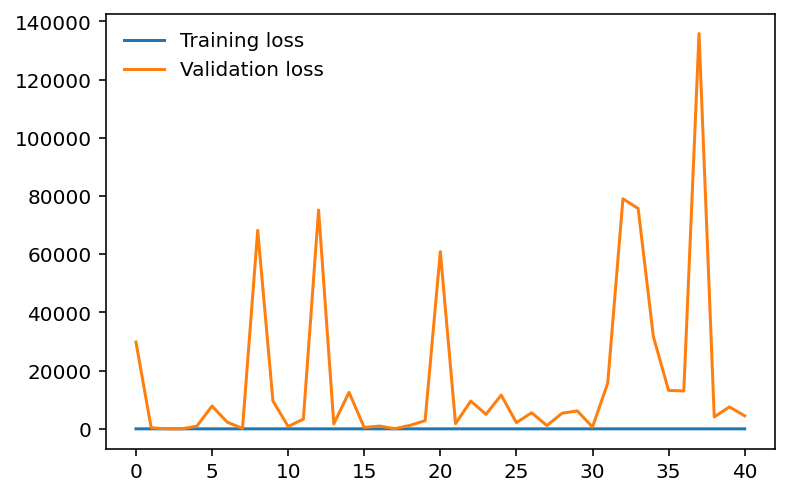

In [32]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [33]:
# write training results:
f = open(experiment_name+ "_result"+".csv", "w")
f.write('\t'.join(('tr_er', 'val_er')))
f.write('\n')
for (tr_er, val_er) in zip(train_losses, valid_losses,):
    items= (str(tr_er),',', str(val_er))
    f.write('\t'.join(items))
    f.write('\n')
f.close()

In [ ]:
# Load model and optimizer from disk:
embedding_net= torchvision.models.resnet18(pretrained=True)

# Freeze training for all layers parameters:
for param in embedding_net.parameters():
    param.required_grad = False    
    
embedding_net.fc= nn.Sequential(nn.Linear(512, 128),
                                nn.BatchNorm1d(128),
                                nn.ReLU(),
                                nn.Linear(128, 128), # embedding size
                                )

model= networks.TripletNet(embedding_net)

import torch.optim as optim
optimizer = optim.Adam(model.embedding_net.fc.parameters(), lr=1e-3)

PATH= experiment_name+'.pt'
check_point= torch.load(PATH)

model.embedding_net.load_state_dict(check_point['model_state_dict'])
optimizer.load_state_dict(check_point['optimizer_state_dict'])
epoch = check_point['epoch']
loss = check_point['loss']


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()